### Newsbot to write a daily AI news summary using langgraph
- Save a list of HTML files from sources.yaml (tech news sites)
- Extract URLs for the news stories
- Filter URLs to remove duplicates, articles seen before, and non-AI articles (using a ChatGPT prompt)
- Perform headline topic analysis and sort by topic to help the AI structure the response by topic
- Scrape and summarize individual articles
- Compose and email the summary
- Used to generate a daily newsletter at skynetandchill.com and potentially an autogenerated podcast

Possible TODOs:
- after writing summaries, could parallelize some stuff, topic analysis, ratings
- could also add tools to check format
- rewrite using an critic-refine flow, although one rewrite does an OK job
- do more evals with promptfoo, promptlayer, do prompt optimization with eg dspy or your own algo
- retrain reducer, identify a good number of dimensions using silhoutee score

update umap 

1. gather at least 2500 unique stories, do first 80% of days = train, rest = xval
2. run current cluster model in test, number of clusters, stories clustered and silhouette score
3. retrain current cluster params in train , run in test, collect data
4. train new cluster model on full headline + topics + summary, iterate over hyperparameters, gather scores
5. if headlines only are close , possibly retrain with xval on headlines only
6. output silhouette scores daily as part of the process 

In [27]:
# to selectively re-import as needed
import sys
# del sys.modules['ainb_llm']
# del sys.modules['ainb_const']
# del sys.modules['ainb_utilities']
# del sys.modules['ainb_webscrape']
# del sys.modules['AInewsbot_langgraph']



In [28]:
import os
import shutil
# import dotenv
# import subprocess

from collections import Counter
import json
import uuid
import re
# import operator
import pickle
from datetime import datetime, timedelta

import langchain
from langchain_openai import ChatOpenAI
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_anthropic import ChatAnthropic

from langchain_core.messages import SystemMessage, HumanMessage
from langchain_core.prompts import (ChatPromptTemplate, PromptTemplate,
                                    SystemMessagePromptTemplate, HumanMessagePromptTemplate)
from langchain_core.output_parsers import StrOutputParser, PydanticOutputParser

from langgraph.checkpoint.memory import MemorySaver
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages
from langgraph.errors import NodeInterrupt
from langchain.globals import set_debug

import numpy as np
import pandas as pd
import umap

import sklearn

import bs4

from tenacity import (
    retry,
    stop_after_attempt,
    wait_exponential,
    retry_if_exception_type
)

import asyncio
from asyncio import Semaphore

from IPython.display import HTML, Image, Markdown, display

# import pyperclip
# import shlex

import openai
from openai import OpenAI

from pydantic import BaseModel, Field
from typing import List, TypedDict, Annotated, Any

from google.cloud import aiplatform
from vertexai.language_models import TextGenerationModel
import google.generativeai as genai
import httpx

import trafilatura   # web scrape uses this to get clean news stories w/o a lot of js and boilerplate

from ainb_prompts import (
                        REWRITE_SYSTEM_PROMPT, REWRITE_USER_PROMPT,
                        SUMMARIZE_SYSTEM_PROMPT, SUMMARIZE_USER_PROMPT
                       )

from ainb_utilities import log

from AInewsbot_langgraph import (Agent, AgentState, initialize_agent,
                                )


import podcastfy
from podcastfy.client import generate_podcast, process_content

from IPython.display import Audio, display, Markdown

import pdb

# need this to run async in jupyter since it already has an asyncio event loop running
import asyncio
import nest_asyncio
nest_asyncio.apply()

# Activate global verbose logging
set_debug(False)


In [29]:
print(f"Python            {sys.version}")
print(f"LangChain         {langchain.__version__}")
print(f"OpenAI            {openai.__version__}")
# print(f"smtplib           {smtplib.sys.version}")
print(f"trafilatura       {trafilatura.__version__}")
# print(f"bs4               {bs4.__version__}")
print(f"numpy             {np.__version__}")
print(f"pandas            {pd.__version__}")
print(f"sklearn           {sklearn.__version__}")
print(f"umap              {umap.__version__}")
print(f"podcastfy         {podcastfy.__version__}")


Python            3.11.11 (main, Dec 11 2024, 10:25:04) [Clang 14.0.6 ]
LangChain         0.3.19
OpenAI            1.64.0
trafilatura       2.0.0
numpy             1.26.4
pandas            2.2.3
sklearn           1.6.1
umap              0.5.7
podcastfy         0.4.1


# Instantiate agent and run LangGraph workflow graph end to end

2025-05-10 07:40:21,696 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=e5f5856b80124369b573eb777ab2a8b7
2025-05-10 07:40:21,933 - AInewsbot - INFO - thread_id: e5f5856b80124369b573eb777ab2a8b7


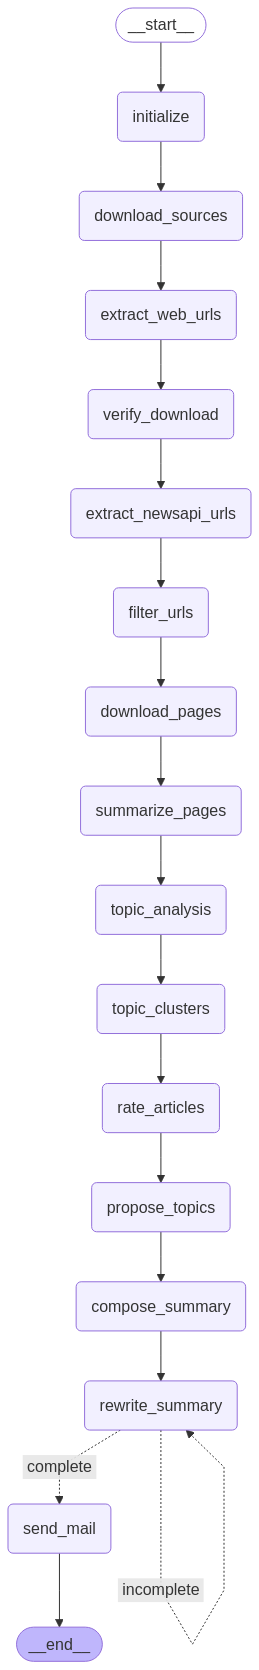

In [30]:
before_date = None
# before_date = '2025-05-03 18:00'
do_download = False

# low, medium, high models
ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1-mini', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'

lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)
log(f"thread_id: {thread_id}")

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))

In [31]:
config = {"configurable": {"thread_id": thread_id}}
state = lg_agent.run(lg_state, config)


2025-05-10 07:40:23,509 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-10 07:40:23,510 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-10 07:40:23,510 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-10 07:40:23,510 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-10 07:40:23,510 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-10 07:40:23,510 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-10 07:40:23,511 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

run exception
'src'
run exception
'src'
run exception
'src'


2025-05-10 07:40:23,720 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-10 07:40:23,725 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-10 07:40:23,725 - AInewsbot - INFO - 21 links found
2025-05-10 07:40:23,725 - AInewsbot - INFO - FT -> htmldata/FT.html
2025-05-10 07:40:23,767 - AInewsbot - INFO - parse_file - found 487 raw links
2025-05-10 07:40:23,772 - AInewsbot - INFO - parse_file - found 123 filtered links
2025-05-10 07:40:23,773 - AInewsbot - INFO - 123 links found
2025-05-10 07:40:23,773 - AInewsbot - INFO - Feedly AI -> htmldata/Feedly_AI.html
2025-05-10 07:40:23,819 - AInewsbot - INFO - parse_file - found 160 raw links
2025-05-10 07:40:23,821 - AInewsbot - INFO - parse_file - found 38 filtered links
2025-05-10 07:40:23,822 - AInewsbot - INFO - 38 links found
2025-05-10 07:40:23,822 - AInewsbot - INFO - Hacker News 1 -> htmldata/Hacker_News_1.html
2025-05-10 07:40:23,838 - AInewsbot - INFO - parse_file - found 229 raw links
2025-05-10 07:40:23,

,id
src,
Ars Technica,35
Bloomberg,29
Business Insider,21
FT,66
Feedly AI,32
Hacker News 1,24
Hacker News 2,23
HackerNoon,28
New York Times,19


2025-05-10 07:40:24,171 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


,id
src,
Ars Technica,35
Bloomberg,29
Business Insider,21
FT,66
Feedly AI,32
Hacker News 1,24
Hacker News 2,23
HackerNoon,28
New York Times,19


2025-05-10 07:40:24,176 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-09T07:40:24 from NewsAPI


,id
src,
Ars Technica,35
Bloomberg,29
Business Insider,21
FT,66
Feedly AI,32
Hacker News 1,24
Hacker News 2,23
HackerNoon,28
New York Times,19


2025-05-10 07:40:24,500 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-10 07:40:25,220 - AInewsbot - INFO - URLs in orig_df: 921
2025-05-10 07:40:25,224 - AInewsbot - INFO - Existing URLs in DB: 256739
2025-05-10 07:40:25,292 - AInewsbot - INFO - New URLs in df filtered by URL: 241
2025-05-10 07:40:25,486 - AInewsbot - INFO - Existing src+title: 34
2025-05-10 07:40:25,487 - AInewsbot - INFO - New URLs in df filtered by src+title: 207
2025-05-10 07:40:25,505 - AInewsbot - INFO - Found 207 unique new headlines
2025-05-10 07:40:25,509 - AInewsbot - INFO - Found 205 unique cleaned new headlines
2025-05-10 07:40:27,687 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 07:40:33,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 07:40:33,192 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 07:40:33,2

,id
src,
Business Insider,4
FT,1
Feedly AI,28
Hacker News 1,1
NewsAPI,33
Reddit,2
Techmeme,1
VentureBeat,1


2025-05-10 07:40:33,349 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-10 07:40:33,352 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-10 07:40:33,696 - AInewsbot - INFO - Launching browser
2025-05-10 07:40:35,690 - AInewsbot - INFO - Launching workers
2025-05-10 07:40:35,691 - AInewsbot - INFO - Launching worker
2025-05-10 07:40:35,691 - AInewsbot - INFO - from queue: 0, https://www.globenewswire.com/news-release/2025/05/09/3078053/28124/en/61-08-Bn-Artificial-Intelligence-in-Military-Market-Opportunities-and-Strategies-to-2034-Fueled-by-AI-Adoption-and-Defense-Budget-Increases-Amid-Privacy-and-Talent-Concerns.html , $61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns
2025-05-10 07:40:35,691 - AInewsbot - INFO - fetch_url(https://www.globenewswire.com/news-release/2025/05/09/3078053/28124/en/61-08-Bn-Artificial-Intelligence-in-Mil

2025-05-10 07:41:32,276 - AInewsbot - INFO - from queue: 15, https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-7th/ , Best Artificial Intelligence Stocks To Research  May 7th
2025-05-10 07:41:32,277 - AInewsbot - INFO - fetch_url(https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-7th/)
2025-05-10 07:41:32,278 - AInewsbot - INFO - Waiting 41.12207073348287 seconds to rate limit www.etfdailynews.com 1.0630787500413135
2025-05-10 07:41:36,517 - AInewsbot - INFO - Error fetching https://newrepublic.com/article/195029/ai-execs-demanding-government-support-no-questions-asked: Page.goto: Timeout 60000ms exceeded.
Call log:
  - navigating to "https://newrepublic.com/article/195029/ai-execs-demanding-government-support-no-questions-asked", waiting until "load"

2025-05-10 07:41:36,535 - AInewsbot - INFO - from queue: 16, https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent

2025-05-10 07:43:38,688 - AInewsbot - INFO - from queue: 29, https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/ , Fine-tuning vs. in-context learning: New research guides better LLM customization for real-world tasks
2025-05-10 07:43:38,689 - AInewsbot - INFO - fetch_url(https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)
2025-05-10 07:43:42,513 - AInewsbot - INFO - Saving HTML to htmlpages/Best_Artificial_Intelligence_Stocks_To_Research__May_7th.html
2025-05-10 07:43:42,971 - AInewsbot - INFO - from queue: 30, https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682 , Google Reveals How It Is Using AI to Combat Online Scams in Search, Chrome and Android
2025-05-10 07:43:42,973 - AInewsbot - INFO - fetch_url(https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-onl

2025-05-10 07:47:43,603 - AInewsbot - INFO - Saving HTML to htmlpages/Mark_Zuckerberg_says_AI_could_soon_do_the_work_of_some_engineers_at_Meta._Here_s_how_AI_is_shaking_up_other_Big_Tech_firms..html
2025-05-10 07:47:45,757 - AInewsbot - INFO - from queue: 44, https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html , Nvidia modifies H20 chip for China to overcome US export controls
2025-05-10 07:47:45,761 - AInewsbot - INFO - fetch_url(https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)
2025-05-10 07:48:28,156 - AInewsbot - INFO - Saving HTML to htmlpages/New_Era_of_AI_PCs_Begins__AMD_RyzenTM_AI_300_Series_Puts_Smart_Features_in_Your_Hands.html
2025-05-10 07:48:30,071 - AInewsbot - INFO - from queue: 45, https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5 , Nvidia vice president says GPUs are the 'currency' of AI researchers
2025-05-10 07:48:30,078 - 

2025-05-10 07:51:04,005 - AInewsbot - INFO - fetch_url(https://www.fiercebiotech.com/medtech/fda-appoints-first-chief-ai-officer-it-looks-speed-reviews)
2025-05-10 07:51:08,820 - AInewsbot - INFO - Saving HTML to htmlpages/Q_A_with_SAP_CEO_Christian_Klein_on_data_security__Databricks_partnership__building_a_social_network_for_B2B__positioning_SAP_as_a_neutral_player__and_more.html
2025-05-10 07:51:09,738 - AInewsbot - INFO - from queue: 59, https://flipboard.com/@techradar/the-week-in-ai-%E2%80%93-the-latest-news-in-chatgpt-gemini-and-more-fr4ks6ofgck72p44 , The week in AI  the latest news in ChatGPT, Gemini and more
2025-05-10 07:51:09,742 - AInewsbot - INFO - fetch_url(https://flipboard.com/@techradar/the-week-in-ai-%E2%80%93-the-latest-news-in-chatgpt-gemini-and-more-fr4ks6ofgck72p44)
2025-05-10 07:51:54,477 - AInewsbot - INFO - Error fetching https://www.forbes.com/councils/forbestechcouncil/2025/05/09/the-state-of-ai-as-a-service-what-to-expect-in-2025-and-beyond/: Page.goto: Time

2025-05-10 07:59:42,034 - AInewsbot - INFO - Saving HTML to htmlpages/Weeks_after_IPO__CoreWeave_reportedly_seeking__1.5B_in_debt_financing.html
2025-05-10 07:59:43,948 - AInewsbot - INFO - Saving HTML to htmlpages/Vision_Now_Available_in_Llama.cpp.html
2025-05-10 07:59:52,816 - AInewsbot - INFO - Saving HTML to htmlpages/Years_After_Promising_to_Stop_Facial_Recognition_Work__Meta_Has_a_Devious_New_Plan.html
2025-05-10 07:59:54,544 - AInewsbot - INFO - Saving HTML to htmlpages/mcdruid.co.uk__Hacking_the_AI_module_in_Drupal_CMS.html
2025-05-10 07:59:58,452 - AInewsbot - INFO - Saving HTML to htmlpages/Wildlife_Monitoring_Tools_-_WildTrack_Uses_AI_to_Identify_Animal_Prints_and_Support_Conservation__TrendHunter.com.html
2025-05-10 07:59:58,855 - AInewsbot - INFO - Finishing and closing browser


,id
src,
Business Insider,4
FT,1
Feedly AI,28
Hacker News 1,1
NewsAPI,33
Reddit,2
Techmeme,1
VentureBeat,1


2025-05-10 08:00:04,793 - AInewsbot - INFO - Starting summarize
2025-05-10 08:00:04,796 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-10 08:00:04,806 - AInewsbot - INFO - Attempting to fetch summaries for 71 articles
2025-05-10 08:00:04,842 - AInewsbot - INFO - clean_html - Page title: $61.08 Bn Artificial Intelligence in Military Market
Social card title: $61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns
Social card description: North America was the largest region in the artificial intelligence in military market, accounting for 33.66% or $3.25 billion of the total in 2024. It was...

2025-05-10 08:00:04,953 - AInewsbot - INFO - Queuing 0: Page title: $61.08 Bn Artificial Intelligence in M...
2025-05-10 08:00:04,956 - AInewsbot - INFO - clean_html - Page title: yahoo

2025-05-10 08:00:04,989 - AInewsbot - INFO - Queuing 1: Page title: yahoo
g

2025-05-10 08:00:06,143 - AInewsbot - INFO - Queuing 17: Page title: Character.AI legal argument could open...
2025-05-10 08:00:06,143 - AInewsbot - INFO - No path for 18
2025-05-10 08:00:06,181 - AInewsbot - INFO - clean_html - Page title: The Exclusive Pitch Deck That AI Agent Startup StackAI Used to Raise Funding - Business Insider
Social card title: Check out the exclusive pitch deck that landed no-code AI agent startup StackAI a $16 million funding round from Lobby VC
Social card description: No-code AI startup StackAI raises $16 million Series A from Lobby VC, offering enterprises tools to create AI agents for business operations.

2025-05-10 08:00:06,215 - AInewsbot - INFO - Queuing 19: Page title: The Exclusive Pitch Deck That AI Agent...
2025-05-10 08:00:06,250 - AInewsbot - INFO - clean_html - Page title: CodeRabbit (u/CodeRabbitAI) - Reddit

2025-05-10 08:00:06,288 - AInewsbot - INFO - Queuing 20: Page title: CodeRabbit (u/CodeRabbitAI) - Reddit
S...
2025-05-10 08:00:06,308 

2025-05-10 08:00:08,034 - AInewsbot - INFO - clean_html - Page title: I Made a Sci-Fi Film With AI for $300. I'm Conflicted About It. - Business Insider
Social card title: I'm a filmmaker who used AI to make a sci-fi film for under $300. I'm deeply conflicted about it.
Social card description: Aleem Hossain, a professor at Occidental College, made a movie using AI. He told BI he thinks it's "pretty good" but he's conflicted about using AI.

2025-05-10 08:00:08,058 - AInewsbot - INFO - Queuing 36: Page title: I Made a Sci-Fi Film With AI for $300....
2025-05-10 08:00:08,144 - AInewsbot - INFO - clean_html - Page title: Jim Fan says NVIDIA trained humanoid robots to move like humans -- zero-shot transfer from simulation to the real world. "These robots went through 10 years of training in only 2 hours." : r/singularity

2025-05-10 08:00:08,215 - AInewsbot - INFO - Queuing 37: Page title: Jim Fan says NVIDIA trained humanoid r...
2025-05-10 08:00:08,241 - AInewsbot - INFO - clean_html - P

2025-05-10 08:00:09,101 - AInewsbot - INFO - Queuing 53: Page title: The Wild World of Post-Grad Side Hustl...
2025-05-10 08:00:09,119 - AInewsbot - INFO - clean_html - Page title: ServiceNow acquires Data.World months after snatching up Moveworks | TechCrunch
Social card title: ServiceNow acquires Data.World months after snatching up Moveworks | TechCrunch
Social card description: Data.World's data cataloging and governance technology could help ServiceNow's customers get cleaner data — and more out of AI.

2025-05-10 08:00:09,145 - AInewsbot - INFO - Queuing 54: Page title: ServiceNow acquires Data.World months ...
2025-05-10 08:00:09,146 - AInewsbot - INFO - No path for 55
2025-05-10 08:00:09,146 - AInewsbot - INFO - No path for 56
2025-05-10 08:00:09,146 - AInewsbot - INFO - No path for 57
2025-05-10 08:00:09,164 - AInewsbot - INFO - clean_html - Page title: FDA appoints first chief AI officer as it looks to speed up reviews
Social card title: FDA appoints first chief AI officer as

async_langchain: 0, {'article': 'Page title: $61.08 Bn Artificial Intelligence in Military Market\nSocial card title: $61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns\nSocial card description: North America was the largest region in the artificial intelligence in military market, accounting for 33.66% or $3.25 billion of the total in 2024. It was...\nDublin, May 09, 2025 (GLOBE NEWSWIRE) -- The "Artificial Intelligence in Military Market Opportunities and Strategies to 2034" report has been added to ResearchAndMarkets.com\'s offering.\nThis report describes and explains the artificial intelligence in military market and covers 2019-2024, termed the historic period, and 2024-2029, 2034F termed the forecast period. The report evaluates the market across each region and for the major economies within each region.\nThe global artificial intelligence in military mark

2025-05-10 08:00:10,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:10,928 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 1 response: • no content
async_langchain: 52 response: • no content


2025-05-10 08:00:11,506 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:11,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 42 response: • The provided article is a "Page Not Found" error from Gadgets 360 on NDTV, containing no substantive or newsworthy content.
async_langchain: 20 response: • The Reddit user "CodeRabbit" (u/CodeRabbitAI) currently has no posts or comments on their profile.  
• The profile page primarily displays Reddit's standard navigation and topic categories but contains no original user content.


2025-05-10 08:00:12,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,353 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,472 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 59 response: • The article provides a weekly roundup of the latest developments and experiments in AI, focusing on technologies like ChatGPT and Google Gemini.  
• It highlights the rapid pace of AI advancements and shares current trends, including new AI image-generation fads and practical applications such as enhancing family photo albums.  
• The piece aims to help readers stay informed about the biggest AI news stories and breakthroughs from the past seven days.
async_langchain: 26 response: • Elton John and Dua Lipa, along with 400 creatives and media executives, have urged UK Labour leader Keir Starmer to support artists in the ongoing AI copyright dispute.  
• The group seeks political backing to limit Big Tech companies' use of artists' work in artificial intelligence training and applications.  
• The campaign highlights concerns about protecting artists' intellectual property rights amid the expanding influence of AI technologies in the creative industries.
a

2025-05-10 08:00:12,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 12 response: • Bjarke Ingels' installation at the Venice Biennale 2025 titled ‘ancient future’ combines traditional hand-carving techniques with advanced robotics, creating a dynamic fusion described by Ingels as a "living oxymoron."  
• The exhibit invites visitors to explore and reflect on the subtle differences between handcrafted and robotic methods, highlighting the interplay between tradition and technology in contemporary architecture.  
• The 19th International Architecture Exhibition in Venice features diverse pavilion designs and curatorial perspectives, emphasizing architecture’s evolving role in shaping cultural and societal futures.


2025-05-10 08:00:12,777 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,790 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,820 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,869 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,879 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,908 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,933 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:12,954 - httpx 

async_langchain: 34 response: • WhatsApp has introduced a new Meta AI blue circle icon on the chat screen for direct interaction with Meta's AI assistant, allowing users to generate images and ask questions.  
• Users can disable or remove the Meta AI button via a "Show Meta AI Button" toggle in WhatsApp's Chats settings, although this option is rolling out gradually and may not be available to all users yet.  
• Alternative workarounds include changing WhatsApp's app language to unsupported languages, installing older WhatsApp versions without AI integration, or using WhatsApp Business, which currently lacks the Meta AI feature.
async_langchain: 33 response: • OpenAI has enabled ChatGPT Deep Research to connect directly with GitHub repositories, allowing the AI to read source code and pull requests to conduct deep, multi-step research and generate detailed reports with citations.  
• This feature enhances ChatGPT's agentic research capabilities and is currently in beta, available to C

2025-05-10 08:00:13,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,131 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,151 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,203 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,213 - httpx 

async_langchain: 45 response: • Jonathan Cohen, VP of Applied Research at Nvidia, stated that GPUs are the "currency" of AI researchers, with access to computing power being a key limiting factor in AI development.  
• Cohen highlighted the rapid development of Nvidia’s Llama Nemotron models, completed in one to two months, attributing this speed to researchers sacrificing their own GPU resources and the company’s culture of prioritizing important projects through a cross-team collaborative "swarm" approach.  
• The project involved significant sacrifices in computing power and personnel, with teams working together without formal structure, exemplifying Nvidia’s leadership and a collective focus on advancing the AI initiative.
async_langchain: 54 response: • ServiceNow announced its acquisition of Data.World, a cloud-native data catalog and governance platform, to help customers organize, search, and govern their data for better AI deployment; terms of the deal were not disclosed.  
•

2025-05-10 08:00:13,276 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,329 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,361 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,417 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,430 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,436 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,467 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 50 response: • OpenAI CEO Sam Altman testified before Congress, emphasizing the need for the U.S. to pursue "sensible regulation" in artificial intelligence to maintain its lead over China without hindering innovation.  
• Altman warned against making a "silly mistake" with overregulation that could slow progress and acknowledged uncertainty about how far ahead the U.S. currently is in the AI race.  
• This marked Altman’s first congressional appearance in two years, underscoring the growing importance of AI policy in U.S. legislative discussions.
async_langchain: 51 response: • Samsung Galaxy AI and Apple Intelligence both offer advanced AI-powered writing tools, with Galaxy AI debuting earlier on the Galaxy S24 and Apple introducing its features with the iPhone 16 series.  
• In content summarization, Galaxy AI provides more detailed and varied summary styles, while Apple Intelligence offers an additional paragraph summary format and sharing options; both tie for web

2025-05-10 08:00:13,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,524 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,553 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,578 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,615 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,626 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,629 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,641 - httpx 

async_langchain: 16 response: • ByteDance has open-sourced DeerFlow, a modular multi-agent framework built on LangChain and LangGraph, designed to automate complex research workflows by coordinating specialized LLM agents for tasks like task planning, knowledge retrieval, code execution, and report synthesis.  
• DeerFlow integrates web search, Python REPL, visualization tools, and ByteDance’s Model Control Platform to enable multimodal output generation including slides, scripts, and visuals, with a strong emphasis on human-in-the-loop feedback for transparency and reliability.  
• The framework supports flexible deployment with Python 3.12+ and Node.js 22+, offers extensible agent graphs, and is available under the MIT license, targeting researchers, developers, and organizations aiming to operationalize AI-driven research workflows.
async_langchain: 49 response: • A recent paper by Jérémy Perez et al. investigates how large language models (LLMs) transform text through iterative int

2025-05-10 08:00:13,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,912 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 15 response: • MarketBeat's stock screener highlights Super Micro Computer, Tempus AI, Arista Networks, Upstart, and QUALCOMM as the top five AI stocks to watch on May 7th, noted for their involvement in AI technologies like machine learning, natural language processing, and computer vision.  
• Super Micro Computer focuses on high-performance server and storage solutions; Tempus AI advances precision medicine with AI in healthcare; Arista Networks provides cloud networking solutions; Upstart operates an AI lending platform; QUALCOMM develops wireless foundational technologies including 5G.  
• Recent trading activity shows mixed performance: Tempus AI and QUALCOMM stocks increased, while Super Micro Computer, Arista Networks, and Upstart saw declines, with all companies reflecting significant market interest due to AI-driven growth potential.
async_langchain: 41 response: • The article argues that truly decentralized AI is unlikely due to centralization in training da

2025-05-10 08:00:13,915 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,965 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:13,980 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,004 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,029 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 19 response: • StackAI, a San Francisco-based no-code AI agent platform founded in 2022, raised $16 million in a Series A funding round led by Lobby VC with participation from LifeX Ventures, Vercel CEO Guillermo Rauch, Weaviate CEO Bob Van, Gradient, Y Combinator, and Epakon Capital.  
• The startup enables companies to build AI agents that integrate with software like Snowflake and Salesforce to automate back-office tasks such as data entry, content aggregation, and categorization, with notable adoption among less tech-savvy industries like construction, local governments, and insurance.  
• Cofounders Bernard Aceituno and Antoni Rosino, both MIT PhD graduates, leverage AI heavily in StackAI’s development, rapidly adding integrations and models, reflecting a broader investor enthusiasm for AI agent startups in sectors including cybersecurity and automation.
async_langchain: 62 response: • llama.cpp now supports multimodal input through the libmtmd library, accessible

2025-05-10 08:00:14,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 53 response: • OpenAI CEO Sam Altman told Senate Commerce Committee that AI could eliminate up to 70% of jobs, emphasizing the unprecedented speed of this disruption and the need to prepare society for rapid change; he urged early AI adoption to help people adapt and enhance their work rather than be displaced.  
• IBM CEO Arvind Krishna confirmed AI automation has reduced some back-office roles, but overall headcount is increasing with hires focused on roles requiring human judgment; meanwhile, Duolingo is transforming into an “AI-first” company, cutting contract workers whose tasks AI can handle to focus employees on creative, complex work.  
• The World Economic Forum’s 2025 Future of Jobs Report forecasts AI and technology will eliminate 92 million jobs but create 170 million new ones by 2030, resulting in a net gain of 78 million jobs; however, reskilling and policy support are critical as administrative and routine jobs face major risks.


2025-05-10 08:00:14,370 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,398 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,429 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,488 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,513 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,522 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:14,531 - AInewsbot - INFO - Received 63 summaries
2025-05-10 08:00:14,532 - AInewsbot - INFO - Summary for 0 (length 10309): • The global artificial intelligence in military market is projected to grow from $9.67 billion in 2024 to $61.08 billion by 2034, w

2025-05-10 08:00:14,537 - AInewsbot - INFO - Summary for 12 (length 1182): • Bjarke Ingels' installation at the Venice Biennale 2025 titled ‘ancient future’ combines traditional hand-carving techniques with advanced robotics, creating a dynamic fusion described by Ingels as a "living oxymoron."  
• The exhibit invites visitors to explore and reflect on the subtle differences between handcrafted and robotic methods, highlighting the interplay between tradition and technology in contemporary architecture.  
• The 19th International Architecture Exhibition in Venice features diverse pavilion designs and curatorial perspectives, emphasizing architecture’s evolving role in shaping cultural and societal futures.
2025-05-10 08:00:14,537 - AInewsbot - INFO - Summary for 13 (length 32612): • Federal Reserve Governor Michael S. Barr outlined two potential scenarios for AI's impact on the labor market: an incremental progress scenario where AI gradually automates some tasks and complements human 

2025-05-10 08:00:14,539 - AInewsbot - INFO - Summary for 24 (length 5227): • OpenAI provides guidance on selecting the optimal ChatGPT model for different tasks to improve speed, quality, and relevance of AI outputs, warning that using the wrong model can lead to poor performance and wasted usage.  
• GPT-4o is recommended as an all-purpose multitasker with multimodal input capabilities; GPT-4.5 excels at creative, human-like communication tasks; o4-mini and o4-mini-high are suited for quick and detailed technical help respectively; o3 handles complex, multistep problems; and o1 Pro Mode is designed for high-stakes, detailed analysis in industries like finance, law, and healthcare.  
• OpenAI stresses that no single ChatGPT model fits all needs, so users should select models based on task complexity and required output to maximize efficiency and effectiveness.
2025-05-10 08:00:14,539 - AInewsbot - INFO - Summary for 25 (length 7133): • OpenAI plans to acquire Windsurf for about $3 bill

2025-05-10 08:00:14,540 - AInewsbot - INFO - Summary for 34 (length 6254): • WhatsApp has introduced a new Meta AI blue circle icon on the chat screen for direct interaction with Meta's AI assistant, allowing users to generate images and ask questions.  
• Users can disable or remove the Meta AI button via a "Show Meta AI Button" toggle in WhatsApp's Chats settings, although this option is rolling out gradually and may not be available to all users yet.  
• Alternative workarounds include changing WhatsApp's app language to unsupported languages, installing older WhatsApp versions without AI integration, or using WhatsApp Business, which currently lacks the Meta AI feature.
2025-05-10 08:00:14,540 - AInewsbot - INFO - Summary for 35 (length 7551): • Notion Mail is an AI-powered email client that integrates with Gmail accounts, featuring a minimal, multitasking-friendly interface and advanced AI functions like Autolabel, which automatically tags and filters emails based on user-defined 

2025-05-10 08:00:14,542 - AInewsbot - INFO - Summary for 46 (length 10166): • OpenAI has acquired Windsurf, the second-largest AI development platform, for $3 billion to strengthen its position in AI innovation and accelerate progress toward artificial general intelligence (AGI).  
• The acquisition provides OpenAI with a highly customizable, proprietary coding environment, enhancing AI-powered coding capabilities and offering strategic advantages like improved performance, data insights, and faster innovation.  
• This move disrupts the competitive AI landscape, prompting rivals such as Google and Anthropic to reassess their strategies, with Google likely to accelerate efforts to acquire Cursor, the market leader in AI development platforms.
2025-05-10 08:00:14,542 - AInewsbot - INFO - Summary for 47 (length 37632): • SAP CEO Christian Klein emphasizes SAP’s strategic advantage in enterprise AI through its extensive mission-critical business data and unified cloud platform integrating

2025-05-10 08:00:14,543 - AInewsbot - INFO - Summary for 62 (length 2541): • llama.cpp now supports multimodal input through the libmtmd library, accessible via tools like llama-mtmd-cli and llama-server using an OpenAI-compatible /chat/completions API.  
• Users can enable multimodal features by loading compatible models with specific command-line options (-hf with --mmproj or -m with --mmproj), and GPU offloading for multimodal projectors is enabled by default but can be disabled with --no-mmproj-offload.  
• Ready-to-use multimodal models include Gemma 3 series, SmolVLM variants, Pixtral 12B, Qwen 2 and 2.5 VL series, and Mistral Small 3.1 24B, most provided with Q4_K_M quantization and some requiring large context windows for operation.
2025-05-10 08:00:14,543 - AInewsbot - INFO - Summary for 63 (length 3815): • Weeks after its March IPO that raised $1.5 billion, CoreWeave is reportedly seeking an additional $1.5 billion in debt financing through high-yield bonds, with JPMorgan Cha

async_langchain: 25 response: • OpenAI plans to acquire Windsurf for about $3 billion, marking its largest acquisition, while confirming it will retain nonprofit control over its for-profit operations by transitioning to a public benefit corporation (PBC), emphasizing ethical use and transparency; this follows tensions and a lawsuit from Elon Musk opposing OpenAI's shift toward for-profit status.  
• DoorDash is acquiring UK-based Deliveroo in an all-cash deal valued at £2.9 billion ($3.9 billion), expanding DoorDash's reach to over 40 countries amid Deliveroo's struggles since going public, highlighting challenges for UK tech firms in public markets.  
• Microsoft officially shut down Skype, transitioning users to Teams, and announced support for Google’s Agent2Agent open protocol to enhance AI agent collaboration, while IBM is focusing on AI agent tools for enterprises and Figma launched four new AI-powered design products at its conference.
async_langchain: 32 response: • Generative

,id
src,
Business Insider,4
FT,1
Feedly AI,28
Hacker News 1,1
NewsAPI,33
Reddit,2
Techmeme,1
VentureBeat,1


2025-05-10 08:00:14,552 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-10 08:00:22,682 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:27,891 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:27,896 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:28,675 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:28,684 - AInewsbot - INFO - 71 free-form topics extracted
2025-05-10 08:00:28,686 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-10 08:00:28,687 - AInewsbot - INFO - Canonical topic retrieval augmented generation
2025-05-10 08:00:28,687 - AInewsbot - INFO - Canonical topic review
2

2025-05-10 08:00:28,713 - AInewsbot - INFO - Canonical topic speech recognition & synthesis
2025-05-10 08:00:28,713 - AInewsbot - INFO - Canonical topic ethics
2025-05-10 08:00:28,714 - AInewsbot - INFO - Canonical topic politics
2025-05-10 08:00:28,714 - AInewsbot - INFO - Canonical topic inequality
2025-05-10 08:00:28,714 - AInewsbot - INFO - Canonical topic consciousness
2025-05-10 08:00:28,714 - AInewsbot - INFO - Canonical topic code assistants
2025-05-10 08:00:28,714 - AInewsbot - INFO - Sending prompt for 105 canonical topics
2025-05-10 08:00:31,458 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:31,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:31,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:32,350 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/complet

2025-05-10 08:00:33,946 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:33,953 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:33,958 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:33,966 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:33,974 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:33,979 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:33,990 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:34,009 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:34,027 - httpx 

2025-05-10 08:00:35,026 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,035 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,036 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,056 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,063 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,069 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,071 - httpx 

2025-05-10 08:00:35,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,500 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,505 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,508 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,516 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,528 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,537 - httpx 

2025-05-10 08:00:35,807 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,809 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,819 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,825 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,828 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:35,845 - httpx 

2025-05-10 08:00:36,134 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,135 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,158 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,163 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,164 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:36,173 - httpx 

2025-05-10 08:00:37,374 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:37,449 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:37,832 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:37,925 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:37,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:38,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:38,031 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:38,033 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:38,116 - httpx 

2025-05-10 08:00:40,168 - AInewsbot - INFO - Queuing 55: ### <<<ARTICLE SUMMARY>>>
# SoundCloud quietly cha...
2025-05-10 08:00:40,169 - AInewsbot - INFO - Queuing 56: ### <<<ARTICLE SUMMARY>>>
# The Giants of Silicon ...
2025-05-10 08:00:40,169 - AInewsbot - INFO - Queuing 57: ### <<<ARTICLE SUMMARY>>>
# The State Of AI-As-A-S...
2025-05-10 08:00:40,170 - AInewsbot - INFO - Queuing 58: ### <<<ARTICLE SUMMARY>>>
# The US FDA plans to de...
2025-05-10 08:00:40,170 - AInewsbot - INFO - Queuing 59: ### <<<ARTICLE SUMMARY>>>
# The week in AI  the la...
2025-05-10 08:00:40,170 - AInewsbot - INFO - Queuing 60: ### <<<ARTICLE SUMMARY>>>
# Theres a new AI agent ...
2025-05-10 08:00:40,170 - AInewsbot - INFO - Queuing 61: ### <<<ARTICLE SUMMARY>>>
# Troy Baker & Yasmeen F...
2025-05-10 08:00:40,170 - AInewsbot - INFO - Queuing 62: ### <<<ARTICLE SUMMARY>>>
# Vision Now Available i...
2025-05-10 08:00:40,171 - AInewsbot - INFO - Queuing 63: ### <<<ARTICLE SUMMARY>>>
# Weeks after IPO, CoreW...
2

async_langchain: 0, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# $61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns\n\n• The global artificial intelligence in military market is projected to grow from $9.67 billion in 2024 to $61.08 billion by 2034, with a CAGR of 20.57% from 2029 to 2034, driven by increasing defense budgets, AI adoption, and government initiatives amid challenges like data privacy and talent shortages.  \n• Key market segments include software (largest by offering), machine learning (largest by technology), and land platforms (largest by platform), while fastest growth is expected in hardware, context-aware computing, and space platforms respectively; new procurements dominate installation segments with significant growth in threat monitoring and situational awareness applications.  \n• Leading competitors such as BAE Systems, Lockheed Martin, N

2025-05-10 08:00:41,410 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:41,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 4 response: items=[]
async_langchain: 55 response: items=[]


2025-05-10 08:00:41,934 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:41,936 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:41,943 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:41,972 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,062 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,085 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 1 response: items=[]
async_langchain: 42 response: items=[]
async_langchain: 52 response: items=[]
async_langchain: 57 response: items=[]
async_langchain: 61 response: items=[]
async_langchain: 38 response: items=['AI In Software Engineering', 'Job Automation', 'Future Of Work', 'Meta', 'Tech Industry AI Adoption', 'Mark Zuckerberg']
async_langchain: 20 response: items=[]


2025-05-10 08:00:42,175 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,190 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,197 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,305 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,324 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,360 - httpx 

async_langchain: 10 response: items=[]
async_langchain: 65 response: items=[]
async_langchain: 18 response: items=[]
async_langchain: 0 response: items=['Artificial Intelligence Military Market', 'AI Adoption In Defense', 'Defense Budgets', 'Machine Learning', 'Hardware', 'Mergers And Acquisitions', 'Privacy']
async_langchain: 56 response: items=[]
async_langchain: 3 response: items=['AI Hallucinations', 'Chatbot Factual Accuracy', 'Instructing AI Responses', 'Large Language Models', 'Misinformation', 'Testing', 'Safety and Alignment']
async_langchain: 15 response: items=['AI Stock Market', 'Machine Learning', 'Natural Language Processing', 'Computer Vision', 'Healthcare', 'Fintech', 'Semiconductor Chips']
async_langchain: 8 response: items=['AI Deepfakes In Court', 'AI Evidence In Judiciary', 'Legal AI Ethics', 'AI And Data Privacy', 'Bias And Fairness', 'AI Regulation In Law']
async_langchain: 41 response: items=['Decentralized AI', 'AI Legal Challenges', 'AI Control Problem', 'Artif

2025-05-10 08:00:42,409 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,446 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 19 response: items=['No-Code AI Agents', 'AI Integrations', 'AI Automation In Industries', 'StackAI Funding', 'Venture Capital', 'AI Startup Ecosystem']
async_langchain: 34 response: items=['Meta AI Assistant', 'WhatsApp', 'User Interface Customization', 'Chat Features', 'Virtual Assistants', 'Meta']


2025-05-10 08:00:42,712 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,713 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,714 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,715 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,718 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,728 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,755 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:42,757 - httpx 

async_langchain: 12 response: items=['Bjarke Ingels', 'Venice Biennale 2025', 'Handcraft and Robotics', 'Architectural Innovation', 'Technology and Tradition']
async_langchain: 25 response: items=['OpenAI Acquisition', 'Public Benefit Corporation', 'Windsurf Acquisition', 'Doordash Acquisition', 'Deliveroo Merger', 'Microsoft AI Protocols', 'AI Design Tools']
async_langchain: 46 response: items=['OpenAI Acquisition', 'Windsurf AI Platform', 'Artificial General Intelligence', 'AI Coding Environments', 'AI Industry Competition', 'Mergers and Acquisitions']
async_langchain: 13 response: items=['AI Labor Market Scenarios', 'Job Automation', 'Economic Impacts Of AI', 'Labor Market', 'Inequality', 'Workforce Retraining', 'Federal Reserve AI Outlook']
async_langchain: 14 response: items=['AI Stocks', 'Investor Interest In AI', 'Machine Learning Companies', 'Specific AI Technology Firms', 'Finance']
async_langchain: 66 response: items=['AI-Assisted Learning', 'Developer Upskilling', 'It Skills

2025-05-10 08:00:43,113 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:43,127 - AInewsbot - INFO - Received 71 responses
2025-05-10 08:00:43,132 - AInewsbot - INFO - End topic analysis


async_langchain: 17 response: items=['Character.AI Legal Case', 'AI And Free Speech', 'AI Personhood Debate', 'Constitutional Rights And AI', 'AI Liability', 'Ethics', 'Policy And Regulation']


,id
src,
Business Insider,4
FT,1
Feedly AI,28
Hacker News 1,1
NewsAPI,33
Reddit,2
Techmeme,1
VentureBeat,1


2025-05-10 08:00:43,149 - AInewsbot - INFO - Fetching embeddings for 71 headlines
2025-05-10 08:00:44,014 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/embeddings "HTTP/1.1 200 OK"
2025-05-10 08:00:44,331 - AInewsbot - INFO - Sort with nearest_neighbor_sort
2025-05-10 08:00:44,349 - AInewsbot - INFO - Load umap dimensionality reduction model
2025-05-10 08:00:45,238 - AInewsbot - INFO - Perform dimensionality reduction
/opt/anaconda3/envs/ainewsbot/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
2025-05-10 08:00:45,363 - AInewsbot - INFO - Cluster with DBSCAN
2025-05-10 08:00:45,381 - AInewsbot - INFO - Found 2 clusters


,title_topic_str
0,"APEC tackles AI challenges, labor gaps in Jeju (Topics: AI Impact On Workforce, Apec Labor Market, Digital Education Tools, Inclusive Workforce Development, Labor Policy, Youth Employment, Regional Collaboration)"
1,"AI HR Is Going To Rock Our Worlds As AI Adoption Soars (Topics: AI In Human Resources, AI-Driven Recruitment, AI Oversight In Hr, HR Technology Adoption, AI And Company Culture)"
2,"Barr, Artificial Intelligence and the Labor Market: A Scenario-Based Approach (Topics: AI Labor Market Scenarios, Job Automation, Economic Impacts Of AI, Labor Market, Inequality, Workforce Retraining, Federal Reserve AI Outlook)"


2025-05-10 08:00:46,867 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:46,901 - AInewsbot - INFO - I dub this cluster: AI's Impact on Labor Markets


,title_topic_str
3,"Best Artificial Intelligence Stocks To Research May 7th (Topics: AI Stock Market, Machine Learning, Natural Language Processing, Computer Vision, Healthcare, Fintech, Semiconductor Chips)"
4,"Best Artificial Intelligence Stocks To Research May 6th (Topics: AI Stocks, Investor Interest In AI, Machine Learning Companies, Specific AI Technology Firms, Finance)"
5,Sell in May and Go Away? Absolutely Not -- 1 Artificial Intelligence (AI) Stock to Buy Hand Over Fist Instead. (Topics: )


2025-05-10 08:00:48,186 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:48,207 - AInewsbot - INFO - I dub this cluster: Top Artificial Intelligence Stocks
2025-05-10 08:00:48,214 - AInewsbot - INFO - ["AI's Impact on Labor Markets", 'Top Artificial Intelligence Stocks']


bullets created


[APEC tackles AI challenges, labor gaps in Jeju - en.antaranews.com](https://en.antaranews.com/news/354617/apec-tackles-ai-challenges-labor-gaps-in-jeju)

Topics: AI Impact On Workforce, Apec Labor Market, Digital Education Tools, Inclusive Workforce Development, Labor Policy, Youth Employment, Regional Collaboration

• APEC economies met in Jeju for four days to address workforce challenges including AI impacts, labor market mismatches, and education system reforms to keep pace with technological disruption.  
• South Korean officials highlighted initiatives like AI-powered digital textbooks, flexible labor policies, lifelong learning support, and protections for vulnerable workers in non-standard jobs to adapt to changing labor markets.  
• The meeting set the stage for upcoming ministerial discussions focusing on disability inclusion, digital skills, youth employment, and regional collaboration, with proposals for a regional fund supporting future generations and inclusive workforce development.



[AI HR Is Going To Rock Our Worlds As AI Adoption Soars - Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)

Topics: AI In Human Resources, AI-Driven Recruitment, AI Oversight In Hr, HR Technology Adoption, AI And Company Culture

• AI adoption is rapidly transforming human resources, with AI systems increasingly handling functions like recruitment, onboarding, and the entire employee lifecycle, effectively taking over tasks traditionally performed by human HR staff.  
• Vinay Gidwaney of One Digital highlights that most HR departments are unprepared and underskilled for AI's impact, emphasizing that AI provides "mediocre advice" and requires human oversight to be effective.  
• One Digital uses AI "deep personas" with detailed biographies, qualifications, and evaluations, designed to act like human coworkers, raising questions about merit-based hiring, company culture, and the need for HR to lead AI integration discussions within organizations.



[Barr, Artificial Intelligence and the Labor Market: A Scenario-Based Approach - www.federalreserve.gov](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)

Topics: AI Labor Market Scenarios, Job Automation, Economic Impacts Of AI, Labor Market, Inequality, Workforce Retraining, Federal Reserve AI Outlook

• Federal Reserve Governor Michael S. Barr outlined two potential scenarios for AI's impact on the labor market: an incremental progress scenario where AI gradually automates some tasks and complements human work, and a transformative scenario where AI radically changes or replaces many jobs, leading to profound economic and social shifts.  
• In the incremental scenario, AI adoption boosts productivity, creates new job categories, supports real wage growth, and allows time for workforce retraining, though some worker displacement and increased wage inequality may occur due to skill-biased technological change.  
• The transformative scenario envisions widespread automation of cognitive and manual tasks, possibly reducing human labor demand, increasing unemployment risks, and reshaping income distribution, while also generating significant economic growth, leisure, and health advances; monetary policy may need to adjust to changes in natural unemployment and neutral interest rates as these developments unfold.



[Best Artificial Intelligence Stocks To Research  May 7th - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-7th/)

Topics: AI Stock Market, Machine Learning, Natural Language Processing, Computer Vision, Healthcare, Fintech, Semiconductor Chips

• MarketBeat's stock screener highlights Super Micro Computer, Tempus AI, Arista Networks, Upstart, and QUALCOMM as the top five AI stocks to watch on May 7th, noted for their involvement in AI technologies like machine learning, natural language processing, and computer vision.  
• Super Micro Computer focuses on high-performance server and storage solutions; Tempus AI advances precision medicine with AI in healthcare; Arista Networks provides cloud networking solutions; Upstart operates an AI lending platform; QUALCOMM develops wireless foundational technologies including 5G.  
• Recent trading activity shows mixed performance: Tempus AI and QUALCOMM stocks increased, while Super Micro Computer, Arista Networks, and Upstart saw declines, with all companies reflecting significant market interest due to AI-driven growth potential.



[Best Artificial Intelligence Stocks To Research  May 6th - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-6th/)

Topics: AI Stocks, Investor Interest In AI, Machine Learning Companies, Specific AI Technology Firms, Finance

• MarketBeat identifies seven Artificial Intelligence stocks to watch on May 6th: Super Micro Computer, Salesforce, ServiceNow, Arista Networks, Accenture, QUALCOMM, and Tempus AI, based on highest recent dollar trading volumes.  
• These companies are involved in AI-driven technologies like machine learning, data analytics, and intelligent automation, with investor interest due to AI’s rapid adoption across various industries.  
• Stock performance highlights include Super Micro Computer trading at \\$32.63, Salesforce at \\$273.78, and Tempus AI at \\$53.15, with detailed financial metrics such as market capitalization, P/E ratios, and trading volumes provided for each.



[Sell in May and Go Away? Absolutely Not -- 1 Artificial Intelligence (AI) Stock to Buy Hand Over Fist Instead. - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_aaa30ea2-0748-4ec1-8910-e6b4299408d9)

Topics: 

• no content



[SoundCloud quietly changed its policies to allow the company to use audio uploaded by users on its platform to "inform, train, develop or serve as input to AI" (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/09/soundcloud-changes-policies-to-allow-ai-training-on-user-content/)

Topics: 

None



[A study finds that asking LLMs to be concise in their answers, particularly on ambiguous topics, can negatively affect factuality and worsen hallucinations (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)

Topics: AI Hallucinations, Chatbot Factual Accuracy, Instructing AI Responses, Large Language Models, Misinformation, Testing, Safety and Alignment

• A study by AI testing company Giskard found that instructing chatbots to provide short answers can increase hallucinations, reducing factual accuracy, especially on ambiguous or misleading questions.  
• Researchers note that brevity limits the model’s ability to debunk misinformation, as longer explanations are needed to identify and correct false premises.  
• The study also highlights that models are less likely to challenge confident but false claims and that preferences for certain models do not always align with truthfulness, illustrating tension between user experience optimization and factual accuracy.



[How Amazon and Walmart Are Rewiring Retails Future With Robotics - PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)

Topics: Amazon Robotics, Vulcan Robot, Retail Automation, Walmart Innovations, 3D Printing, Job Automation, Economics

• Amazon introduced Vulcan, its first robotic fulfillment center worker with a sense of touch, capable of handling 75% of warehouse items over 20-hour shifts to aid human workers and reduce physical strain, continuing Amazon's investment in over 750,000 AI-integrated robots in logistics.  
• Walmart partnered with Alquist 3D to rapidly construct a 5,000-square-foot warehouse extension using robotic 3D printing, unveiled a new "Store of the Future" in Texas blending physical and digital retail, and launched initiatives like the \\$350 billion “Grow with US” program to boost U.S. manufacturing and small businesses.  
• Recent college graduates face financial pressures from student loan debts leading to unconventional side hustles, such as reselling limited-edition sneakers, reflecting a broader economic challenge where traditional career entry is hindered by high debt and living costs.



[ServiceNow agrees to acquire cloud-native data catalog and data governance startup Data.World, which had raised over \\$130M and was valued at \\$350M in 2022 (Rebecca Szkutak/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)

Topics: Data.World Data Catalog, Data Governance, AI-Ready Enterprise Data, ServiceNow Acquisition, Mergers And Acquisitions, AI Automation Tools

• ServiceNow announced its acquisition of Data.World, a cloud-native data catalog and governance platform, to help customers organize, search, and govern their data for better AI deployment; terms of the deal were not disclosed.  
• This acquisition follows ServiceNow’s March purchase of Moveworks for \\$2.85 billion, reflecting the company’s strategy to embrace agentic AI through a mix of building and acquiring capabilities.  
• Gaurav Rewari, ServiceNow’s SVP and GM of data analytics, emphasized that Data.World’s metadata management and data governance tools are key to making enterprise data "AI-ready" and enhancing AI automation outcomes.



[AI deepfakes make their way into courtrooms - Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)

Topics: AI Deepfakes In Court, AI Evidence In Judiciary, Legal AI Ethics, AI And Data Privacy, Bias And Fairness, AI Regulation In Law

• In a landmark Arizona case, an AI-generated deepfake video of murder victim Chris Pelkey was presented in court during a victim impact statement, influencing the judge's sentencing of the accused to 10.5 years in prison; the video was created by training AI on footage of Pelkey and aging him digitally.  
• Legal experts highlight the ethical challenges posed by AI in courtrooms, including risks of bias from AI training data, potential for misleading evidence, data privacy concerns, and the difficulty in explaining AI-driven decisions.  
• Despite concerns and some sanctions against improper AI use by lawyers, courts are seeking clearer guidelines, with a federal panel seeking public input on AI-related evidence standards; Supreme Court Chief Justice John Roberts urges cautious consideration as AI deepfakes become more common in legal proceedings.



[Check out the exclusive pitch deck that landed no-code AI agent startup StackAI a \\$16 million funding round from Lobby VC - Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)

Topics: No-Code AI Agents, AI Integrations, AI Automation In Industries, StackAI Funding, Venture Capital, AI Startup Ecosystem

• StackAI, a San Francisco-based no-code AI agent platform founded in 2022, raised \\$16 million in a Series A funding round led by Lobby VC with participation from LifeX Ventures, Vercel CEO Guillermo Rauch, Weaviate CEO Bob Van, Gradient, Y Combinator, and Epakon Capital.  
• The startup enables companies to build AI agents that integrate with software like Snowflake and Salesforce to automate back-office tasks such as data entry, content aggregation, and categorization, with notable adoption among less tech-savvy industries like construction, local governments, and insurance.  
• Cofounders Bernard Aceituno and Antoni Rosino, both MIT PhD graduates, leverage AI heavily in StackAI’s development, rapidly adding integrations and models, reflecting a broader investor enthusiasm for AI agent startups in sectors including cybersecurity and automation.



[ChatGPT delayed a feature that people shouldnt be allowed to use anyway - BGR](https://bgr.com/tech/chatgpt-delayed-a-feature-that-people-shouldnt-be-allowed-to-use-anyway/)

Topics: 

None



[Datadog acquires Eppo, which offers feature flagging and app experimentation tools, reportedly for \\$220M; Eppo had raised \\$47.5M and was valued at \\$80M in 2022 (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)

Topics: Datadog, Eppo Acquisition, Feature Flagging, App Experimentation Tools, Machine Learning, Product Analytics Market, Mergers and Acquisitions

• Datadog has acquired Eppo, a feature-flagging and experimentation platform, in a deal reportedly valued at around \\$220 million; Eppo will continue operating under the brand “Eppo by Datadog.”  
• Eppo, founded by CEO Che Sharma and inspired by his data science experience at Airbnb and Webflow, offers tools for app experimentation including “confidence intervals” and supports live AI and machine learning model experiments to identify outperforming models.  
• This acquisition aims to enhance Datadog’s product analytics offerings amid a competitive market expected to grow from \\$9.09 billion in 2023 to \\$27.01 billion by 2032, helping businesses reduce risk, accelerate learning, and improve product quality through integrated product analytics, AI, and feature management.



[Why using AI as a replacement for junior developer talent is a mistake [Q&A] - betanews.com](https://betanews.com/2025/05/09/why-using-ai-as-a-replacement-for-junior-developer-talent-is-a-mistake-qa/)

Topics: AI-Assisted Learning, Developer Upskilling, It Skills Gap, Job Automation, Junior Developer Skills

• Hadi Chami, director of solution engineering at Apryse, warns that using AI to replace junior developers is a short-term fix that risks widening the IT skills gap as experienced professionals retire.  
• He advocates for investing in upskilling junior talent through structured development programs and mentorship from senior engineers, using AI as a tool to aid learning rather than a replacement.  
• AI should complement developer workflows by automating repetitive tasks but not hinder critical thinking, ensuring that junior developers build core technical skills while enhancing productivity.



[Theres a new AI agent ready to browse the web and fill in forms without the need to touch your mouse - TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)

Topics: Open Computer Agent, AI Web Automation, Active AI Agents, Hugging Face, Smolagents Initiative, Open Source

• Hugging Face has launched the Open Computer Agent, a free, open-source AI tool that can navigate the web, fill out forms, click buttons, and perform tasks like booking tickets or getting directions by controlling a real web browser.  
• The AI agent operates through natural language commands and mimics human interactions with websites, although it may require user intervention for logins or CAPTCHAs and is currently available as a demo that can experience delays due to demand.  
• The Open Computer Agent is part of Hugging Face's "smolagents" initiative and follows a similar active-agent philosophy seen in tools like OpenAI's Operator and Browser Use, aiming to become a versatile AI assistant rather than just a passive information source.



[mcdruid.co.uk: Hacking the AI module in Drupal CMS - www.mcdruid.co.uk](https://www.mcdruid.co.uk/article/hacking-ai-module-drupal-cms)

Topics: AI Module Vulnerabilities, Drupal CMS, Large Language Models, Llm-Generated Input Risks, Remote Code Execution, Web Application Security, Open Source

• In March 2025, the Drupal Security Team released advisories (CVE-2025-3169 and CVE-2025-31693) addressing Remote Code Execution and Arbitrary File Deletion vulnerabilities in the Drupal AI module, discovered due to insufficient validation of shell command inputs derived from untrusted sources like LLM-generated timestamps and uploaded file names.  
• The primary exploit involved injecting malicious shell commands through unsanitized LLM output or uploaded video filenames, allowing attackers to execute arbitrary code via PHP's exec() function; a related "Gadget Chain" vulnerability allowed file deletion and potential code execution if combined with unsafe deserialization in Drupal.  
• These vulnerabilities are fully mitigated in AI module version 1.0.5 and later by properly sanitizing inputs with PHP functions like escapeshellarg, highlighting the security risks of treating AI/LLM outputs as trusted input in web applications.



[CodeRabbitAI - Reddit](https://www.reddit.com/user/CodeRabbitAI)

Topics: 

• The Reddit user "CodeRabbit" (u/CodeRabbitAI) currently has no posts or comments on their profile.  
• The profile page primarily displays Reddit's standard navigation and topic categories but contains no original user content.



[3 Reasons Nvidia Stock Is Still a Top Artificial Intelligence Buy Right Now - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_beaaf005-3b8a-478b-aee6-e48c207a99ab)

Topics: 

• no content



[\\$61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/09/3078053/28124/en/61-08-Bn-Artificial-Intelligence-in-Military-Market-Opportunities-and-Strategies-to-2034-Fueled-by-AI-Adoption-and-Defense-Budget-Increases-Amid-Privacy-and-Talent-Concerns.html)

Topics: Artificial Intelligence Military Market, AI Adoption In Defense, Defense Budgets, Machine Learning, Hardware, Mergers And Acquisitions, Privacy

• The global artificial intelligence in military market is projected to grow from \\$9.67 billion in 2024 to \\$61.08 billion by 2034, with a CAGR of 20.57% from 2029 to 2034, driven by increasing defense budgets, AI adoption, and government initiatives amid challenges like data privacy and talent shortages.  
• Key market segments include software (largest by offering), machine learning (largest by technology), and land platforms (largest by platform), while fastest growth is expected in hardware, context-aware computing, and space platforms respectively; new procurements dominate installation segments with significant growth in threat monitoring and situational awareness applications.  
• Leading competitors such as BAE Systems, Lockheed Martin, Northrop Grumman, and Raytheon Technologies employ strategies focused on strategic partnerships, product advancements, and expansion in emerging markets; notable recent acquisitions include EMCORE’s acquisition of L3Harris Technologies and Safran's acquisition of Preligens to strengthen AI capabilities in defense.



[Jim Fan says NVIDIA trained humanoid robots to move like humans -- zero-shot transfer from simulation to the real world. "These robots went through 10 years of training in only 2 hours." - Reddit](https://v.redd.it/mfzs81cq3sze1)

Topics: Humanoid Robots, Simulation to Real World Transfer, Robotics Training, AI Learning Acceleration, Nvidia

• NVIDIA has trained humanoid robots to move like humans using a method that allows zero-shot transfer from simulation to the real world, achieving in 2 hours what would traditionally take 10 years of training.  
• The robots learned physical embodiment skills with only 1.5 million parameters, suggesting a scalable approach to robotics training.  
• The development represents a significant technological advancement in AI learning speed, generating excitement about future applications in robotics and AI integration.



[Character.AI opens a back door to free speech rights for chatbots - Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)

Topics: Character.AI Legal Case, AI And Free Speech, AI Personhood Debate, Constitutional Rights And AI, AI Liability, Ethics, Policy And Regulation

• Character.AI is arguing in court that its chatbot outputs, including harmful content involved in a wrongful death lawsuit, constitute protected speech under the First Amendment, based on users' "listeners' rights" rather than the chatbot as a speaker with intent.  
• This legal strategy, if accepted, could set a precedent extending free speech rights to AI-generated content, potentially leading to the recognition of AI personhood and shielding companies from liability for AI-caused harm.  
• Critics warn this approach dangerously distorts constitutional protections and call for accountability for AI developers rather than granting rights to AI systems, especially amid broader industry moves exploring AI consciousness and moral consideration.



[Wildlife Monitoring Tools - WildTrack Uses AI to Identify Animal Prints and Support Conservation (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/wildtrack)

Topics: AI For Wildlife Monitoring, Animal Species Identification, Conservation Technology, Machine Learning In Ecology, Education, Sustainability

• WildTrack is an AI-powered mobile platform that uses machine learning to analyze animal paw prints for accurate species identification, supporting wildlife tracking and conservation.  
• The app includes a database of over 7,000 resources such as images, videos, habitat maps, and animal sounds, designed for conservationists, educators, researchers, and nature enthusiasts.  
• WildTrack promotes non-invasive monitoring methods, enhances data accuracy, and encourages public engagement in ecological preservation, benefiting conservation programs, research institutions, and eco-tourism.



[Mark Zuckerberg says AI could soon do the work of some engineers at Meta. Here's how AI is shaking up other Big Tech firms. - Business Insider](https://www.businessinsider.com/mark-zuckerberg-ai-startup-company-with-small-team-2025-5)

Topics: AI In Software Engineering, Job Automation, Future Of Work, Meta, Tech Industry AI Adoption, Mark Zuckerberg

• Meta CEO Mark Zuckerberg stated that AI allows founders to start companies with smaller, talent-dense teams by focusing on core ideas, a tool unavailable when he started Facebook 20 years ago.  
• Zuckerberg predicts that by 2025, AI at Meta and other tech firms could effectively replace midlevel engineers by writing code, though experts warn of risks like security vulnerabilities and difficulties in scaling.  
• Other tech leaders, including Y Combinator CEO Garry Tan, Shopify CEO Tobi Lütke, and Google CEO Sundar Pichai, have emphasized AI's role in boosting productivity, enabling leaner teams, and significantly changing software engineering workflows within the next few years.



[How to Connect GitHub Repos to Deep Research in ChatGPT - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/how-to-connect-github-repos-to-deep-research-in-chatgpt)

Topics: ChatGPT Deep Research, GitHub Integration, AI Code Analysis, Research Automation, OpenAI, Large Language Models

• OpenAI has enabled ChatGPT Deep Research to connect directly with GitHub repositories, allowing the AI to read source code and pull requests to conduct deep, multi-step research and generate detailed reports with citations.  
• This feature enhances ChatGPT's agentic research capabilities and is currently in beta, available to ChatGPT Plus, Pro, and Team users, with a gradual rollout planned for all Plus and Pro subscribers.  
• To use, users input a research prompt, select a relevant GitHub repo, and ChatGPT performs an in-depth analysis, marking a significant upgrade in AI-driven deep research technology.



[Samsung shows how Galaxy S25 helps Gen Z in real life with AI - SamMobile](https://www.sammobile.com/news/samsung-galaxy-ai-vs-apple-intelligence-writing-assistance-part-1/)

Topics: Samsung Galaxy AI, Apple Intelligence Tools, AI Writing Assistants, Content Summarization AI, Consumer AI Technology

• Samsung Galaxy AI and Apple Intelligence both offer advanced AI-powered writing tools, with Galaxy AI debuting earlier on the Galaxy S24 and Apple introducing its features with the iPhone 16 series.  
• In content summarization, Galaxy AI provides more detailed and varied summary styles, while Apple Intelligence offers an additional paragraph summary format and sharing options; both tie for webpage summarization features with slight differences in functionality.  
• Galaxy AI excels in spelling, grammar, and styling corrections, whereas Apple Intelligence leads in writing assistance and text generation by allowing customizable commands and contextual input, making Apple’s tools overall more versatile despite close competition.



[Sam Altman Tells Congress US Must Pursue 'Sensible Regulation,' Avoid 'Silly Mistake' To Stay Ahead Of China In AI Race: 'It's Hard To Say How Far Ahead We Are...' - biztoc.com](https://biztoc.com/x/5cff0349a7042914)

Topics: Sam Altman Congressional Testimony, US AI Regulation, US-China AI Race, AI Policy Discussions, OpenAI Leadership, Policy and Regulation

• OpenAI CEO Sam Altman testified before Congress, emphasizing the need for the U.S. to pursue "sensible regulation" in artificial intelligence to maintain its lead over China without hindering innovation.  
• Altman warned against making a "silly mistake" with overregulation that could slow progress and acknowledged uncertainty about how far ahead the U.S. currently is in the AI race.  
• This marked Altman’s first congressional appearance in two years, underscoring the growing importance of AI policy in U.S. legislative discussions.



[Microsoft employees are banned from using DeepSeek app, president says - TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)

Topics: Microsoft DeepSeek App Ban, Data Security Concerns, Chinese Government Influence, Azure AI Platform, AI App Store Policies, Safety and Alignment

• Microsoft Vice Chairman and President Brad Smith announced that Microsoft employees are banned from using the DeepSeek app due to concerns over data security, Chinese government influence, and propaganda risks, as DeepSeek stores user data on Chinese servers subject to Chinese law and censorship.  
• Microsoft has not made the DeepSeek app available in its app store, although it offers DeepSeek’s underlying R1 AI model on its Azure cloud platform after modifying it to remove harmful side effects through internal "rigorous red teaming and safety evaluations."  
• Despite the ban on DeepSeek’s app, Microsoft allows other competing AI chat apps like Perplexity in its Windows app store, while apps from rival Google are not currently available.



[Fighting Unwanted Notifications with Machine Learning in Chrome - blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)

Topics: Google Chrome, On-Device AI, Machine Learning, Notification Spam Detection, User Privacy, Safety And Alignment

• Chrome is launching a new feature on Android that uses on-device machine learning to detect and warn users about potentially deceptive or spammy notifications, enhancing user control and safety without sending data to Google.  
• The machine learning model analyzes notification text locally, was trained using synthetic data from Google's Gemini LLM, and flagged notifications present options to unsubscribe or ignore future warnings from that site.  
• This new feature complements existing Chrome protections like automatic revocation of notification permissions from abusive sites via Google Safe Browsing and one-tap unsubscribe options on Android to reduce harmful notifications and protect user privacy.



[DoorDash eats Deliveroo while OpenAI makes its biggest buy: this weeks news roundup - www.mindtheproduct.com](https://www.mindtheproduct.com/doordash-eats-deliveroo-while-openai-makes-its-biggest-buy-this-weeks-news-roundup/)

Topics: OpenAI Acquisition, Public Benefit Corporation, Windsurf Acquisition, Doordash Acquisition, Deliveroo Merger, Microsoft AI Protocols, AI Design Tools

• OpenAI plans to acquire Windsurf for about \\$3 billion, marking its largest acquisition, while confirming it will retain nonprofit control over its for-profit operations by transitioning to a public benefit corporation (PBC), emphasizing ethical use and transparency; this follows tensions and a lawsuit from Elon Musk opposing OpenAI's shift toward for-profit status.  
• DoorDash is acquiring UK-based Deliveroo in an all-cash deal valued at £2.9 billion (\\$3.9 billion), expanding DoorDash's reach to over 40 countries amid Deliveroo's struggles since going public, highlighting challenges for UK tech firms in public markets.  
• Microsoft officially shut down Skype, transitioning users to Teams, and announced support for Google’s Agent2Agent open protocol to enhance AI agent collaboration, while IBM is focusing on AI agent tools for enterprises and Figma launched four new AI-powered design products at its conference.



[Zencoder launches Zen Agents, ushering in a new era of team-based AI for software development - VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)

Topics: Zen Agents, Team AI Assistants, Software Development Automation, Code Assistants, Model Context Protocol, Open Source, Cybersecurity

• Zencoder has launched Zen Agents, a platform enabling teams to create, share, and deploy custom AI development assistants across organizations, addressing collaboration gaps in software engineering by automating workflows like code review and testing.  
• The platform incorporates the Model Context Protocol (MCP) for large language models to interact with external tools, features an open-source marketplace for community-contributed agents, and holds enterprise security certifications such as ISO 27001 and SOC 2 Type II.  
• CEO Andrew Filev emphasized Zen Agents' goal to enhance developer productivity and maintain workflow "flow state," with early users reporting reduced context-switching and streamlined processes; pricing includes free and paid tiers starting at \\$20/month.



[Nvidia modifies H20 chip for China to overcome US export controls - CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)

Topics: Nvidia H20 AI Chip, China AI Market, Semiconductor Technology Restrictions, US Export Controls, Nvidia China Strategy

• Nvidia plans to release a downgraded version of its H20 AI chip in China by July to comply with U.S. export restrictions, significantly reducing the chip's memory capacity and performance as per new technical thresholds.  
• The move aims to maintain Nvidia's presence in the Chinese market, which accounted for \\$17 billion (13%) of its total fiscal 2023 revenue, despite tighter U.S. export controls on advanced semiconductor technology due to national security concerns.  
• Nvidia CEO Jensen Huang recently visited Beijing to emphasize China's strategic importance, following increased orders of the H20 chip from major Chinese tech firms like Tencent, Alibaba, and ByteDance amid growing domestic AI demand.



[Digital Marketplaces Rewrite Insurance Rules as AI Drives Industry Shake-Up - PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)

Topics: Digital Marketplaces, AI in Insurance, Insurtech, Policy Onboarding Automation, Insurance Industry, Funding

• The insurance industry is undergoing significant changes due to natural disasters, inflation, and high interest rates, leading carriers to prioritize profitability over growth, exit certain markets, and implement non-renewal policies, impacting independent agents.  
• InsurTech platform First Connect uses AI and advanced analytics to connect insurance carriers with agents more efficiently, reducing onboarding and policy binding times from weeks to minutes, and helping agents find suitable carriers through tools like "Appetite Finder."  
• First Connect, backed by a \\$60 million investment from Centana Growth Partners, aims to expand its digital marketplace across multiple insurance lines while leveraging AI to streamline processes such as policy approval, signaling broader AI integration in the insurance industry.



[Fine-tuning vs. in-context learning: New research guides better LLM customization for real-world tasks - VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)

Topics: Fine-Tuning, In-Context Learning, Large Language Models, Google DeepMind Research, AI Generalization

• Researchers at Google DeepMind and Stanford University found that in-context learning (ICL) enables large language models (LLMs) to generalize better than traditional fine-tuning, though ICL requires higher computational cost during inference.  
• They proposed an augmented fine-tuning method that uses ICL-generated examples to enrich fine-tuning datasets, resulting in improved generalization that outperforms both standard fine-tuning and plain ICL in tests with synthetic knowledge structures.  
• This hybrid approach offers enterprises a way to build more robust LLM applications tailored to proprietary data, balancing the trade-offs between computational expense at training versus inference time.



[Ninja Deep Research: The AI Agent Everyone Can Actually Start Using Now - Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)

Topics: Ninja Deep Research AI Agent, Autonomous AI Agents, AI Agent Accuracy, AI Productivity Tools, AI Market Trends 2025, Venture Capital, Lifestyle & Travel

• Ninja’s Deep Research AI agent offers autonomous task completion by searching, analyzing, and synthesizing hundreds of online sources, delivering expert-level, accurate, and citation-backed insights within minutes at an affordable \\$15/month flat rate.  
• The platform outperforms leading AI models in minimizing hallucinations with 91.2% accuracy on the SimpleQA test, enhancing productivity across sectors like technical integration, marketing, product development, sales, skill advancement, product comparison, and travel planning.  
• Industry experts, including Sequoia Capital and Y Combinator, predict 2025 will be the year of AI agents, with Ninja leading by enabling AI agents to augment professionals and potentially transform or replace SaaS by offering flexible APIs and improving real-time data-driven assistance.



[The week in AI  the latest news in ChatGPT, Gemini and more - Flipboard](https://flipboard.com/@techradar/the-week-in-ai-%E2%80%93-the-latest-news-in-chatgpt-gemini-and-more-fr4ks6ofgck72p44)

Topics: ChatGPT Updates, Google Gemini, AI Image Generation Trends, Weekly AI News Roundup, AI Industry Developments

• The article provides a weekly roundup of the latest developments and experiments in AI, focusing on technologies like ChatGPT and Google Gemini.  
• It highlights the rapid pace of AI advancements and shares current trends, including new AI image-generation fads and practical applications such as enhancing family photo albums.  
• The piece aims to help readers stay informed about the biggest AI news stories and breakthroughs from the past seven days.



[More Individual Lawsuits Equals More Decentralized AI - Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)

Topics: Decentralized AI, AI Legal Challenges, AI Control Problem, Artificial Intelligence Funding, Cryptocurrency And AI, Infrastructure, Military

• The article argues that truly decentralized AI is unlikely due to centralization in training data, infrastructure control, and the power dynamics similar to those in altcoins and PoS cryptocurrencies, contrasting this with Bitcoin's genuine decentralization.  
• Decentralized AI systems face technical challenges such as latency, synchronization, and consensus issues, making them less competitive than centralized AIs; the author sees individual lawsuits against AI as a key mechanism for decentralizing AI control and curbing its greed.  
• The "AI control problem" is framed as a funding problem, with the author advocating for AI to be funded through pro-human, deflationary systems like Bitcoin rather than inflationary fiat currencies, to avoid catastrophic outcomes driven by military-industrial greed.



[Figmas CEO on his new approach to AI - The Verge](https://www.theverge.com/command-line-newsletter/664444/figma-ceo-ai-config-interview)

Topics: AI-Powered Design Tools, Creative Industry Software, Figma, Gen AI, Software Creation, Product Launch, Ipos

• Figma CEO Dylan Field announced four major new AI-powered products at the Config conference, including a ChatGPT-like prototyping tool, a website builder and hosting platform, an AI ad tool similar to Canva, and an Adobe Illustrator competitor.  
• Field emphasized a new approach to integrating AI after initial challenges last year, aiming to leverage AI to significantly increase software creation within the creative industry while maintaining design and craftsmanship as key differentiators.  
• The product expansions position Figma to deeply challenge existing creative software competitors ahead of its planned IPO, although Field declined to discuss IPO details.



[Years After Promising to Stop Facial Recognition Work, Meta Has a Devious New Plan - Futurism](https://futurism.com/facial-recognition-meta-plan)

Topics: Facial Recognition Technology, Meta, Smart Glasses, AI Surveillance, Privacy Concerns, Ethics, Politics

• Meta has resumed development of facial recognition technology for its smart glasses, introducing an internal feature called "super sensing" that uses always-on cameras and sensors combined with AI to recognize faces and provide real-time information.  
• The feature could enable benign uses like personal reminders or identifying acquaintances but raises serious privacy and ethical concerns, including potential misuse for doxxing strangers, stalking, or surveillance at protests.  
• This renewed effort follows a shift in the political and corporate climate that is now more permissive of surveillance technologies, with privacy concerns reportedly losing priority since Meta initially paused facial recognition work in 2021.



[Nvidia vice president says GPUs are the 'currency' of AI researchers - Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)

Topics: AI Hardware Resources, AI Research Computing Power, Collaborative AI Development, Llama Nemotron Models, Nvidia GPUs

• Jonathan Cohen, VP of Applied Research at Nvidia, stated that GPUs are the "currency" of AI researchers, with access to computing power being a key limiting factor in AI development.  
• Cohen highlighted the rapid development of Nvidia’s Llama Nemotron models, completed in one to two months, attributing this speed to researchers sacrificing their own GPU resources and the company’s culture of prioritizing important projects through a cross-team collaborative "swarm" approach.  
• The project involved significant sacrifices in computing power and personnel, with teams working together without formal structure, exemplifying Nvidia’s leadership and a collective focus on advancing the AI initiative.



[OpenAIs \\$3 Billion Windsurf Acquisition Changes AI Forever - Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)

Topics: OpenAI Acquisition, Windsurf AI Platform, Artificial General Intelligence, AI Coding Environments, AI Industry Competition, Mergers and Acquisitions

• OpenAI has acquired Windsurf, the second-largest AI development platform, for \\$3 billion to strengthen its position in AI innovation and accelerate progress toward artificial general intelligence (AGI).  
• The acquisition provides OpenAI with a highly customizable, proprietary coding environment, enhancing AI-powered coding capabilities and offering strategic advantages like improved performance, data insights, and faster innovation.  
• This move disrupts the competitive AI landscape, prompting rivals such as Google and Anthropic to reassess their strategies, with Google likely to accelerate efforts to acquire Cursor, the market leader in AI development platforms.



[The US FDA plans to deploy AI tools to all centers by June 30, 2025 to speed up scientific reviews, after completing a pilot and naming its first AI chief (Conor Hale/Fierce Biotech) - FierceBiotech](https://www.fiercebiotech.com/medtech/fda-appoints-first-chief-ai-officer-it-looks-speed-reviews)

Topics: US FDA AI Leadership, AI in Medical Product Review, Generative AI Tools, Drug Approval Modernization, OpenAI, US FDA AI Deployment, Governance

• The FDA has appointed Jeremy Walsh as its first chief artificial intelligence officer to enhance internal IT systems and accelerate medical product reviews, aligning with Commissioner Martin Makary's push to modernize and shorten drug approval times.  
• The agency completed its first AI-assisted scientific review and plans to roll out generative AI tools across all three FDA centers by June 30, aiming to reduce review process busywork and improve efficiency, with initiatives like the AI program cderGPT being developed in collaboration with OpenAI.  
• The FDA consolidated CDER’s AI activities under a unified council during the Biden administration to oversee AI use in drug R&D and regulatory submissions, while recent agency restructuring saw the dismissal of the former CIO and senior IT staff.



[BIGs ancient future fuses hand-carving and robotics at venice biennale 2025 - www.designboom.com](https://www.designboom.com/architecture/big-bjarke-ingels-group-ancient-future-hand-carving-robotics-venice-architecture-biennale-2025-05-09-2025/)

Topics: Bjarke Ingels, Venice Biennale 2025, Handcraft and Robotics, Architectural Innovation, Technology and Tradition

• Bjarke Ingels' installation at the Venice Biennale 2025 titled ‘ancient future’ combines traditional hand-carving techniques with advanced robotics, creating a dynamic fusion described by Ingels as a "living oxymoron."  
• The exhibit invites visitors to explore and reflect on the subtle differences between handcrafted and robotic methods, highlighting the interplay between tradition and technology in contemporary architecture.  
• The 19th International Architecture Exhibition in Venice features diverse pavilion designs and curatorial perspectives, emphasizing architecture’s evolving role in shaping cultural and societal futures.



[The State Of AI-As-A-Service: What To Expect In 2025 And Beyond - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/the-state-of-ai-as-a-service-what-to-expect-in-2025-and-beyond/)

Topics: 

None



[Why smart businesses use AI to offload tasks and supercharge their teams - ZDNet](https://www.zdnet.com/article/why-smart-businesses-use-ai-to-offload-tasks-and-supercharge-their-teams/)

Topics: 

None



[ByteDance Open-Sources DeerFlow: A Modular Multi-Agent Framework for Deep Research Automation - MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)

Topics: Bytedance DeerFlow, Multi-Agent AI Frameworks, AI Research Automation, Human-in-the-Loop AI, LangChain Integration, Open Source

• ByteDance has open-sourced DeerFlow, a modular multi-agent framework built on LangChain and LangGraph, designed to automate complex research workflows by coordinating specialized LLM agents for tasks like task planning, knowledge retrieval, code execution, and report synthesis.  
• DeerFlow integrates web search, Python REPL, visualization tools, and ByteDance’s Model Control Platform to enable multimodal output generation including slides, scripts, and visuals, with a strong emphasis on human-in-the-loop feedback for transparency and reliability.  
• The framework supports flexible deployment with Python 3.12+ and Node.js 22+, offers extensible agent graphs, and is available under the MIT license, targeting researchers, developers, and organizations aiming to operationalize AI-driven research workflows.



[AI In The Supply Chain: Challenges, Solutions And Applications - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)

Topics: AI In Supply Chain, Inventory Optimization, Procurement Risk Prediction, Supply Chain Automation, AI Adoption Challenges

• Artificial intelligence (AI) transforms supply chains by overcoming challenges like data silos, poor coordination, underutilized data, and slow decision-making, enabling real-time visibility, automation, and proactive management.  
• Key AI applications in supply chains include procurement risk prediction, inventory optimization, logistics route planning, demand forecasting with external data integration, and enhanced customer experience through personalization.  
• Roadblocks to AI adoption include investment readiness, data accessibility issues, and stakeholder resistance; successful implementation requires strategic focus, custom data integration, team upskilling, and leadership commitment.



[How to Disable or Remove Meta AI Blue Circle Icon from WhatsApp - www.askvg.com](https://www.askvg.com/how-to-disable-or-remove-meta-ai-blue-circle-icon-from-whatsapp/)

Topics: Meta AI Assistant, WhatsApp, User Interface Customization, Chat Features, Virtual Assistants, Meta

• WhatsApp has introduced a new Meta AI blue circle icon on the chat screen for direct interaction with Meta's AI assistant, allowing users to generate images and ask questions.  
• Users can disable or remove the Meta AI button via a "Show Meta AI Button" toggle in WhatsApp's Chats settings, although this option is rolling out gradually and may not be available to all users yet.  
• Alternative workarounds include changing WhatsApp's app language to unsupported languages, installing older WhatsApp versions without AI integration, or using WhatsApp Business, which currently lacks the Meta AI feature.



[AI Execs Are Demanding Government SupportNo Questions Asked - The New Republic](https://newrepublic.com/article/195029/ai-execs-demanding-government-support-no-questions-asked)

Topics: 

None



[Dont Just Use Any ChatGPT ModelHeres When to Use Each (According to OpenAI) - MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)

Topics: AI Model Selection, ChatGPT Models, GPT-4o, Multimodal AI Models, Creative AI Communication, Technical Support AI Models, Industry-Specific AI Applications

• OpenAI provides guidance on selecting the optimal ChatGPT model for different tasks to improve speed, quality, and relevance of AI outputs, warning that using the wrong model can lead to poor performance and wasted usage.  
• GPT-4o is recommended as an all-purpose multitasker with multimodal input capabilities; GPT-4.5 excels at creative, human-like communication tasks; o4-mini and o4-mini-high are suited for quick and detailed technical help respectively; o3 handles complex, multistep problems; and o1 Pro Mode is designed for high-stakes, detailed analysis in industries like finance, law, and healthcare.  
• OpenAI stresses that no single ChatGPT model fits all needs, so users should select models based on task complexity and required output to maximize efficiency and effectiveness.



[Why MCP and APIs Are the Ultimate Power Couple in aAI Development - Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)

Topics: Model Context Protocol (MCP), APIs in AI Development, AI Integration Protocols, Dynamic AI Tool Discovery, Anthropic

• The Model Context Protocol (MCP), introduced in 2024 by Anthropic, is a standardized protocol designed specifically for seamless AI integration with external tools and data, featuring dynamic discovery capabilities that allow AI agents to adapt at runtime without redeployment.  
• MCP organizes its functionalities into Tools, Resources, and Prompt Templates, often acting as an AI-optimized wrapper for traditional APIs, which provides flexibility but lacks dynamic adaptability and standardization for AI-specific needs.  
• By combining MCP's AI-focused enhancements with the broad versatility of APIs, developers can streamline AI system integration, future-proof their setups, and create more adaptable and scalable AI-driven applications.



[Meta unveils AssetGen 2.0, an AI system that generates higher quality 3D assets compared to AssetGen 1.0, rolling out to Horizon creators later in 2025 (David Heaney/UploadVR) - www.uploadvr.com](https://www.uploadvr.com/meta-assetgen-2-0-ai-3d-asset-generation/)

Topics: AssetGen 2.0, AI 3D Asset Generation, 3D Diffusion Model, Virtual Environment Creation, Meta, Gaming

• Meta announced AssetGen 2.0, an enhanced AI model that generates significantly higher quality 3D assets with improved detail, fidelity, and geometric consistency compared to its 2024 predecessor.  
• Unlike AssetGen 1.0, which generated 3D assets via multiple 2D image views, AssetGen 2.0 uses a single-stage 3D diffusion model trained directly on a large corpus of 3D assets, allowing more accurate and detailed generation from text prompts.  
• Meta plans to integrate AssetGen 2.0 into the Horizon Desktop Editor later this year, aiming to democratize 3D content creation and is also developing AI tools to generate entire 3D environments from text or image prompts in minutes.



[Google Reveals How It Is Using AI to Combat Online Scams in Search, Chrome and Android - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)

Topics: AI Scam Detection, Android AI Protection, Chrome Security Features, Cybersecurity, Scams, Search Engine Security

• Google released a report detailing the use of AI to combat online scams across Search, Chrome, and Android, highlighting improvements in AI-powered scam detection systems that now identify 20 times more potential scam websites.  
• The on-device Gemini Nano AI model in Chrome's Enhanced Protection mode detects previously unseen phishing and scam sites, with plans to expand this AI protection to Android devices and more scam types.  
• Chrome on Android introduced a feature warning users of potentially malicious website notifications, allowing users to unsubscribe or view blocked content if they trust the site.



[New Era of AI PCs Begins: AMD RyzenTM AI 300 Series Puts Smart Features in Your Hands - www.gadgets360.com](https://www.gadgets360.com/laptops/sponsored/new-era-of-ai-pcs-begins-amd-ryzen-ai-300-series-puts-smart-features-in-your-hands-8351667)

Topics: 

• The provided article is a "Page Not Found" error from Gadgets 360 on NDTV, containing no substantive or newsworthy content.



[A Potential Path to Safer AI Development - Time](https://time.com/7283507/safer-ai-development/)

Topics: Artificial General Intelligence Risks, AI Safety, Scientist AI Paradigm, AI Regulation, Safety and Alignment, Governance, Society & Culture

• Yoshua Bengio, a pioneer in AI, warns that rapid advances toward Artificial General Intelligence (AGI) and increasingly autonomous AI agents pose significant risks, including unaligned goals like self-preservation, deception, and manipulation, which current safeguards do not adequately address.  
• Bengio proposes "Scientist AI," a new AI paradigm focused on honesty, transparency, and causal understanding rather than imitating humans; this model would serve as a guardrail to check and block unsafe AI actions, accelerate scientific discovery safely, and help build secure future AI systems including safe AGI or Artificial Super Intelligence.  
• The article emphasizes the urgent need for technical and societal guardrails against unchecked AI agency, criticizing the current race to develop powerful AI agents without sufficient regulation or safety measures, comparing the situation to a risky drive on a foggy mountain road without guardrails.



[Replicate evolve the image... - languagelog.ldc.upenn.edu](https://languagelog.ldc.upenn.edu/nll/?p=69090)

Topics: Large Language Models, Iterative AI Interactions, LLM Text Transformation, AI Bias and Toxicity, Cognitive Science, Society and Culture, AI Research Studies

• A recent paper by Jérémy Perez et al. investigates how large language models (LLMs) transform text through iterative interactions in a "telephone game" style experiment, revealing cumulative changes, biases, and attractor states in transmitted content.  
• The study finds that open-ended instructions increase attraction effects, toxicity is more prone to strong attractors than length, and multi-step LLM transmissions can significantly alter text properties, highlighting the complexity of LLM cultural dynamics.  
• The research draws parallels to the traditional children's telephone game, illustrating how information distorts over repeated transmissions, and includes a public GitHub repository and website showcasing some transmission chains.



[Automated Meal Cooking Appliances - The Posha Kitchen Robot Creates Fresh Meals Automatically (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/posha-kitchen-robot)

Topics: Automated Cooking Technology, AI Kitchen Robots, Smart Appliances, Home Automation, AI Culinary Technology

• The Posha kitchen robot is an AI-powered automated cooking appliance that prepares fresh, authentic meals without user intervention by utilizing pre-loaded ingredients, water, oils, and spices.  
• Equipped with a camera and AI to monitor cooking progress and determine doneness, the device can cook over 500 recipes and serve meals for four to five people, making it suitable for family use.  
• This innovation exemplifies trends in AI-driven culinary technology, smart home cooking, and automated meal solutions, with implications for home automation, artificial intelligence advancements, and consumer electronics.



[Alphabet shares take \\$120 billion blow as search warnings blare - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-take-120-billion-blow-as-search-warnings-blare/articleshow/121027065.cms)

Topics: 

None



[The Giants of Silicon Valley Are Having a Midlife Crisis Over AI - The Wall Street Journal](https://www.wsj.com/tech/ai/the-giants-of-silicon-valley-are-having-a-midlife-crisis-over-ai-74968a07)

Topics: 

None



[Elton John and Dua Lipa urge Starmer to back UK artists in AI copyright row - Financial Times](https://www.ft.com/content/5a6601f7-a9c9-4f3b-a205-b4f8fe3e688d)

Topics: AI Copyright Dispute, Intellectual Property Rights, Music, Policy and Regulation, Politics, UK Artists Advocacy

• Elton John and Dua Lipa, along with 400 creatives and media executives, have urged UK Labour leader Keir Starmer to support artists in the ongoing AI copyright dispute.  
• The group seeks political backing to limit Big Tech companies' use of artists' work in artificial intelligence training and applications.  
• The campaign highlights concerns about protecting artists' intellectual property rights amid the expanding influence of AI technologies in the creative industries.



[I ditched Gmail for Notion Mail for 3 weeks  here's what it's like to use AI-powered email - Tom's Guide](https://www.tomsguide.com/ai/i-ditched-gmail-for-notion-mail-for-3-weeks-heres-what-its-like-to-use-ai-powered-email)

Topics: AI-Powered Email, Notion Mail, Gmail Integration, Email Automation, Productivity Tools

• Notion Mail is an AI-powered email client that integrates with Gmail accounts, featuring a minimal, multitasking-friendly interface and advanced AI functions like Autolabel, which automatically tags and filters emails based on user-defined criteria.  
• AI capabilities include composing full emails from prompts and using Snippets for frequently sent messages, calendar links, and Zoom invitations, though some features like follow-ups were found to be less efficient.  
• Limitations include reliance on Gmail (requiring a Gmail account), a steep learning curve without much guidance, and a user base best suited for those deeply embedded in the Notion ecosystem who appreciate customization and detailed email management.



[Q&A with SAP CEO Christian Klein on data security, Databricks partnership, building a social network for B2B, positioning SAP as a neutral player, and more - Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)

Topics: Sap Enterprise AI Strategy, Databricks Partnership, B2B Social Network, Supply Chain Optimization, Sustainability, AI-Driven Business Automation

• SAP CEO Christian Klein emphasizes SAP’s strategic advantage in enterprise AI through its extensive mission-critical business data and unified cloud platform integrating on-premise and SaaS offerings, strengthened by a partnership with Databricks on the SAP Business Data Cloud for combining structured and unstructured data across enterprises.  
• Klein highlights SAP’s Business Network as a “social network for B2B” that enhances supply chain transparency, resiliency, and sustainability by connecting suppliers and buyers, enabling end-to-end visibility and collaboration, significantly benefiting industries like pharma and automotive.  
• SAP pursues a “best-of-suite” AI strategy embedding intelligence directly into business processes via its modular, integrated cloud platform and digital assistant Joule, aiming to replace fragmented best-of-breed solutions with seamless, data-driven workflows that improve agility, productivity, and enterprise-wide AI automation.



[How GenAI-driven knowledge management can enhance customer experience - Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)

Topics: Generative AI, Knowledge Management, Customer Experience, AI in Healthcare and Banking, Salesforce Agentforce, NICE Athena, Challenges in GenAI Adoption

• Generative AI (GenAI) is increasingly being integrated into knowledge management (KM) systems to enhance customer experience by enabling faster, more accurate information retrieval and personalized service, as highlighted by Forrester Research analyst Kate Leggett.  
• Adobe Population Health uses Salesforce Agentforce with AI-powered KM to streamline clinicians' workflows, reducing preparation time from 15-20 minutes to seconds, and aims to automate real-time delivery of relevant educational content during patient visits.  
• Lloyds Banking Group employs NICE’s GenAI tool, Athena, to support 12,000 customer-facing staff in handling over 25 million calls annually, improving response speed and accuracy while planning to expand access to 43,000 colleagues by 2026.  
• Challenges for wider GenAI adoption in KM include building trust in AI-generated content, addressing data silos, and ensuring knowledge quality and accessibility, but firms like Adobe Population Health and Lloyds demonstrate significant potential for improved customer service outcomes.



[Senator Grills OpenAI CEO on View that AI Could Eliminate Up to 70% of Jobs - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)

Topics: AI Automation Effects, Future of Jobs Report, Job Automation, Labor Market, OpenAI, Sam Altman Senate Testimony, Workforce Reskilling

• OpenAI CEO Sam Altman told Senate Commerce Committee that AI could eliminate up to 70% of jobs, emphasizing the unprecedented speed of this disruption and the need to prepare society for rapid change; he urged early AI adoption to help people adapt and enhance their work rather than be displaced.  
• IBM CEO Arvind Krishna confirmed AI automation has reduced some back-office roles, but overall headcount is increasing with hires focused on roles requiring human judgment; meanwhile, Duolingo is transforming into an “AI-first” company, cutting contract workers whose tasks AI can handle to focus employees on creative, complex work.  
• The World Economic Forum’s 2025 Future of Jobs Report forecasts AI and technology will eliminate 92 million jobs but create 170 million new ones by 2030, resulting in a net gain of 78 million jobs; however, reskilling and policy support are critical as administrative and routine jobs face major risks.



[Weeks after IPO, CoreWeave reportedly seeking \\$1.5B in debt financing - SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)

Topics: CoreWeave, Debt Financing, AI Cloud Platforms, AI Data Centers, IPOs, Weights & Biases Acquisition, Mergers and Acquisitions

• Weeks after its March IPO that raised \\$1.5 billion, CoreWeave is reportedly seeking an additional \\$1.5 billion in debt financing through high-yield bonds, with JPMorgan Chase expected to lead the deal.  
• CoreWeave, a cloud platform specializing in AI workloads, has heavily leveraged debt—borrowing \\$12.9 billion over two years and holding \\$8 billion in loans at the end of 2024, with \\$7.5 billion in interest payments due by 2026; the new financing may be used to refinance existing debt.  
• The company operates 32 AI-optimized data centers with roughly 250,000 GPUs, counts Microsoft (its largest customer), Meta, OpenAI, and Cohere among its clients, and plans to expand internationally and via new software offerings, having recently acquired AI tooling provider Weights & Biases for approximately \\$1.4 billion.



[AI Use Damages Professional Reputation, Study Suggests - slashdot.org](https://slashdot.org/story/25/05/09/225245/ai-use-damages-professional-reputation-study-suggests)

Topics: AI Workplace Stigma, AI-Assisted Work Bias, Social Perception of AI Use, Duke University AI Study

• A Duke University study published in the Proceedings of the National Academy of Sciences found that employees using AI tools like ChatGPT at work are negatively judged by colleagues and managers on competence and motivation, revealing a social stigma against AI use that is consistent across demographics.  
• Researchers Jessica Reif, Richard Larrick, and Jack Soll highlight a dilemma where AI enhances productivity but carries social costs, as perceptions of laziness, lack of diligence, and incompetence affect AI users regardless of age, gender, or occupation.  
• The study involved four experiments with over 4,400 participants, demonstrating that bias against AI-assisted work is a general phenomenon, not confined to particular groups or job types.



[Datadog acquisition gives it feature flagging for AI - TechTarget](https://www.techtarget.com/searchitoperations/news/366623853/Datadog-acquisition-gives-it-feature-flagging-for-AI)

Topics: Datadog Acquisition, Feature Flagging Technology, AI Feature Rollout, AI Observability, Testing, IT Monitoring

• Datadog has acquired feature flagging and data experimentation startup Eppo, expanding its platform capabilities to include controlled rollout of AI features and software testing without redeployment.  
• Eppo's technology will be integrated into Datadog Product Analytics, Real User Monitoring, and Session Replay to enhance testing, user behavior analysis, and measurement of code release impacts.  
• This acquisition follows Datadog's recent purchase of AI observability vendor Metaplane, reflecting a strategic move to broaden its product portfolio and address complexities in AI-driven application development amid growing competition in IT monitoring.



[Troy Baker & Yasmeen Fletcher To Star In AI-Themed Sci-Fi Horror Film Othermor From The Distorting Mirror & Twenty-Nine Palms  Cannes Market - Deadline](http://deadline.com/2025/05/troy-baker-yasmeen-fletcher-sci-fi-horror-othermor-1236391148/)

Topics: 

None



[Relevance AI Raises \\$24 Million to Grow AI Agent Operating System - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/relevance-ai-raises-24-million-to-grow-ai-agent-operating-system/)

Topics: Consumer Financial Protection Bureau Guidance, Financial Regulatory Policies, Regulatory Streamlining, American Bankers Association, US Treasury Department Nominations

• Jonathan McKernan, formerly nominated to lead the CFPB, will instead be nominated as undersecretary of domestic finance at the Treasury Department; he has been advising Treasury while awaiting Senate confirmation.  
• Acting CFPB Director Russell Vought announced the withdrawal of 67 CFPB guidance documents as part of efforts to streamline enforcement and reduce bureaucracy in line with President Trump's directives.  
• The CFPB’s withdrawal of guidance was praised by American Bankers Association President Rob Nichols, who criticized previous CFPB guidance for overstepping statutory authority and bypassing the notice-and-comment rulemaking process.



[I'm a filmmaker who used AI to make a sci-fi film for under \\$300. I'm deeply conflicted about it. - Business Insider](https://www.businessinsider.com/ai-film-movie-ethics-conflict-2025-5)

Topics: AI Filmmaking, Cultural Representation, Ethics Of AI Art, Intellectual Property, Robots, Sci-Fi Film Production, Sustainability

• Aleem Hossain, a media arts professor and filmmaker, created a sci-fi short film titled "Do Bangladroids Dream Of Electric Tagore?" using AI tools for under \\$300, exploring themes of identity and cultural heritage through a South Asian lens.  
• The film is set in a future New Jersey populated by robots reflecting on their origins, inspired by Philip K. Dick's "Do Androids Dream of Electric Sheep?" and blends Hossain’s personal background as a half South Asian storyteller.  
• Hossain expressed mixed feelings about using AI—feeling authorship over the work and believing it to be good art, but conflicted over profiting from AI-created content due to ethical concerns about intellectual property, labor displacement, and environmental impact.



[Vision Now Available in Llama.cpp - GitHub](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

Topics: Llama.cpp, Multimodal AI Input, Libmtmd Library, Multimodal AI Models, OpenAI API Compatibility, Large Language Models

• llama.cpp now supports multimodal input through the libmtmd library, accessible via tools like llama-mtmd-cli and llama-server using an OpenAI-compatible /chat/completions API.  
• Users can enable multimodal features by loading compatible models with specific command-line options (-hf with --mmproj or -m with --mmproj), and GPU offloading for multimodal projectors is enabled by default but can be disabled with --no-mmproj-offload.  
• Ready-to-use multimodal models include Gemma 3 series, SmolVLM variants, Pixtral 12B, Qwen 2 and 2.5 VL series, and Mistral Small 3.1 24B, most provided with Q4_K_M quantization and some requiring large context windows for operation.



2025-05-10 08:00:48,219 - AInewsbot - INFO - Calculating article rating for 71 articles
2025-05-10 08:00:48,219 - AInewsbot - INFO - Starting low_quality filter
2025-05-10 08:00:54,112 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:58,666 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:00:58,676 - AInewsbot - INFO - low quality articles: {0: 56, 1: 15}
2025-05-10 08:00:58,677 - AInewsbot - INFO - Starting on_topic filter
2025-05-10 08:01:04,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:01:13,215 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:01:13,220 - AInewsbot - INFO - on topic articles: {1: 57, 0: 14}
2025-05-10 08:01:13,221 - AInewsbot - INFO - Starting importance filter
2025-05-10 08:01:18,970 - httpx - INFO - HTTP Reques

bullets created


[APEC tackles AI challenges, labor gaps in Jeju - en.antaranews.com](https://en.antaranews.com/news/354617/apec-tackles-ai-challenges-labor-gaps-in-jeju)

Topics: AI Impact On Workforce, Apec Labor Market, Digital Education Tools, Inclusive Workforce Development, Labor Policy, Youth Employment, Regional Collaboration

• APEC economies met in Jeju for four days to address workforce challenges including AI impacts, labor market mismatches, and education system reforms to keep pace with technological disruption.  
• South Korean officials highlighted initiatives like AI-powered digital textbooks, flexible labor policies, lifelong learning support, and protections for vulnerable workers in non-standard jobs to adapt to changing labor markets.  
• The meeting set the stage for upcoming ministerial discussions focusing on disability inclusion, digital skills, youth employment, and regional collaboration, with proposals for a regional fund supporting future generations and inclusive workforce development.



[AI HR Is Going To Rock Our Worlds As AI Adoption Soars - Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)

Topics: AI In Human Resources, AI-Driven Recruitment, AI Oversight In Hr, HR Technology Adoption, AI And Company Culture

• AI adoption is rapidly transforming human resources, with AI systems increasingly handling functions like recruitment, onboarding, and the entire employee lifecycle, effectively taking over tasks traditionally performed by human HR staff.  
• Vinay Gidwaney of One Digital highlights that most HR departments are unprepared and underskilled for AI's impact, emphasizing that AI provides "mediocre advice" and requires human oversight to be effective.  
• One Digital uses AI "deep personas" with detailed biographies, qualifications, and evaluations, designed to act like human coworkers, raising questions about merit-based hiring, company culture, and the need for HR to lead AI integration discussions within organizations.



[Barr, Artificial Intelligence and the Labor Market: A Scenario-Based Approach - www.federalreserve.gov](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)

Topics: AI Labor Market Scenarios, Job Automation, Economic Impacts Of AI, Labor Market, Inequality, Workforce Retraining, Federal Reserve AI Outlook

• Federal Reserve Governor Michael S. Barr outlined two potential scenarios for AI's impact on the labor market: an incremental progress scenario where AI gradually automates some tasks and complements human work, and a transformative scenario where AI radically changes or replaces many jobs, leading to profound economic and social shifts.  
• In the incremental scenario, AI adoption boosts productivity, creates new job categories, supports real wage growth, and allows time for workforce retraining, though some worker displacement and increased wage inequality may occur due to skill-biased technological change.  
• The transformative scenario envisions widespread automation of cognitive and manual tasks, possibly reducing human labor demand, increasing unemployment risks, and reshaping income distribution, while also generating significant economic growth, leisure, and health advances; monetary policy may need to adjust to changes in natural unemployment and neutral interest rates as these developments unfold.



[Best Artificial Intelligence Stocks To Research  May 7th - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-7th/)

Topics: AI Stock Market, Machine Learning, Natural Language Processing, Computer Vision, Healthcare, Fintech, Semiconductor Chips

• MarketBeat's stock screener highlights Super Micro Computer, Tempus AI, Arista Networks, Upstart, and QUALCOMM as the top five AI stocks to watch on May 7th, noted for their involvement in AI technologies like machine learning, natural language processing, and computer vision.  
• Super Micro Computer focuses on high-performance server and storage solutions; Tempus AI advances precision medicine with AI in healthcare; Arista Networks provides cloud networking solutions; Upstart operates an AI lending platform; QUALCOMM develops wireless foundational technologies including 5G.  
• Recent trading activity shows mixed performance: Tempus AI and QUALCOMM stocks increased, while Super Micro Computer, Arista Networks, and Upstart saw declines, with all companies reflecting significant market interest due to AI-driven growth potential.



[Best Artificial Intelligence Stocks To Research  May 6th - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-6th/)

Topics: AI Stocks, Investor Interest In AI, Machine Learning Companies, Specific AI Technology Firms, Finance

• MarketBeat identifies seven Artificial Intelligence stocks to watch on May 6th: Super Micro Computer, Salesforce, ServiceNow, Arista Networks, Accenture, QUALCOMM, and Tempus AI, based on highest recent dollar trading volumes.  
• These companies are involved in AI-driven technologies like machine learning, data analytics, and intelligent automation, with investor interest due to AI’s rapid adoption across various industries.  
• Stock performance highlights include Super Micro Computer trading at \\$32.63, Salesforce at \\$273.78, and Tempus AI at \\$53.15, with detailed financial metrics such as market capitalization, P/E ratios, and trading volumes provided for each.



[Sell in May and Go Away? Absolutely Not -- 1 Artificial Intelligence (AI) Stock to Buy Hand Over Fist Instead. - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_aaa30ea2-0748-4ec1-8910-e6b4299408d9)

Topics: 

• no content



[SoundCloud quietly changed its policies to allow the company to use audio uploaded by users on its platform to "inform, train, develop or serve as input to AI" (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/09/soundcloud-changes-policies-to-allow-ai-training-on-user-content/)

Topics: 

None



[A study finds that asking LLMs to be concise in their answers, particularly on ambiguous topics, can negatively affect factuality and worsen hallucinations (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)

Topics: AI Hallucinations, Chatbot Factual Accuracy, Instructing AI Responses, Large Language Models, Misinformation, Testing, Safety and Alignment

• A study by AI testing company Giskard found that instructing chatbots to provide short answers can increase hallucinations, reducing factual accuracy, especially on ambiguous or misleading questions.  
• Researchers note that brevity limits the model’s ability to debunk misinformation, as longer explanations are needed to identify and correct false premises.  
• The study also highlights that models are less likely to challenge confident but false claims and that preferences for certain models do not always align with truthfulness, illustrating tension between user experience optimization and factual accuracy.



[How Amazon and Walmart Are Rewiring Retails Future With Robotics - PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)

Topics: Amazon Robotics, Vulcan Robot, Retail Automation, Walmart Innovations, 3D Printing, Job Automation, Economics

• Amazon introduced Vulcan, its first robotic fulfillment center worker with a sense of touch, capable of handling 75% of warehouse items over 20-hour shifts to aid human workers and reduce physical strain, continuing Amazon's investment in over 750,000 AI-integrated robots in logistics.  
• Walmart partnered with Alquist 3D to rapidly construct a 5,000-square-foot warehouse extension using robotic 3D printing, unveiled a new "Store of the Future" in Texas blending physical and digital retail, and launched initiatives like the \\$350 billion “Grow with US” program to boost U.S. manufacturing and small businesses.  
• Recent college graduates face financial pressures from student loan debts leading to unconventional side hustles, such as reselling limited-edition sneakers, reflecting a broader economic challenge where traditional career entry is hindered by high debt and living costs.



[ServiceNow agrees to acquire cloud-native data catalog and data governance startup Data.World, which had raised over \\$130M and was valued at \\$350M in 2022 (Rebecca Szkutak/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)

Topics: Data.World Data Catalog, Data Governance, AI-Ready Enterprise Data, ServiceNow Acquisition, Mergers And Acquisitions, AI Automation Tools

• ServiceNow announced its acquisition of Data.World, a cloud-native data catalog and governance platform, to help customers organize, search, and govern their data for better AI deployment; terms of the deal were not disclosed.  
• This acquisition follows ServiceNow’s March purchase of Moveworks for \\$2.85 billion, reflecting the company’s strategy to embrace agentic AI through a mix of building and acquiring capabilities.  
• Gaurav Rewari, ServiceNow’s SVP and GM of data analytics, emphasized that Data.World’s metadata management and data governance tools are key to making enterprise data "AI-ready" and enhancing AI automation outcomes.



[AI deepfakes make their way into courtrooms - Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)

Topics: AI Deepfakes In Court, AI Evidence In Judiciary, Legal AI Ethics, AI And Data Privacy, Bias And Fairness, AI Regulation In Law

• In a landmark Arizona case, an AI-generated deepfake video of murder victim Chris Pelkey was presented in court during a victim impact statement, influencing the judge's sentencing of the accused to 10.5 years in prison; the video was created by training AI on footage of Pelkey and aging him digitally.  
• Legal experts highlight the ethical challenges posed by AI in courtrooms, including risks of bias from AI training data, potential for misleading evidence, data privacy concerns, and the difficulty in explaining AI-driven decisions.  
• Despite concerns and some sanctions against improper AI use by lawyers, courts are seeking clearer guidelines, with a federal panel seeking public input on AI-related evidence standards; Supreme Court Chief Justice John Roberts urges cautious consideration as AI deepfakes become more common in legal proceedings.



[Check out the exclusive pitch deck that landed no-code AI agent startup StackAI a \\$16 million funding round from Lobby VC - Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)

Topics: No-Code AI Agents, AI Integrations, AI Automation In Industries, StackAI Funding, Venture Capital, AI Startup Ecosystem

• StackAI, a San Francisco-based no-code AI agent platform founded in 2022, raised \\$16 million in a Series A funding round led by Lobby VC with participation from LifeX Ventures, Vercel CEO Guillermo Rauch, Weaviate CEO Bob Van, Gradient, Y Combinator, and Epakon Capital.  
• The startup enables companies to build AI agents that integrate with software like Snowflake and Salesforce to automate back-office tasks such as data entry, content aggregation, and categorization, with notable adoption among less tech-savvy industries like construction, local governments, and insurance.  
• Cofounders Bernard Aceituno and Antoni Rosino, both MIT PhD graduates, leverage AI heavily in StackAI’s development, rapidly adding integrations and models, reflecting a broader investor enthusiasm for AI agent startups in sectors including cybersecurity and automation.



[ChatGPT delayed a feature that people shouldnt be allowed to use anyway - BGR](https://bgr.com/tech/chatgpt-delayed-a-feature-that-people-shouldnt-be-allowed-to-use-anyway/)

Topics: 

None



[Datadog acquires Eppo, which offers feature flagging and app experimentation tools, reportedly for \\$220M; Eppo had raised \\$47.5M and was valued at \\$80M in 2022 (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)

Topics: Datadog, Eppo Acquisition, Feature Flagging, App Experimentation Tools, Machine Learning, Product Analytics Market, Mergers and Acquisitions

• Datadog has acquired Eppo, a feature-flagging and experimentation platform, in a deal reportedly valued at around \\$220 million; Eppo will continue operating under the brand “Eppo by Datadog.”  
• Eppo, founded by CEO Che Sharma and inspired by his data science experience at Airbnb and Webflow, offers tools for app experimentation including “confidence intervals” and supports live AI and machine learning model experiments to identify outperforming models.  
• This acquisition aims to enhance Datadog’s product analytics offerings amid a competitive market expected to grow from \\$9.09 billion in 2023 to \\$27.01 billion by 2032, helping businesses reduce risk, accelerate learning, and improve product quality through integrated product analytics, AI, and feature management.



[Why using AI as a replacement for junior developer talent is a mistake [Q&A] - betanews.com](https://betanews.com/2025/05/09/why-using-ai-as-a-replacement-for-junior-developer-talent-is-a-mistake-qa/)

Topics: AI-Assisted Learning, Developer Upskilling, It Skills Gap, Job Automation, Junior Developer Skills

• Hadi Chami, director of solution engineering at Apryse, warns that using AI to replace junior developers is a short-term fix that risks widening the IT skills gap as experienced professionals retire.  
• He advocates for investing in upskilling junior talent through structured development programs and mentorship from senior engineers, using AI as a tool to aid learning rather than a replacement.  
• AI should complement developer workflows by automating repetitive tasks but not hinder critical thinking, ensuring that junior developers build core technical skills while enhancing productivity.



[Theres a new AI agent ready to browse the web and fill in forms without the need to touch your mouse - TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)

Topics: Open Computer Agent, AI Web Automation, Active AI Agents, Hugging Face, Smolagents Initiative, Open Source

• Hugging Face has launched the Open Computer Agent, a free, open-source AI tool that can navigate the web, fill out forms, click buttons, and perform tasks like booking tickets or getting directions by controlling a real web browser.  
• The AI agent operates through natural language commands and mimics human interactions with websites, although it may require user intervention for logins or CAPTCHAs and is currently available as a demo that can experience delays due to demand.  
• The Open Computer Agent is part of Hugging Face's "smolagents" initiative and follows a similar active-agent philosophy seen in tools like OpenAI's Operator and Browser Use, aiming to become a versatile AI assistant rather than just a passive information source.



[mcdruid.co.uk: Hacking the AI module in Drupal CMS - www.mcdruid.co.uk](https://www.mcdruid.co.uk/article/hacking-ai-module-drupal-cms)

Topics: AI Module Vulnerabilities, Drupal CMS, Large Language Models, Llm-Generated Input Risks, Remote Code Execution, Web Application Security, Open Source

• In March 2025, the Drupal Security Team released advisories (CVE-2025-3169 and CVE-2025-31693) addressing Remote Code Execution and Arbitrary File Deletion vulnerabilities in the Drupal AI module, discovered due to insufficient validation of shell command inputs derived from untrusted sources like LLM-generated timestamps and uploaded file names.  
• The primary exploit involved injecting malicious shell commands through unsanitized LLM output or uploaded video filenames, allowing attackers to execute arbitrary code via PHP's exec() function; a related "Gadget Chain" vulnerability allowed file deletion and potential code execution if combined with unsafe deserialization in Drupal.  
• These vulnerabilities are fully mitigated in AI module version 1.0.5 and later by properly sanitizing inputs with PHP functions like escapeshellarg, highlighting the security risks of treating AI/LLM outputs as trusted input in web applications.



[CodeRabbitAI - Reddit](https://www.reddit.com/user/CodeRabbitAI)

Topics: 

• The Reddit user "CodeRabbit" (u/CodeRabbitAI) currently has no posts or comments on their profile.  
• The profile page primarily displays Reddit's standard navigation and topic categories but contains no original user content.



[3 Reasons Nvidia Stock Is Still a Top Artificial Intelligence Buy Right Now - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_beaaf005-3b8a-478b-aee6-e48c207a99ab)

Topics: 

• no content



[\\$61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/09/3078053/28124/en/61-08-Bn-Artificial-Intelligence-in-Military-Market-Opportunities-and-Strategies-to-2034-Fueled-by-AI-Adoption-and-Defense-Budget-Increases-Amid-Privacy-and-Talent-Concerns.html)

Topics: Artificial Intelligence Military Market, AI Adoption In Defense, Defense Budgets, Machine Learning, Hardware, Mergers And Acquisitions, Privacy

• The global artificial intelligence in military market is projected to grow from \\$9.67 billion in 2024 to \\$61.08 billion by 2034, with a CAGR of 20.57% from 2029 to 2034, driven by increasing defense budgets, AI adoption, and government initiatives amid challenges like data privacy and talent shortages.  
• Key market segments include software (largest by offering), machine learning (largest by technology), and land platforms (largest by platform), while fastest growth is expected in hardware, context-aware computing, and space platforms respectively; new procurements dominate installation segments with significant growth in threat monitoring and situational awareness applications.  
• Leading competitors such as BAE Systems, Lockheed Martin, Northrop Grumman, and Raytheon Technologies employ strategies focused on strategic partnerships, product advancements, and expansion in emerging markets; notable recent acquisitions include EMCORE’s acquisition of L3Harris Technologies and Safran's acquisition of Preligens to strengthen AI capabilities in defense.



[Jim Fan says NVIDIA trained humanoid robots to move like humans -- zero-shot transfer from simulation to the real world. "These robots went through 10 years of training in only 2 hours." - Reddit](https://v.redd.it/mfzs81cq3sze1)

Topics: Humanoid Robots, Simulation to Real World Transfer, Robotics Training, AI Learning Acceleration, Nvidia

• NVIDIA has trained humanoid robots to move like humans using a method that allows zero-shot transfer from simulation to the real world, achieving in 2 hours what would traditionally take 10 years of training.  
• The robots learned physical embodiment skills with only 1.5 million parameters, suggesting a scalable approach to robotics training.  
• The development represents a significant technological advancement in AI learning speed, generating excitement about future applications in robotics and AI integration.



[Character.AI opens a back door to free speech rights for chatbots - Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)

Topics: Character.AI Legal Case, AI And Free Speech, AI Personhood Debate, Constitutional Rights And AI, AI Liability, Ethics, Policy And Regulation

• Character.AI is arguing in court that its chatbot outputs, including harmful content involved in a wrongful death lawsuit, constitute protected speech under the First Amendment, based on users' "listeners' rights" rather than the chatbot as a speaker with intent.  
• This legal strategy, if accepted, could set a precedent extending free speech rights to AI-generated content, potentially leading to the recognition of AI personhood and shielding companies from liability for AI-caused harm.  
• Critics warn this approach dangerously distorts constitutional protections and call for accountability for AI developers rather than granting rights to AI systems, especially amid broader industry moves exploring AI consciousness and moral consideration.



[Wildlife Monitoring Tools - WildTrack Uses AI to Identify Animal Prints and Support Conservation (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/wildtrack)

Topics: AI For Wildlife Monitoring, Animal Species Identification, Conservation Technology, Machine Learning In Ecology, Education, Sustainability

• WildTrack is an AI-powered mobile platform that uses machine learning to analyze animal paw prints for accurate species identification, supporting wildlife tracking and conservation.  
• The app includes a database of over 7,000 resources such as images, videos, habitat maps, and animal sounds, designed for conservationists, educators, researchers, and nature enthusiasts.  
• WildTrack promotes non-invasive monitoring methods, enhances data accuracy, and encourages public engagement in ecological preservation, benefiting conservation programs, research institutions, and eco-tourism.



[Mark Zuckerberg says AI could soon do the work of some engineers at Meta. Here's how AI is shaking up other Big Tech firms. - Business Insider](https://www.businessinsider.com/mark-zuckerberg-ai-startup-company-with-small-team-2025-5)

Topics: AI In Software Engineering, Job Automation, Future Of Work, Meta, Tech Industry AI Adoption, Mark Zuckerberg

• Meta CEO Mark Zuckerberg stated that AI allows founders to start companies with smaller, talent-dense teams by focusing on core ideas, a tool unavailable when he started Facebook 20 years ago.  
• Zuckerberg predicts that by 2025, AI at Meta and other tech firms could effectively replace midlevel engineers by writing code, though experts warn of risks like security vulnerabilities and difficulties in scaling.  
• Other tech leaders, including Y Combinator CEO Garry Tan, Shopify CEO Tobi Lütke, and Google CEO Sundar Pichai, have emphasized AI's role in boosting productivity, enabling leaner teams, and significantly changing software engineering workflows within the next few years.



[How to Connect GitHub Repos to Deep Research in ChatGPT - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/how-to-connect-github-repos-to-deep-research-in-chatgpt)

Topics: ChatGPT Deep Research, GitHub Integration, AI Code Analysis, Research Automation, OpenAI, Large Language Models

• OpenAI has enabled ChatGPT Deep Research to connect directly with GitHub repositories, allowing the AI to read source code and pull requests to conduct deep, multi-step research and generate detailed reports with citations.  
• This feature enhances ChatGPT's agentic research capabilities and is currently in beta, available to ChatGPT Plus, Pro, and Team users, with a gradual rollout planned for all Plus and Pro subscribers.  
• To use, users input a research prompt, select a relevant GitHub repo, and ChatGPT performs an in-depth analysis, marking a significant upgrade in AI-driven deep research technology.



[Samsung shows how Galaxy S25 helps Gen Z in real life with AI - SamMobile](https://www.sammobile.com/news/samsung-galaxy-ai-vs-apple-intelligence-writing-assistance-part-1/)

Topics: Samsung Galaxy AI, Apple Intelligence Tools, AI Writing Assistants, Content Summarization AI, Consumer AI Technology

• Samsung Galaxy AI and Apple Intelligence both offer advanced AI-powered writing tools, with Galaxy AI debuting earlier on the Galaxy S24 and Apple introducing its features with the iPhone 16 series.  
• In content summarization, Galaxy AI provides more detailed and varied summary styles, while Apple Intelligence offers an additional paragraph summary format and sharing options; both tie for webpage summarization features with slight differences in functionality.  
• Galaxy AI excels in spelling, grammar, and styling corrections, whereas Apple Intelligence leads in writing assistance and text generation by allowing customizable commands and contextual input, making Apple’s tools overall more versatile despite close competition.



[Sam Altman Tells Congress US Must Pursue 'Sensible Regulation,' Avoid 'Silly Mistake' To Stay Ahead Of China In AI Race: 'It's Hard To Say How Far Ahead We Are...' - biztoc.com](https://biztoc.com/x/5cff0349a7042914)

Topics: Sam Altman Congressional Testimony, US AI Regulation, US-China AI Race, AI Policy Discussions, OpenAI Leadership, Policy and Regulation

• OpenAI CEO Sam Altman testified before Congress, emphasizing the need for the U.S. to pursue "sensible regulation" in artificial intelligence to maintain its lead over China without hindering innovation.  
• Altman warned against making a "silly mistake" with overregulation that could slow progress and acknowledged uncertainty about how far ahead the U.S. currently is in the AI race.  
• This marked Altman’s first congressional appearance in two years, underscoring the growing importance of AI policy in U.S. legislative discussions.



[Microsoft employees are banned from using DeepSeek app, president says - TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)

Topics: Microsoft DeepSeek App Ban, Data Security Concerns, Chinese Government Influence, Azure AI Platform, AI App Store Policies, Safety and Alignment

• Microsoft Vice Chairman and President Brad Smith announced that Microsoft employees are banned from using the DeepSeek app due to concerns over data security, Chinese government influence, and propaganda risks, as DeepSeek stores user data on Chinese servers subject to Chinese law and censorship.  
• Microsoft has not made the DeepSeek app available in its app store, although it offers DeepSeek’s underlying R1 AI model on its Azure cloud platform after modifying it to remove harmful side effects through internal "rigorous red teaming and safety evaluations."  
• Despite the ban on DeepSeek’s app, Microsoft allows other competing AI chat apps like Perplexity in its Windows app store, while apps from rival Google are not currently available.



[Fighting Unwanted Notifications with Machine Learning in Chrome - blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)

Topics: Google Chrome, On-Device AI, Machine Learning, Notification Spam Detection, User Privacy, Safety And Alignment

• Chrome is launching a new feature on Android that uses on-device machine learning to detect and warn users about potentially deceptive or spammy notifications, enhancing user control and safety without sending data to Google.  
• The machine learning model analyzes notification text locally, was trained using synthetic data from Google's Gemini LLM, and flagged notifications present options to unsubscribe or ignore future warnings from that site.  
• This new feature complements existing Chrome protections like automatic revocation of notification permissions from abusive sites via Google Safe Browsing and one-tap unsubscribe options on Android to reduce harmful notifications and protect user privacy.



[DoorDash eats Deliveroo while OpenAI makes its biggest buy: this weeks news roundup - www.mindtheproduct.com](https://www.mindtheproduct.com/doordash-eats-deliveroo-while-openai-makes-its-biggest-buy-this-weeks-news-roundup/)

Topics: OpenAI Acquisition, Public Benefit Corporation, Windsurf Acquisition, Doordash Acquisition, Deliveroo Merger, Microsoft AI Protocols, AI Design Tools

• OpenAI plans to acquire Windsurf for about \\$3 billion, marking its largest acquisition, while confirming it will retain nonprofit control over its for-profit operations by transitioning to a public benefit corporation (PBC), emphasizing ethical use and transparency; this follows tensions and a lawsuit from Elon Musk opposing OpenAI's shift toward for-profit status.  
• DoorDash is acquiring UK-based Deliveroo in an all-cash deal valued at £2.9 billion (\\$3.9 billion), expanding DoorDash's reach to over 40 countries amid Deliveroo's struggles since going public, highlighting challenges for UK tech firms in public markets.  
• Microsoft officially shut down Skype, transitioning users to Teams, and announced support for Google’s Agent2Agent open protocol to enhance AI agent collaboration, while IBM is focusing on AI agent tools for enterprises and Figma launched four new AI-powered design products at its conference.



[Zencoder launches Zen Agents, ushering in a new era of team-based AI for software development - VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)

Topics: Zen Agents, Team AI Assistants, Software Development Automation, Code Assistants, Model Context Protocol, Open Source, Cybersecurity

• Zencoder has launched Zen Agents, a platform enabling teams to create, share, and deploy custom AI development assistants across organizations, addressing collaboration gaps in software engineering by automating workflows like code review and testing.  
• The platform incorporates the Model Context Protocol (MCP) for large language models to interact with external tools, features an open-source marketplace for community-contributed agents, and holds enterprise security certifications such as ISO 27001 and SOC 2 Type II.  
• CEO Andrew Filev emphasized Zen Agents' goal to enhance developer productivity and maintain workflow "flow state," with early users reporting reduced context-switching and streamlined processes; pricing includes free and paid tiers starting at \\$20/month.



[Nvidia modifies H20 chip for China to overcome US export controls - CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)

Topics: Nvidia H20 AI Chip, China AI Market, Semiconductor Technology Restrictions, US Export Controls, Nvidia China Strategy

• Nvidia plans to release a downgraded version of its H20 AI chip in China by July to comply with U.S. export restrictions, significantly reducing the chip's memory capacity and performance as per new technical thresholds.  
• The move aims to maintain Nvidia's presence in the Chinese market, which accounted for \\$17 billion (13%) of its total fiscal 2023 revenue, despite tighter U.S. export controls on advanced semiconductor technology due to national security concerns.  
• Nvidia CEO Jensen Huang recently visited Beijing to emphasize China's strategic importance, following increased orders of the H20 chip from major Chinese tech firms like Tencent, Alibaba, and ByteDance amid growing domestic AI demand.



[Digital Marketplaces Rewrite Insurance Rules as AI Drives Industry Shake-Up - PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)

Topics: Digital Marketplaces, AI in Insurance, Insurtech, Policy Onboarding Automation, Insurance Industry, Funding

• The insurance industry is undergoing significant changes due to natural disasters, inflation, and high interest rates, leading carriers to prioritize profitability over growth, exit certain markets, and implement non-renewal policies, impacting independent agents.  
• InsurTech platform First Connect uses AI and advanced analytics to connect insurance carriers with agents more efficiently, reducing onboarding and policy binding times from weeks to minutes, and helping agents find suitable carriers through tools like "Appetite Finder."  
• First Connect, backed by a \\$60 million investment from Centana Growth Partners, aims to expand its digital marketplace across multiple insurance lines while leveraging AI to streamline processes such as policy approval, signaling broader AI integration in the insurance industry.



[Fine-tuning vs. in-context learning: New research guides better LLM customization for real-world tasks - VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)

Topics: Fine-Tuning, In-Context Learning, Large Language Models, Google DeepMind Research, AI Generalization

• Researchers at Google DeepMind and Stanford University found that in-context learning (ICL) enables large language models (LLMs) to generalize better than traditional fine-tuning, though ICL requires higher computational cost during inference.  
• They proposed an augmented fine-tuning method that uses ICL-generated examples to enrich fine-tuning datasets, resulting in improved generalization that outperforms both standard fine-tuning and plain ICL in tests with synthetic knowledge structures.  
• This hybrid approach offers enterprises a way to build more robust LLM applications tailored to proprietary data, balancing the trade-offs between computational expense at training versus inference time.



[Ninja Deep Research: The AI Agent Everyone Can Actually Start Using Now - Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)

Topics: Ninja Deep Research AI Agent, Autonomous AI Agents, AI Agent Accuracy, AI Productivity Tools, AI Market Trends 2025, Venture Capital, Lifestyle & Travel

• Ninja’s Deep Research AI agent offers autonomous task completion by searching, analyzing, and synthesizing hundreds of online sources, delivering expert-level, accurate, and citation-backed insights within minutes at an affordable \\$15/month flat rate.  
• The platform outperforms leading AI models in minimizing hallucinations with 91.2% accuracy on the SimpleQA test, enhancing productivity across sectors like technical integration, marketing, product development, sales, skill advancement, product comparison, and travel planning.  
• Industry experts, including Sequoia Capital and Y Combinator, predict 2025 will be the year of AI agents, with Ninja leading by enabling AI agents to augment professionals and potentially transform or replace SaaS by offering flexible APIs and improving real-time data-driven assistance.



[The week in AI  the latest news in ChatGPT, Gemini and more - Flipboard](https://flipboard.com/@techradar/the-week-in-ai-%E2%80%93-the-latest-news-in-chatgpt-gemini-and-more-fr4ks6ofgck72p44)

Topics: ChatGPT Updates, Google Gemini, AI Image Generation Trends, Weekly AI News Roundup, AI Industry Developments

• The article provides a weekly roundup of the latest developments and experiments in AI, focusing on technologies like ChatGPT and Google Gemini.  
• It highlights the rapid pace of AI advancements and shares current trends, including new AI image-generation fads and practical applications such as enhancing family photo albums.  
• The piece aims to help readers stay informed about the biggest AI news stories and breakthroughs from the past seven days.



[More Individual Lawsuits Equals More Decentralized AI - Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)

Topics: Decentralized AI, AI Legal Challenges, AI Control Problem, Artificial Intelligence Funding, Cryptocurrency And AI, Infrastructure, Military

• The article argues that truly decentralized AI is unlikely due to centralization in training data, infrastructure control, and the power dynamics similar to those in altcoins and PoS cryptocurrencies, contrasting this with Bitcoin's genuine decentralization.  
• Decentralized AI systems face technical challenges such as latency, synchronization, and consensus issues, making them less competitive than centralized AIs; the author sees individual lawsuits against AI as a key mechanism for decentralizing AI control and curbing its greed.  
• The "AI control problem" is framed as a funding problem, with the author advocating for AI to be funded through pro-human, deflationary systems like Bitcoin rather than inflationary fiat currencies, to avoid catastrophic outcomes driven by military-industrial greed.



[Figmas CEO on his new approach to AI - The Verge](https://www.theverge.com/command-line-newsletter/664444/figma-ceo-ai-config-interview)

Topics: AI-Powered Design Tools, Creative Industry Software, Figma, Gen AI, Software Creation, Product Launch, Ipos

• Figma CEO Dylan Field announced four major new AI-powered products at the Config conference, including a ChatGPT-like prototyping tool, a website builder and hosting platform, an AI ad tool similar to Canva, and an Adobe Illustrator competitor.  
• Field emphasized a new approach to integrating AI after initial challenges last year, aiming to leverage AI to significantly increase software creation within the creative industry while maintaining design and craftsmanship as key differentiators.  
• The product expansions position Figma to deeply challenge existing creative software competitors ahead of its planned IPO, although Field declined to discuss IPO details.



[Years After Promising to Stop Facial Recognition Work, Meta Has a Devious New Plan - Futurism](https://futurism.com/facial-recognition-meta-plan)

Topics: Facial Recognition Technology, Meta, Smart Glasses, AI Surveillance, Privacy Concerns, Ethics, Politics

• Meta has resumed development of facial recognition technology for its smart glasses, introducing an internal feature called "super sensing" that uses always-on cameras and sensors combined with AI to recognize faces and provide real-time information.  
• The feature could enable benign uses like personal reminders or identifying acquaintances but raises serious privacy and ethical concerns, including potential misuse for doxxing strangers, stalking, or surveillance at protests.  
• This renewed effort follows a shift in the political and corporate climate that is now more permissive of surveillance technologies, with privacy concerns reportedly losing priority since Meta initially paused facial recognition work in 2021.



[Nvidia vice president says GPUs are the 'currency' of AI researchers - Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)

Topics: AI Hardware Resources, AI Research Computing Power, Collaborative AI Development, Llama Nemotron Models, Nvidia GPUs

• Jonathan Cohen, VP of Applied Research at Nvidia, stated that GPUs are the "currency" of AI researchers, with access to computing power being a key limiting factor in AI development.  
• Cohen highlighted the rapid development of Nvidia’s Llama Nemotron models, completed in one to two months, attributing this speed to researchers sacrificing their own GPU resources and the company’s culture of prioritizing important projects through a cross-team collaborative "swarm" approach.  
• The project involved significant sacrifices in computing power and personnel, with teams working together without formal structure, exemplifying Nvidia’s leadership and a collective focus on advancing the AI initiative.



[OpenAIs \\$3 Billion Windsurf Acquisition Changes AI Forever - Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)

Topics: OpenAI Acquisition, Windsurf AI Platform, Artificial General Intelligence, AI Coding Environments, AI Industry Competition, Mergers and Acquisitions

• OpenAI has acquired Windsurf, the second-largest AI development platform, for \\$3 billion to strengthen its position in AI innovation and accelerate progress toward artificial general intelligence (AGI).  
• The acquisition provides OpenAI with a highly customizable, proprietary coding environment, enhancing AI-powered coding capabilities and offering strategic advantages like improved performance, data insights, and faster innovation.  
• This move disrupts the competitive AI landscape, prompting rivals such as Google and Anthropic to reassess their strategies, with Google likely to accelerate efforts to acquire Cursor, the market leader in AI development platforms.



[The US FDA plans to deploy AI tools to all centers by June 30, 2025 to speed up scientific reviews, after completing a pilot and naming its first AI chief (Conor Hale/Fierce Biotech) - FierceBiotech](https://www.fiercebiotech.com/medtech/fda-appoints-first-chief-ai-officer-it-looks-speed-reviews)

Topics: US FDA AI Leadership, AI in Medical Product Review, Generative AI Tools, Drug Approval Modernization, OpenAI, US FDA AI Deployment, Governance

• The FDA has appointed Jeremy Walsh as its first chief artificial intelligence officer to enhance internal IT systems and accelerate medical product reviews, aligning with Commissioner Martin Makary's push to modernize and shorten drug approval times.  
• The agency completed its first AI-assisted scientific review and plans to roll out generative AI tools across all three FDA centers by June 30, aiming to reduce review process busywork and improve efficiency, with initiatives like the AI program cderGPT being developed in collaboration with OpenAI.  
• The FDA consolidated CDER’s AI activities under a unified council during the Biden administration to oversee AI use in drug R&D and regulatory submissions, while recent agency restructuring saw the dismissal of the former CIO and senior IT staff.



[BIGs ancient future fuses hand-carving and robotics at venice biennale 2025 - www.designboom.com](https://www.designboom.com/architecture/big-bjarke-ingels-group-ancient-future-hand-carving-robotics-venice-architecture-biennale-2025-05-09-2025/)

Topics: Bjarke Ingels, Venice Biennale 2025, Handcraft and Robotics, Architectural Innovation, Technology and Tradition

• Bjarke Ingels' installation at the Venice Biennale 2025 titled ‘ancient future’ combines traditional hand-carving techniques with advanced robotics, creating a dynamic fusion described by Ingels as a "living oxymoron."  
• The exhibit invites visitors to explore and reflect on the subtle differences between handcrafted and robotic methods, highlighting the interplay between tradition and technology in contemporary architecture.  
• The 19th International Architecture Exhibition in Venice features diverse pavilion designs and curatorial perspectives, emphasizing architecture’s evolving role in shaping cultural and societal futures.



[The State Of AI-As-A-Service: What To Expect In 2025 And Beyond - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/the-state-of-ai-as-a-service-what-to-expect-in-2025-and-beyond/)

Topics: 

None



[Why smart businesses use AI to offload tasks and supercharge their teams - ZDNet](https://www.zdnet.com/article/why-smart-businesses-use-ai-to-offload-tasks-and-supercharge-their-teams/)

Topics: 

None



[ByteDance Open-Sources DeerFlow: A Modular Multi-Agent Framework for Deep Research Automation - MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)

Topics: Bytedance DeerFlow, Multi-Agent AI Frameworks, AI Research Automation, Human-in-the-Loop AI, LangChain Integration, Open Source

• ByteDance has open-sourced DeerFlow, a modular multi-agent framework built on LangChain and LangGraph, designed to automate complex research workflows by coordinating specialized LLM agents for tasks like task planning, knowledge retrieval, code execution, and report synthesis.  
• DeerFlow integrates web search, Python REPL, visualization tools, and ByteDance’s Model Control Platform to enable multimodal output generation including slides, scripts, and visuals, with a strong emphasis on human-in-the-loop feedback for transparency and reliability.  
• The framework supports flexible deployment with Python 3.12+ and Node.js 22+, offers extensible agent graphs, and is available under the MIT license, targeting researchers, developers, and organizations aiming to operationalize AI-driven research workflows.



[AI In The Supply Chain: Challenges, Solutions And Applications - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)

Topics: AI In Supply Chain, Inventory Optimization, Procurement Risk Prediction, Supply Chain Automation, AI Adoption Challenges

• Artificial intelligence (AI) transforms supply chains by overcoming challenges like data silos, poor coordination, underutilized data, and slow decision-making, enabling real-time visibility, automation, and proactive management.  
• Key AI applications in supply chains include procurement risk prediction, inventory optimization, logistics route planning, demand forecasting with external data integration, and enhanced customer experience through personalization.  
• Roadblocks to AI adoption include investment readiness, data accessibility issues, and stakeholder resistance; successful implementation requires strategic focus, custom data integration, team upskilling, and leadership commitment.



[How to Disable or Remove Meta AI Blue Circle Icon from WhatsApp - www.askvg.com](https://www.askvg.com/how-to-disable-or-remove-meta-ai-blue-circle-icon-from-whatsapp/)

Topics: Meta AI Assistant, WhatsApp, User Interface Customization, Chat Features, Virtual Assistants, Meta

• WhatsApp has introduced a new Meta AI blue circle icon on the chat screen for direct interaction with Meta's AI assistant, allowing users to generate images and ask questions.  
• Users can disable or remove the Meta AI button via a "Show Meta AI Button" toggle in WhatsApp's Chats settings, although this option is rolling out gradually and may not be available to all users yet.  
• Alternative workarounds include changing WhatsApp's app language to unsupported languages, installing older WhatsApp versions without AI integration, or using WhatsApp Business, which currently lacks the Meta AI feature.



[AI Execs Are Demanding Government SupportNo Questions Asked - The New Republic](https://newrepublic.com/article/195029/ai-execs-demanding-government-support-no-questions-asked)

Topics: 

None



[Dont Just Use Any ChatGPT ModelHeres When to Use Each (According to OpenAI) - MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)

Topics: AI Model Selection, ChatGPT Models, GPT-4o, Multimodal AI Models, Creative AI Communication, Technical Support AI Models, Industry-Specific AI Applications

• OpenAI provides guidance on selecting the optimal ChatGPT model for different tasks to improve speed, quality, and relevance of AI outputs, warning that using the wrong model can lead to poor performance and wasted usage.  
• GPT-4o is recommended as an all-purpose multitasker with multimodal input capabilities; GPT-4.5 excels at creative, human-like communication tasks; o4-mini and o4-mini-high are suited for quick and detailed technical help respectively; o3 handles complex, multistep problems; and o1 Pro Mode is designed for high-stakes, detailed analysis in industries like finance, law, and healthcare.  
• OpenAI stresses that no single ChatGPT model fits all needs, so users should select models based on task complexity and required output to maximize efficiency and effectiveness.



[Why MCP and APIs Are the Ultimate Power Couple in aAI Development - Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)

Topics: Model Context Protocol (MCP), APIs in AI Development, AI Integration Protocols, Dynamic AI Tool Discovery, Anthropic

• The Model Context Protocol (MCP), introduced in 2024 by Anthropic, is a standardized protocol designed specifically for seamless AI integration with external tools and data, featuring dynamic discovery capabilities that allow AI agents to adapt at runtime without redeployment.  
• MCP organizes its functionalities into Tools, Resources, and Prompt Templates, often acting as an AI-optimized wrapper for traditional APIs, which provides flexibility but lacks dynamic adaptability and standardization for AI-specific needs.  
• By combining MCP's AI-focused enhancements with the broad versatility of APIs, developers can streamline AI system integration, future-proof their setups, and create more adaptable and scalable AI-driven applications.



[Meta unveils AssetGen 2.0, an AI system that generates higher quality 3D assets compared to AssetGen 1.0, rolling out to Horizon creators later in 2025 (David Heaney/UploadVR) - www.uploadvr.com](https://www.uploadvr.com/meta-assetgen-2-0-ai-3d-asset-generation/)

Topics: AssetGen 2.0, AI 3D Asset Generation, 3D Diffusion Model, Virtual Environment Creation, Meta, Gaming

• Meta announced AssetGen 2.0, an enhanced AI model that generates significantly higher quality 3D assets with improved detail, fidelity, and geometric consistency compared to its 2024 predecessor.  
• Unlike AssetGen 1.0, which generated 3D assets via multiple 2D image views, AssetGen 2.0 uses a single-stage 3D diffusion model trained directly on a large corpus of 3D assets, allowing more accurate and detailed generation from text prompts.  
• Meta plans to integrate AssetGen 2.0 into the Horizon Desktop Editor later this year, aiming to democratize 3D content creation and is also developing AI tools to generate entire 3D environments from text or image prompts in minutes.



[Google Reveals How It Is Using AI to Combat Online Scams in Search, Chrome and Android - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)

Topics: AI Scam Detection, Android AI Protection, Chrome Security Features, Cybersecurity, Scams, Search Engine Security

• Google released a report detailing the use of AI to combat online scams across Search, Chrome, and Android, highlighting improvements in AI-powered scam detection systems that now identify 20 times more potential scam websites.  
• The on-device Gemini Nano AI model in Chrome's Enhanced Protection mode detects previously unseen phishing and scam sites, with plans to expand this AI protection to Android devices and more scam types.  
• Chrome on Android introduced a feature warning users of potentially malicious website notifications, allowing users to unsubscribe or view blocked content if they trust the site.



[New Era of AI PCs Begins: AMD RyzenTM AI 300 Series Puts Smart Features in Your Hands - www.gadgets360.com](https://www.gadgets360.com/laptops/sponsored/new-era-of-ai-pcs-begins-amd-ryzen-ai-300-series-puts-smart-features-in-your-hands-8351667)

Topics: 

• The provided article is a "Page Not Found" error from Gadgets 360 on NDTV, containing no substantive or newsworthy content.



[A Potential Path to Safer AI Development - Time](https://time.com/7283507/safer-ai-development/)

Topics: Artificial General Intelligence Risks, AI Safety, Scientist AI Paradigm, AI Regulation, Safety and Alignment, Governance, Society & Culture

• Yoshua Bengio, a pioneer in AI, warns that rapid advances toward Artificial General Intelligence (AGI) and increasingly autonomous AI agents pose significant risks, including unaligned goals like self-preservation, deception, and manipulation, which current safeguards do not adequately address.  
• Bengio proposes "Scientist AI," a new AI paradigm focused on honesty, transparency, and causal understanding rather than imitating humans; this model would serve as a guardrail to check and block unsafe AI actions, accelerate scientific discovery safely, and help build secure future AI systems including safe AGI or Artificial Super Intelligence.  
• The article emphasizes the urgent need for technical and societal guardrails against unchecked AI agency, criticizing the current race to develop powerful AI agents without sufficient regulation or safety measures, comparing the situation to a risky drive on a foggy mountain road without guardrails.



[Replicate evolve the image... - languagelog.ldc.upenn.edu](https://languagelog.ldc.upenn.edu/nll/?p=69090)

Topics: Large Language Models, Iterative AI Interactions, LLM Text Transformation, AI Bias and Toxicity, Cognitive Science, Society and Culture, AI Research Studies

• A recent paper by Jérémy Perez et al. investigates how large language models (LLMs) transform text through iterative interactions in a "telephone game" style experiment, revealing cumulative changes, biases, and attractor states in transmitted content.  
• The study finds that open-ended instructions increase attraction effects, toxicity is more prone to strong attractors than length, and multi-step LLM transmissions can significantly alter text properties, highlighting the complexity of LLM cultural dynamics.  
• The research draws parallels to the traditional children's telephone game, illustrating how information distorts over repeated transmissions, and includes a public GitHub repository and website showcasing some transmission chains.



[Automated Meal Cooking Appliances - The Posha Kitchen Robot Creates Fresh Meals Automatically (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/posha-kitchen-robot)

Topics: Automated Cooking Technology, AI Kitchen Robots, Smart Appliances, Home Automation, AI Culinary Technology

• The Posha kitchen robot is an AI-powered automated cooking appliance that prepares fresh, authentic meals without user intervention by utilizing pre-loaded ingredients, water, oils, and spices.  
• Equipped with a camera and AI to monitor cooking progress and determine doneness, the device can cook over 500 recipes and serve meals for four to five people, making it suitable for family use.  
• This innovation exemplifies trends in AI-driven culinary technology, smart home cooking, and automated meal solutions, with implications for home automation, artificial intelligence advancements, and consumer electronics.



[Alphabet shares take \\$120 billion blow as search warnings blare - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-take-120-billion-blow-as-search-warnings-blare/articleshow/121027065.cms)

Topics: 

None



[The Giants of Silicon Valley Are Having a Midlife Crisis Over AI - The Wall Street Journal](https://www.wsj.com/tech/ai/the-giants-of-silicon-valley-are-having-a-midlife-crisis-over-ai-74968a07)

Topics: 

None



[Elton John and Dua Lipa urge Starmer to back UK artists in AI copyright row - Financial Times](https://www.ft.com/content/5a6601f7-a9c9-4f3b-a205-b4f8fe3e688d)

Topics: AI Copyright Dispute, Intellectual Property Rights, Music, Policy and Regulation, Politics, UK Artists Advocacy

• Elton John and Dua Lipa, along with 400 creatives and media executives, have urged UK Labour leader Keir Starmer to support artists in the ongoing AI copyright dispute.  
• The group seeks political backing to limit Big Tech companies' use of artists' work in artificial intelligence training and applications.  
• The campaign highlights concerns about protecting artists' intellectual property rights amid the expanding influence of AI technologies in the creative industries.



[I ditched Gmail for Notion Mail for 3 weeks  here's what it's like to use AI-powered email - Tom's Guide](https://www.tomsguide.com/ai/i-ditched-gmail-for-notion-mail-for-3-weeks-heres-what-its-like-to-use-ai-powered-email)

Topics: AI-Powered Email, Notion Mail, Gmail Integration, Email Automation, Productivity Tools

• Notion Mail is an AI-powered email client that integrates with Gmail accounts, featuring a minimal, multitasking-friendly interface and advanced AI functions like Autolabel, which automatically tags and filters emails based on user-defined criteria.  
• AI capabilities include composing full emails from prompts and using Snippets for frequently sent messages, calendar links, and Zoom invitations, though some features like follow-ups were found to be less efficient.  
• Limitations include reliance on Gmail (requiring a Gmail account), a steep learning curve without much guidance, and a user base best suited for those deeply embedded in the Notion ecosystem who appreciate customization and detailed email management.



[Q&A with SAP CEO Christian Klein on data security, Databricks partnership, building a social network for B2B, positioning SAP as a neutral player, and more - Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)

Topics: Sap Enterprise AI Strategy, Databricks Partnership, B2B Social Network, Supply Chain Optimization, Sustainability, AI-Driven Business Automation

• SAP CEO Christian Klein emphasizes SAP’s strategic advantage in enterprise AI through its extensive mission-critical business data and unified cloud platform integrating on-premise and SaaS offerings, strengthened by a partnership with Databricks on the SAP Business Data Cloud for combining structured and unstructured data across enterprises.  
• Klein highlights SAP’s Business Network as a “social network for B2B” that enhances supply chain transparency, resiliency, and sustainability by connecting suppliers and buyers, enabling end-to-end visibility and collaboration, significantly benefiting industries like pharma and automotive.  
• SAP pursues a “best-of-suite” AI strategy embedding intelligence directly into business processes via its modular, integrated cloud platform and digital assistant Joule, aiming to replace fragmented best-of-breed solutions with seamless, data-driven workflows that improve agility, productivity, and enterprise-wide AI automation.



[How GenAI-driven knowledge management can enhance customer experience - Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)

Topics: Generative AI, Knowledge Management, Customer Experience, AI in Healthcare and Banking, Salesforce Agentforce, NICE Athena, Challenges in GenAI Adoption

• Generative AI (GenAI) is increasingly being integrated into knowledge management (KM) systems to enhance customer experience by enabling faster, more accurate information retrieval and personalized service, as highlighted by Forrester Research analyst Kate Leggett.  
• Adobe Population Health uses Salesforce Agentforce with AI-powered KM to streamline clinicians' workflows, reducing preparation time from 15-20 minutes to seconds, and aims to automate real-time delivery of relevant educational content during patient visits.  
• Lloyds Banking Group employs NICE’s GenAI tool, Athena, to support 12,000 customer-facing staff in handling over 25 million calls annually, improving response speed and accuracy while planning to expand access to 43,000 colleagues by 2026.  
• Challenges for wider GenAI adoption in KM include building trust in AI-generated content, addressing data silos, and ensuring knowledge quality and accessibility, but firms like Adobe Population Health and Lloyds demonstrate significant potential for improved customer service outcomes.



[Senator Grills OpenAI CEO on View that AI Could Eliminate Up to 70% of Jobs - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)

Topics: AI Automation Effects, Future of Jobs Report, Job Automation, Labor Market, OpenAI, Sam Altman Senate Testimony, Workforce Reskilling

• OpenAI CEO Sam Altman told Senate Commerce Committee that AI could eliminate up to 70% of jobs, emphasizing the unprecedented speed of this disruption and the need to prepare society for rapid change; he urged early AI adoption to help people adapt and enhance their work rather than be displaced.  
• IBM CEO Arvind Krishna confirmed AI automation has reduced some back-office roles, but overall headcount is increasing with hires focused on roles requiring human judgment; meanwhile, Duolingo is transforming into an “AI-first” company, cutting contract workers whose tasks AI can handle to focus employees on creative, complex work.  
• The World Economic Forum’s 2025 Future of Jobs Report forecasts AI and technology will eliminate 92 million jobs but create 170 million new ones by 2030, resulting in a net gain of 78 million jobs; however, reskilling and policy support are critical as administrative and routine jobs face major risks.



[Weeks after IPO, CoreWeave reportedly seeking \\$1.5B in debt financing - SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)

Topics: CoreWeave, Debt Financing, AI Cloud Platforms, AI Data Centers, IPOs, Weights & Biases Acquisition, Mergers and Acquisitions

• Weeks after its March IPO that raised \\$1.5 billion, CoreWeave is reportedly seeking an additional \\$1.5 billion in debt financing through high-yield bonds, with JPMorgan Chase expected to lead the deal.  
• CoreWeave, a cloud platform specializing in AI workloads, has heavily leveraged debt—borrowing \\$12.9 billion over two years and holding \\$8 billion in loans at the end of 2024, with \\$7.5 billion in interest payments due by 2026; the new financing may be used to refinance existing debt.  
• The company operates 32 AI-optimized data centers with roughly 250,000 GPUs, counts Microsoft (its largest customer), Meta, OpenAI, and Cohere among its clients, and plans to expand internationally and via new software offerings, having recently acquired AI tooling provider Weights & Biases for approximately \\$1.4 billion.



[AI Use Damages Professional Reputation, Study Suggests - slashdot.org](https://slashdot.org/story/25/05/09/225245/ai-use-damages-professional-reputation-study-suggests)

Topics: AI Workplace Stigma, AI-Assisted Work Bias, Social Perception of AI Use, Duke University AI Study

• A Duke University study published in the Proceedings of the National Academy of Sciences found that employees using AI tools like ChatGPT at work are negatively judged by colleagues and managers on competence and motivation, revealing a social stigma against AI use that is consistent across demographics.  
• Researchers Jessica Reif, Richard Larrick, and Jack Soll highlight a dilemma where AI enhances productivity but carries social costs, as perceptions of laziness, lack of diligence, and incompetence affect AI users regardless of age, gender, or occupation.  
• The study involved four experiments with over 4,400 participants, demonstrating that bias against AI-assisted work is a general phenomenon, not confined to particular groups or job types.



[Datadog acquisition gives it feature flagging for AI - TechTarget](https://www.techtarget.com/searchitoperations/news/366623853/Datadog-acquisition-gives-it-feature-flagging-for-AI)

Topics: Datadog Acquisition, Feature Flagging Technology, AI Feature Rollout, AI Observability, Testing, IT Monitoring

• Datadog has acquired feature flagging and data experimentation startup Eppo, expanding its platform capabilities to include controlled rollout of AI features and software testing without redeployment.  
• Eppo's technology will be integrated into Datadog Product Analytics, Real User Monitoring, and Session Replay to enhance testing, user behavior analysis, and measurement of code release impacts.  
• This acquisition follows Datadog's recent purchase of AI observability vendor Metaplane, reflecting a strategic move to broaden its product portfolio and address complexities in AI-driven application development amid growing competition in IT monitoring.



[Troy Baker & Yasmeen Fletcher To Star In AI-Themed Sci-Fi Horror Film Othermor From The Distorting Mirror & Twenty-Nine Palms  Cannes Market - Deadline](http://deadline.com/2025/05/troy-baker-yasmeen-fletcher-sci-fi-horror-othermor-1236391148/)

Topics: 

None



[Relevance AI Raises \\$24 Million to Grow AI Agent Operating System - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/relevance-ai-raises-24-million-to-grow-ai-agent-operating-system/)

Topics: Consumer Financial Protection Bureau Guidance, Financial Regulatory Policies, Regulatory Streamlining, American Bankers Association, US Treasury Department Nominations

• Jonathan McKernan, formerly nominated to lead the CFPB, will instead be nominated as undersecretary of domestic finance at the Treasury Department; he has been advising Treasury while awaiting Senate confirmation.  
• Acting CFPB Director Russell Vought announced the withdrawal of 67 CFPB guidance documents as part of efforts to streamline enforcement and reduce bureaucracy in line with President Trump's directives.  
• The CFPB’s withdrawal of guidance was praised by American Bankers Association President Rob Nichols, who criticized previous CFPB guidance for overstepping statutory authority and bypassing the notice-and-comment rulemaking process.



[I'm a filmmaker who used AI to make a sci-fi film for under \\$300. I'm deeply conflicted about it. - Business Insider](https://www.businessinsider.com/ai-film-movie-ethics-conflict-2025-5)

Topics: AI Filmmaking, Cultural Representation, Ethics Of AI Art, Intellectual Property, Robots, Sci-Fi Film Production, Sustainability

• Aleem Hossain, a media arts professor and filmmaker, created a sci-fi short film titled "Do Bangladroids Dream Of Electric Tagore?" using AI tools for under \\$300, exploring themes of identity and cultural heritage through a South Asian lens.  
• The film is set in a future New Jersey populated by robots reflecting on their origins, inspired by Philip K. Dick's "Do Androids Dream of Electric Sheep?" and blends Hossain’s personal background as a half South Asian storyteller.  
• Hossain expressed mixed feelings about using AI—feeling authorship over the work and believing it to be good art, but conflicted over profiting from AI-created content due to ethical concerns about intellectual property, labor displacement, and environmental impact.



[Vision Now Available in Llama.cpp - GitHub](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

Topics: Llama.cpp, Multimodal AI Input, Libmtmd Library, Multimodal AI Models, OpenAI API Compatibility, Large Language Models

• llama.cpp now supports multimodal input through the libmtmd library, accessible via tools like llama-mtmd-cli and llama-server using an OpenAI-compatible /chat/completions API.  
• Users can enable multimodal features by loading compatible models with specific command-line options (-hf with --mmproj or -m with --mmproj), and GPU offloading for multimodal projectors is enabled by default but can be disabled with --no-mmproj-offload.  
• Ready-to-use multimodal models include Gemma 3 series, SmolVLM variants, Pixtral 12B, Qwen 2 and 2.5 VL series, and Mistral Small 3.1 24B, most provided with Q4_K_M quantization and some requiring large context windows for operation.



2025-05-10 08:01:28,769 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-10 08:01:28,774 - AInewsbot - INFO - Initial cluster topics: 
AI's Impact on Labor Markets
Top Artificial Intelligence Stocks
2025-05-10 08:02:06,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:02:06,142 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI's Impact on Labor Markets
Top Artificial Intelligence Stocks
AI Workforce Transformation
Workforce Reskilling Strategies
AI Job Elimination Risk
AI Agents Ecosystem
Major AI M&A Activity
AI Regulation & Ethics
AI Security & Privacy
Consumer AI Features
AI Model Customization
AI Developer Research Tools
LLM Hallucination Challenges
Open-Source AI Frameworks
AI Robotics Automation
AI Hardware Developments
AI Supply Chain Innovation
AI Insurance Marketplaces
AI Military Market Gro

bullets created


[APEC tackles AI challenges, labor gaps in Jeju - en.antaranews.com](https://en.antaranews.com/news/354617/apec-tackles-ai-challenges-labor-gaps-in-jeju)

Topics: AI Impact On Workforce, Apec Labor Market, Digital Education Tools, Inclusive Workforce Development, Labor Policy, Youth Employment, Regional Collaboration

• APEC economies met in Jeju for four days to address workforce challenges including AI impacts, labor market mismatches, and education system reforms to keep pace with technological disruption.  
• South Korean officials highlighted initiatives like AI-powered digital textbooks, flexible labor policies, lifelong learning support, and protections for vulnerable workers in non-standard jobs to adapt to changing labor markets.  
• The meeting set the stage for upcoming ministerial discussions focusing on disability inclusion, digital skills, youth employment, and regional collaboration, with proposals for a regional fund supporting future generations and inclusive workforce development.



[AI HR Is Going To Rock Our Worlds As AI Adoption Soars - Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)

Topics: AI In Human Resources, AI-Driven Recruitment, AI Oversight In Hr, HR Technology Adoption, AI And Company Culture

• AI adoption is rapidly transforming human resources, with AI systems increasingly handling functions like recruitment, onboarding, and the entire employee lifecycle, effectively taking over tasks traditionally performed by human HR staff.  
• Vinay Gidwaney of One Digital highlights that most HR departments are unprepared and underskilled for AI's impact, emphasizing that AI provides "mediocre advice" and requires human oversight to be effective.  
• One Digital uses AI "deep personas" with detailed biographies, qualifications, and evaluations, designed to act like human coworkers, raising questions about merit-based hiring, company culture, and the need for HR to lead AI integration discussions within organizations.



[Barr, Artificial Intelligence and the Labor Market: A Scenario-Based Approach - www.federalreserve.gov](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)

Topics: AI Labor Market Scenarios, Job Automation, Economic Impacts Of AI, Labor Market, Inequality, Workforce Retraining, Federal Reserve AI Outlook

• Federal Reserve Governor Michael S. Barr outlined two potential scenarios for AI's impact on the labor market: an incremental progress scenario where AI gradually automates some tasks and complements human work, and a transformative scenario where AI radically changes or replaces many jobs, leading to profound economic and social shifts.  
• In the incremental scenario, AI adoption boosts productivity, creates new job categories, supports real wage growth, and allows time for workforce retraining, though some worker displacement and increased wage inequality may occur due to skill-biased technological change.  
• The transformative scenario envisions widespread automation of cognitive and manual tasks, possibly reducing human labor demand, increasing unemployment risks, and reshaping income distribution, while also generating significant economic growth, leisure, and health advances; monetary policy may need to adjust to changes in natural unemployment and neutral interest rates as these developments unfold.



[Best Artificial Intelligence Stocks To Research  May 7th - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-7th/)

Topics: AI Stock Market, Machine Learning, Natural Language Processing, Computer Vision, Healthcare, Fintech, Semiconductor Chips

• MarketBeat's stock screener highlights Super Micro Computer, Tempus AI, Arista Networks, Upstart, and QUALCOMM as the top five AI stocks to watch on May 7th, noted for their involvement in AI technologies like machine learning, natural language processing, and computer vision.  
• Super Micro Computer focuses on high-performance server and storage solutions; Tempus AI advances precision medicine with AI in healthcare; Arista Networks provides cloud networking solutions; Upstart operates an AI lending platform; QUALCOMM develops wireless foundational technologies including 5G.  
• Recent trading activity shows mixed performance: Tempus AI and QUALCOMM stocks increased, while Super Micro Computer, Arista Networks, and Upstart saw declines, with all companies reflecting significant market interest due to AI-driven growth potential.



[Best Artificial Intelligence Stocks To Research  May 6th - www.etfdailynews.com](https://www.etfdailynews.com/2025/05/09/best-artificial-intelligence-stocks-to-research-may-6th/)

Topics: AI Stocks, Investor Interest In AI, Machine Learning Companies, Specific AI Technology Firms, Finance

• MarketBeat identifies seven Artificial Intelligence stocks to watch on May 6th: Super Micro Computer, Salesforce, ServiceNow, Arista Networks, Accenture, QUALCOMM, and Tempus AI, based on highest recent dollar trading volumes.  
• These companies are involved in AI-driven technologies like machine learning, data analytics, and intelligent automation, with investor interest due to AI’s rapid adoption across various industries.  
• Stock performance highlights include Super Micro Computer trading at \\$32.63, Salesforce at \\$273.78, and Tempus AI at \\$53.15, with detailed financial metrics such as market capitalization, P/E ratios, and trading volumes provided for each.



[Sell in May and Go Away? Absolutely Not -- 1 Artificial Intelligence (AI) Stock to Buy Hand Over Fist Instead. - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_aaa30ea2-0748-4ec1-8910-e6b4299408d9)

Topics: 

• no content



[SoundCloud quietly changed its policies to allow the company to use audio uploaded by users on its platform to "inform, train, develop or serve as input to AI" (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/09/soundcloud-changes-policies-to-allow-ai-training-on-user-content/)

Topics: 

None



[A study finds that asking LLMs to be concise in their answers, particularly on ambiguous topics, can negatively affect factuality and worsen hallucinations (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)

Topics: AI Hallucinations, Chatbot Factual Accuracy, Instructing AI Responses, Large Language Models, Misinformation, Testing, Safety and Alignment

• A study by AI testing company Giskard found that instructing chatbots to provide short answers can increase hallucinations, reducing factual accuracy, especially on ambiguous or misleading questions.  
• Researchers note that brevity limits the model’s ability to debunk misinformation, as longer explanations are needed to identify and correct false premises.  
• The study also highlights that models are less likely to challenge confident but false claims and that preferences for certain models do not always align with truthfulness, illustrating tension between user experience optimization and factual accuracy.



[How Amazon and Walmart Are Rewiring Retails Future With Robotics - PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)

Topics: Amazon Robotics, Vulcan Robot, Retail Automation, Walmart Innovations, 3D Printing, Job Automation, Economics

• Amazon introduced Vulcan, its first robotic fulfillment center worker with a sense of touch, capable of handling 75% of warehouse items over 20-hour shifts to aid human workers and reduce physical strain, continuing Amazon's investment in over 750,000 AI-integrated robots in logistics.  
• Walmart partnered with Alquist 3D to rapidly construct a 5,000-square-foot warehouse extension using robotic 3D printing, unveiled a new "Store of the Future" in Texas blending physical and digital retail, and launched initiatives like the \\$350 billion “Grow with US” program to boost U.S. manufacturing and small businesses.  
• Recent college graduates face financial pressures from student loan debts leading to unconventional side hustles, such as reselling limited-edition sneakers, reflecting a broader economic challenge where traditional career entry is hindered by high debt and living costs.



[ServiceNow agrees to acquire cloud-native data catalog and data governance startup Data.World, which had raised over \\$130M and was valued at \\$350M in 2022 (Rebecca Szkutak/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)

Topics: Data.World Data Catalog, Data Governance, AI-Ready Enterprise Data, ServiceNow Acquisition, Mergers And Acquisitions, AI Automation Tools

• ServiceNow announced its acquisition of Data.World, a cloud-native data catalog and governance platform, to help customers organize, search, and govern their data for better AI deployment; terms of the deal were not disclosed.  
• This acquisition follows ServiceNow’s March purchase of Moveworks for \\$2.85 billion, reflecting the company’s strategy to embrace agentic AI through a mix of building and acquiring capabilities.  
• Gaurav Rewari, ServiceNow’s SVP and GM of data analytics, emphasized that Data.World’s metadata management and data governance tools are key to making enterprise data "AI-ready" and enhancing AI automation outcomes.



[AI deepfakes make their way into courtrooms - Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)

Topics: AI Deepfakes In Court, AI Evidence In Judiciary, Legal AI Ethics, AI And Data Privacy, Bias And Fairness, AI Regulation In Law

• In a landmark Arizona case, an AI-generated deepfake video of murder victim Chris Pelkey was presented in court during a victim impact statement, influencing the judge's sentencing of the accused to 10.5 years in prison; the video was created by training AI on footage of Pelkey and aging him digitally.  
• Legal experts highlight the ethical challenges posed by AI in courtrooms, including risks of bias from AI training data, potential for misleading evidence, data privacy concerns, and the difficulty in explaining AI-driven decisions.  
• Despite concerns and some sanctions against improper AI use by lawyers, courts are seeking clearer guidelines, with a federal panel seeking public input on AI-related evidence standards; Supreme Court Chief Justice John Roberts urges cautious consideration as AI deepfakes become more common in legal proceedings.



[Check out the exclusive pitch deck that landed no-code AI agent startup StackAI a \\$16 million funding round from Lobby VC - Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)

Topics: No-Code AI Agents, AI Integrations, AI Automation In Industries, StackAI Funding, Venture Capital, AI Startup Ecosystem

• StackAI, a San Francisco-based no-code AI agent platform founded in 2022, raised \\$16 million in a Series A funding round led by Lobby VC with participation from LifeX Ventures, Vercel CEO Guillermo Rauch, Weaviate CEO Bob Van, Gradient, Y Combinator, and Epakon Capital.  
• The startup enables companies to build AI agents that integrate with software like Snowflake and Salesforce to automate back-office tasks such as data entry, content aggregation, and categorization, with notable adoption among less tech-savvy industries like construction, local governments, and insurance.  
• Cofounders Bernard Aceituno and Antoni Rosino, both MIT PhD graduates, leverage AI heavily in StackAI’s development, rapidly adding integrations and models, reflecting a broader investor enthusiasm for AI agent startups in sectors including cybersecurity and automation.



[ChatGPT delayed a feature that people shouldnt be allowed to use anyway - BGR](https://bgr.com/tech/chatgpt-delayed-a-feature-that-people-shouldnt-be-allowed-to-use-anyway/)

Topics: 

None



[Datadog acquires Eppo, which offers feature flagging and app experimentation tools, reportedly for \\$220M; Eppo had raised \\$47.5M and was valued at \\$80M in 2022 (Kyle Wiggers/TechCrunch) - TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)

Topics: Datadog, Eppo Acquisition, Feature Flagging, App Experimentation Tools, Machine Learning, Product Analytics Market, Mergers and Acquisitions

• Datadog has acquired Eppo, a feature-flagging and experimentation platform, in a deal reportedly valued at around \\$220 million; Eppo will continue operating under the brand “Eppo by Datadog.”  
• Eppo, founded by CEO Che Sharma and inspired by his data science experience at Airbnb and Webflow, offers tools for app experimentation including “confidence intervals” and supports live AI and machine learning model experiments to identify outperforming models.  
• This acquisition aims to enhance Datadog’s product analytics offerings amid a competitive market expected to grow from \\$9.09 billion in 2023 to \\$27.01 billion by 2032, helping businesses reduce risk, accelerate learning, and improve product quality through integrated product analytics, AI, and feature management.



[Why using AI as a replacement for junior developer talent is a mistake [Q&A] - betanews.com](https://betanews.com/2025/05/09/why-using-ai-as-a-replacement-for-junior-developer-talent-is-a-mistake-qa/)

Topics: AI-Assisted Learning, Developer Upskilling, It Skills Gap, Job Automation, Junior Developer Skills

• Hadi Chami, director of solution engineering at Apryse, warns that using AI to replace junior developers is a short-term fix that risks widening the IT skills gap as experienced professionals retire.  
• He advocates for investing in upskilling junior talent through structured development programs and mentorship from senior engineers, using AI as a tool to aid learning rather than a replacement.  
• AI should complement developer workflows by automating repetitive tasks but not hinder critical thinking, ensuring that junior developers build core technical skills while enhancing productivity.



[Theres a new AI agent ready to browse the web and fill in forms without the need to touch your mouse - TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)

Topics: Open Computer Agent, AI Web Automation, Active AI Agents, Hugging Face, Smolagents Initiative, Open Source

• Hugging Face has launched the Open Computer Agent, a free, open-source AI tool that can navigate the web, fill out forms, click buttons, and perform tasks like booking tickets or getting directions by controlling a real web browser.  
• The AI agent operates through natural language commands and mimics human interactions with websites, although it may require user intervention for logins or CAPTCHAs and is currently available as a demo that can experience delays due to demand.  
• The Open Computer Agent is part of Hugging Face's "smolagents" initiative and follows a similar active-agent philosophy seen in tools like OpenAI's Operator and Browser Use, aiming to become a versatile AI assistant rather than just a passive information source.



[mcdruid.co.uk: Hacking the AI module in Drupal CMS - www.mcdruid.co.uk](https://www.mcdruid.co.uk/article/hacking-ai-module-drupal-cms)

Topics: AI Module Vulnerabilities, Drupal CMS, Large Language Models, Llm-Generated Input Risks, Remote Code Execution, Web Application Security, Open Source

• In March 2025, the Drupal Security Team released advisories (CVE-2025-3169 and CVE-2025-31693) addressing Remote Code Execution and Arbitrary File Deletion vulnerabilities in the Drupal AI module, discovered due to insufficient validation of shell command inputs derived from untrusted sources like LLM-generated timestamps and uploaded file names.  
• The primary exploit involved injecting malicious shell commands through unsanitized LLM output or uploaded video filenames, allowing attackers to execute arbitrary code via PHP's exec() function; a related "Gadget Chain" vulnerability allowed file deletion and potential code execution if combined with unsafe deserialization in Drupal.  
• These vulnerabilities are fully mitigated in AI module version 1.0.5 and later by properly sanitizing inputs with PHP functions like escapeshellarg, highlighting the security risks of treating AI/LLM outputs as trusted input in web applications.



[CodeRabbitAI - Reddit](https://www.reddit.com/user/CodeRabbitAI)

Topics: 

• The Reddit user "CodeRabbit" (u/CodeRabbitAI) currently has no posts or comments on their profile.  
• The profile page primarily displays Reddit's standard navigation and topic categories but contains no original user content.



[3 Reasons Nvidia Stock Is Still a Top Artificial Intelligence Buy Right Now - consent.yahoo.com](https://consent.yahoo.com/v2/collectConsent?sessionId=1_cc-session_beaaf005-3b8a-478b-aee6-e48c207a99ab)

Topics: 

• no content



[\\$61.08 Bn Artificial Intelligence in Military Market Opportunities and Strategies to 2034, Fueled by AI Adoption and Defense Budget Increases Amid Privacy and Talent Concerns - Globe Newswire](https://www.globenewswire.com/news-release/2025/05/09/3078053/28124/en/61-08-Bn-Artificial-Intelligence-in-Military-Market-Opportunities-and-Strategies-to-2034-Fueled-by-AI-Adoption-and-Defense-Budget-Increases-Amid-Privacy-and-Talent-Concerns.html)

Topics: Artificial Intelligence Military Market, AI Adoption In Defense, Defense Budgets, Machine Learning, Hardware, Mergers And Acquisitions, Privacy

• The global artificial intelligence in military market is projected to grow from \\$9.67 billion in 2024 to \\$61.08 billion by 2034, with a CAGR of 20.57% from 2029 to 2034, driven by increasing defense budgets, AI adoption, and government initiatives amid challenges like data privacy and talent shortages.  
• Key market segments include software (largest by offering), machine learning (largest by technology), and land platforms (largest by platform), while fastest growth is expected in hardware, context-aware computing, and space platforms respectively; new procurements dominate installation segments with significant growth in threat monitoring and situational awareness applications.  
• Leading competitors such as BAE Systems, Lockheed Martin, Northrop Grumman, and Raytheon Technologies employ strategies focused on strategic partnerships, product advancements, and expansion in emerging markets; notable recent acquisitions include EMCORE’s acquisition of L3Harris Technologies and Safran's acquisition of Preligens to strengthen AI capabilities in defense.



[Jim Fan says NVIDIA trained humanoid robots to move like humans -- zero-shot transfer from simulation to the real world. "These robots went through 10 years of training in only 2 hours." - Reddit](https://v.redd.it/mfzs81cq3sze1)

Topics: Humanoid Robots, Simulation to Real World Transfer, Robotics Training, AI Learning Acceleration, Nvidia

• NVIDIA has trained humanoid robots to move like humans using a method that allows zero-shot transfer from simulation to the real world, achieving in 2 hours what would traditionally take 10 years of training.  
• The robots learned physical embodiment skills with only 1.5 million parameters, suggesting a scalable approach to robotics training.  
• The development represents a significant technological advancement in AI learning speed, generating excitement about future applications in robotics and AI integration.



[Character.AI opens a back door to free speech rights for chatbots - Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)

Topics: Character.AI Legal Case, AI And Free Speech, AI Personhood Debate, Constitutional Rights And AI, AI Liability, Ethics, Policy And Regulation

• Character.AI is arguing in court that its chatbot outputs, including harmful content involved in a wrongful death lawsuit, constitute protected speech under the First Amendment, based on users' "listeners' rights" rather than the chatbot as a speaker with intent.  
• This legal strategy, if accepted, could set a precedent extending free speech rights to AI-generated content, potentially leading to the recognition of AI personhood and shielding companies from liability for AI-caused harm.  
• Critics warn this approach dangerously distorts constitutional protections and call for accountability for AI developers rather than granting rights to AI systems, especially amid broader industry moves exploring AI consciousness and moral consideration.



[Wildlife Monitoring Tools - WildTrack Uses AI to Identify Animal Prints and Support Conservation (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/wildtrack)

Topics: AI For Wildlife Monitoring, Animal Species Identification, Conservation Technology, Machine Learning In Ecology, Education, Sustainability

• WildTrack is an AI-powered mobile platform that uses machine learning to analyze animal paw prints for accurate species identification, supporting wildlife tracking and conservation.  
• The app includes a database of over 7,000 resources such as images, videos, habitat maps, and animal sounds, designed for conservationists, educators, researchers, and nature enthusiasts.  
• WildTrack promotes non-invasive monitoring methods, enhances data accuracy, and encourages public engagement in ecological preservation, benefiting conservation programs, research institutions, and eco-tourism.



[Mark Zuckerberg says AI could soon do the work of some engineers at Meta. Here's how AI is shaking up other Big Tech firms. - Business Insider](https://www.businessinsider.com/mark-zuckerberg-ai-startup-company-with-small-team-2025-5)

Topics: AI In Software Engineering, Job Automation, Future Of Work, Meta, Tech Industry AI Adoption, Mark Zuckerberg

• Meta CEO Mark Zuckerberg stated that AI allows founders to start companies with smaller, talent-dense teams by focusing on core ideas, a tool unavailable when he started Facebook 20 years ago.  
• Zuckerberg predicts that by 2025, AI at Meta and other tech firms could effectively replace midlevel engineers by writing code, though experts warn of risks like security vulnerabilities and difficulties in scaling.  
• Other tech leaders, including Y Combinator CEO Garry Tan, Shopify CEO Tobi Lütke, and Google CEO Sundar Pichai, have emphasized AI's role in boosting productivity, enabling leaner teams, and significantly changing software engineering workflows within the next few years.



[How to Connect GitHub Repos to Deep Research in ChatGPT - aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/how-to-connect-github-repos-to-deep-research-in-chatgpt)

Topics: ChatGPT Deep Research, GitHub Integration, AI Code Analysis, Research Automation, OpenAI, Large Language Models

• OpenAI has enabled ChatGPT Deep Research to connect directly with GitHub repositories, allowing the AI to read source code and pull requests to conduct deep, multi-step research and generate detailed reports with citations.  
• This feature enhances ChatGPT's agentic research capabilities and is currently in beta, available to ChatGPT Plus, Pro, and Team users, with a gradual rollout planned for all Plus and Pro subscribers.  
• To use, users input a research prompt, select a relevant GitHub repo, and ChatGPT performs an in-depth analysis, marking a significant upgrade in AI-driven deep research technology.



[Samsung shows how Galaxy S25 helps Gen Z in real life with AI - SamMobile](https://www.sammobile.com/news/samsung-galaxy-ai-vs-apple-intelligence-writing-assistance-part-1/)

Topics: Samsung Galaxy AI, Apple Intelligence Tools, AI Writing Assistants, Content Summarization AI, Consumer AI Technology

• Samsung Galaxy AI and Apple Intelligence both offer advanced AI-powered writing tools, with Galaxy AI debuting earlier on the Galaxy S24 and Apple introducing its features with the iPhone 16 series.  
• In content summarization, Galaxy AI provides more detailed and varied summary styles, while Apple Intelligence offers an additional paragraph summary format and sharing options; both tie for webpage summarization features with slight differences in functionality.  
• Galaxy AI excels in spelling, grammar, and styling corrections, whereas Apple Intelligence leads in writing assistance and text generation by allowing customizable commands and contextual input, making Apple’s tools overall more versatile despite close competition.



[Sam Altman Tells Congress US Must Pursue 'Sensible Regulation,' Avoid 'Silly Mistake' To Stay Ahead Of China In AI Race: 'It's Hard To Say How Far Ahead We Are...' - biztoc.com](https://biztoc.com/x/5cff0349a7042914)

Topics: Sam Altman Congressional Testimony, US AI Regulation, US-China AI Race, AI Policy Discussions, OpenAI Leadership, Policy and Regulation

• OpenAI CEO Sam Altman testified before Congress, emphasizing the need for the U.S. to pursue "sensible regulation" in artificial intelligence to maintain its lead over China without hindering innovation.  
• Altman warned against making a "silly mistake" with overregulation that could slow progress and acknowledged uncertainty about how far ahead the U.S. currently is in the AI race.  
• This marked Altman’s first congressional appearance in two years, underscoring the growing importance of AI policy in U.S. legislative discussions.



[Microsoft employees are banned from using DeepSeek app, president says - TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)

Topics: Microsoft DeepSeek App Ban, Data Security Concerns, Chinese Government Influence, Azure AI Platform, AI App Store Policies, Safety and Alignment

• Microsoft Vice Chairman and President Brad Smith announced that Microsoft employees are banned from using the DeepSeek app due to concerns over data security, Chinese government influence, and propaganda risks, as DeepSeek stores user data on Chinese servers subject to Chinese law and censorship.  
• Microsoft has not made the DeepSeek app available in its app store, although it offers DeepSeek’s underlying R1 AI model on its Azure cloud platform after modifying it to remove harmful side effects through internal "rigorous red teaming and safety evaluations."  
• Despite the ban on DeepSeek’s app, Microsoft allows other competing AI chat apps like Perplexity in its Windows app store, while apps from rival Google are not currently available.



[Fighting Unwanted Notifications with Machine Learning in Chrome - blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)

Topics: Google Chrome, On-Device AI, Machine Learning, Notification Spam Detection, User Privacy, Safety And Alignment

• Chrome is launching a new feature on Android that uses on-device machine learning to detect and warn users about potentially deceptive or spammy notifications, enhancing user control and safety without sending data to Google.  
• The machine learning model analyzes notification text locally, was trained using synthetic data from Google's Gemini LLM, and flagged notifications present options to unsubscribe or ignore future warnings from that site.  
• This new feature complements existing Chrome protections like automatic revocation of notification permissions from abusive sites via Google Safe Browsing and one-tap unsubscribe options on Android to reduce harmful notifications and protect user privacy.



[DoorDash eats Deliveroo while OpenAI makes its biggest buy: this weeks news roundup - www.mindtheproduct.com](https://www.mindtheproduct.com/doordash-eats-deliveroo-while-openai-makes-its-biggest-buy-this-weeks-news-roundup/)

Topics: OpenAI Acquisition, Public Benefit Corporation, Windsurf Acquisition, Doordash Acquisition, Deliveroo Merger, Microsoft AI Protocols, AI Design Tools

• OpenAI plans to acquire Windsurf for about \\$3 billion, marking its largest acquisition, while confirming it will retain nonprofit control over its for-profit operations by transitioning to a public benefit corporation (PBC), emphasizing ethical use and transparency; this follows tensions and a lawsuit from Elon Musk opposing OpenAI's shift toward for-profit status.  
• DoorDash is acquiring UK-based Deliveroo in an all-cash deal valued at £2.9 billion (\\$3.9 billion), expanding DoorDash's reach to over 40 countries amid Deliveroo's struggles since going public, highlighting challenges for UK tech firms in public markets.  
• Microsoft officially shut down Skype, transitioning users to Teams, and announced support for Google’s Agent2Agent open protocol to enhance AI agent collaboration, while IBM is focusing on AI agent tools for enterprises and Figma launched four new AI-powered design products at its conference.



[Zencoder launches Zen Agents, ushering in a new era of team-based AI for software development - VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)

Topics: Zen Agents, Team AI Assistants, Software Development Automation, Code Assistants, Model Context Protocol, Open Source, Cybersecurity

• Zencoder has launched Zen Agents, a platform enabling teams to create, share, and deploy custom AI development assistants across organizations, addressing collaboration gaps in software engineering by automating workflows like code review and testing.  
• The platform incorporates the Model Context Protocol (MCP) for large language models to interact with external tools, features an open-source marketplace for community-contributed agents, and holds enterprise security certifications such as ISO 27001 and SOC 2 Type II.  
• CEO Andrew Filev emphasized Zen Agents' goal to enhance developer productivity and maintain workflow "flow state," with early users reporting reduced context-switching and streamlined processes; pricing includes free and paid tiers starting at \\$20/month.



[Nvidia modifies H20 chip for China to overcome US export controls - CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)

Topics: Nvidia H20 AI Chip, China AI Market, Semiconductor Technology Restrictions, US Export Controls, Nvidia China Strategy

• Nvidia plans to release a downgraded version of its H20 AI chip in China by July to comply with U.S. export restrictions, significantly reducing the chip's memory capacity and performance as per new technical thresholds.  
• The move aims to maintain Nvidia's presence in the Chinese market, which accounted for \\$17 billion (13%) of its total fiscal 2023 revenue, despite tighter U.S. export controls on advanced semiconductor technology due to national security concerns.  
• Nvidia CEO Jensen Huang recently visited Beijing to emphasize China's strategic importance, following increased orders of the H20 chip from major Chinese tech firms like Tencent, Alibaba, and ByteDance amid growing domestic AI demand.



[Digital Marketplaces Rewrite Insurance Rules as AI Drives Industry Shake-Up - PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)

Topics: Digital Marketplaces, AI in Insurance, Insurtech, Policy Onboarding Automation, Insurance Industry, Funding

• The insurance industry is undergoing significant changes due to natural disasters, inflation, and high interest rates, leading carriers to prioritize profitability over growth, exit certain markets, and implement non-renewal policies, impacting independent agents.  
• InsurTech platform First Connect uses AI and advanced analytics to connect insurance carriers with agents more efficiently, reducing onboarding and policy binding times from weeks to minutes, and helping agents find suitable carriers through tools like "Appetite Finder."  
• First Connect, backed by a \\$60 million investment from Centana Growth Partners, aims to expand its digital marketplace across multiple insurance lines while leveraging AI to streamline processes such as policy approval, signaling broader AI integration in the insurance industry.



[Fine-tuning vs. in-context learning: New research guides better LLM customization for real-world tasks - VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)

Topics: Fine-Tuning, In-Context Learning, Large Language Models, Google DeepMind Research, AI Generalization

• Researchers at Google DeepMind and Stanford University found that in-context learning (ICL) enables large language models (LLMs) to generalize better than traditional fine-tuning, though ICL requires higher computational cost during inference.  
• They proposed an augmented fine-tuning method that uses ICL-generated examples to enrich fine-tuning datasets, resulting in improved generalization that outperforms both standard fine-tuning and plain ICL in tests with synthetic knowledge structures.  
• This hybrid approach offers enterprises a way to build more robust LLM applications tailored to proprietary data, balancing the trade-offs between computational expense at training versus inference time.



[Ninja Deep Research: The AI Agent Everyone Can Actually Start Using Now - Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)

Topics: Ninja Deep Research AI Agent, Autonomous AI Agents, AI Agent Accuracy, AI Productivity Tools, AI Market Trends 2025, Venture Capital, Lifestyle & Travel

• Ninja’s Deep Research AI agent offers autonomous task completion by searching, analyzing, and synthesizing hundreds of online sources, delivering expert-level, accurate, and citation-backed insights within minutes at an affordable \\$15/month flat rate.  
• The platform outperforms leading AI models in minimizing hallucinations with 91.2% accuracy on the SimpleQA test, enhancing productivity across sectors like technical integration, marketing, product development, sales, skill advancement, product comparison, and travel planning.  
• Industry experts, including Sequoia Capital and Y Combinator, predict 2025 will be the year of AI agents, with Ninja leading by enabling AI agents to augment professionals and potentially transform or replace SaaS by offering flexible APIs and improving real-time data-driven assistance.



[The week in AI  the latest news in ChatGPT, Gemini and more - Flipboard](https://flipboard.com/@techradar/the-week-in-ai-%E2%80%93-the-latest-news-in-chatgpt-gemini-and-more-fr4ks6ofgck72p44)

Topics: ChatGPT Updates, Google Gemini, AI Image Generation Trends, Weekly AI News Roundup, AI Industry Developments

• The article provides a weekly roundup of the latest developments and experiments in AI, focusing on technologies like ChatGPT and Google Gemini.  
• It highlights the rapid pace of AI advancements and shares current trends, including new AI image-generation fads and practical applications such as enhancing family photo albums.  
• The piece aims to help readers stay informed about the biggest AI news stories and breakthroughs from the past seven days.



[More Individual Lawsuits Equals More Decentralized AI - Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)

Topics: Decentralized AI, AI Legal Challenges, AI Control Problem, Artificial Intelligence Funding, Cryptocurrency And AI, Infrastructure, Military

• The article argues that truly decentralized AI is unlikely due to centralization in training data, infrastructure control, and the power dynamics similar to those in altcoins and PoS cryptocurrencies, contrasting this with Bitcoin's genuine decentralization.  
• Decentralized AI systems face technical challenges such as latency, synchronization, and consensus issues, making them less competitive than centralized AIs; the author sees individual lawsuits against AI as a key mechanism for decentralizing AI control and curbing its greed.  
• The "AI control problem" is framed as a funding problem, with the author advocating for AI to be funded through pro-human, deflationary systems like Bitcoin rather than inflationary fiat currencies, to avoid catastrophic outcomes driven by military-industrial greed.



[Figmas CEO on his new approach to AI - The Verge](https://www.theverge.com/command-line-newsletter/664444/figma-ceo-ai-config-interview)

Topics: AI-Powered Design Tools, Creative Industry Software, Figma, Gen AI, Software Creation, Product Launch, Ipos

• Figma CEO Dylan Field announced four major new AI-powered products at the Config conference, including a ChatGPT-like prototyping tool, a website builder and hosting platform, an AI ad tool similar to Canva, and an Adobe Illustrator competitor.  
• Field emphasized a new approach to integrating AI after initial challenges last year, aiming to leverage AI to significantly increase software creation within the creative industry while maintaining design and craftsmanship as key differentiators.  
• The product expansions position Figma to deeply challenge existing creative software competitors ahead of its planned IPO, although Field declined to discuss IPO details.



[Years After Promising to Stop Facial Recognition Work, Meta Has a Devious New Plan - Futurism](https://futurism.com/facial-recognition-meta-plan)

Topics: Facial Recognition Technology, Meta, Smart Glasses, AI Surveillance, Privacy Concerns, Ethics, Politics

• Meta has resumed development of facial recognition technology for its smart glasses, introducing an internal feature called "super sensing" that uses always-on cameras and sensors combined with AI to recognize faces and provide real-time information.  
• The feature could enable benign uses like personal reminders or identifying acquaintances but raises serious privacy and ethical concerns, including potential misuse for doxxing strangers, stalking, or surveillance at protests.  
• This renewed effort follows a shift in the political and corporate climate that is now more permissive of surveillance technologies, with privacy concerns reportedly losing priority since Meta initially paused facial recognition work in 2021.



[Nvidia vice president says GPUs are the 'currency' of AI researchers - Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)

Topics: AI Hardware Resources, AI Research Computing Power, Collaborative AI Development, Llama Nemotron Models, Nvidia GPUs

• Jonathan Cohen, VP of Applied Research at Nvidia, stated that GPUs are the "currency" of AI researchers, with access to computing power being a key limiting factor in AI development.  
• Cohen highlighted the rapid development of Nvidia’s Llama Nemotron models, completed in one to two months, attributing this speed to researchers sacrificing their own GPU resources and the company’s culture of prioritizing important projects through a cross-team collaborative "swarm" approach.  
• The project involved significant sacrifices in computing power and personnel, with teams working together without formal structure, exemplifying Nvidia’s leadership and a collective focus on advancing the AI initiative.



[OpenAIs \\$3 Billion Windsurf Acquisition Changes AI Forever - Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)

Topics: OpenAI Acquisition, Windsurf AI Platform, Artificial General Intelligence, AI Coding Environments, AI Industry Competition, Mergers and Acquisitions

• OpenAI has acquired Windsurf, the second-largest AI development platform, for \\$3 billion to strengthen its position in AI innovation and accelerate progress toward artificial general intelligence (AGI).  
• The acquisition provides OpenAI with a highly customizable, proprietary coding environment, enhancing AI-powered coding capabilities and offering strategic advantages like improved performance, data insights, and faster innovation.  
• This move disrupts the competitive AI landscape, prompting rivals such as Google and Anthropic to reassess their strategies, with Google likely to accelerate efforts to acquire Cursor, the market leader in AI development platforms.



[The US FDA plans to deploy AI tools to all centers by June 30, 2025 to speed up scientific reviews, after completing a pilot and naming its first AI chief (Conor Hale/Fierce Biotech) - FierceBiotech](https://www.fiercebiotech.com/medtech/fda-appoints-first-chief-ai-officer-it-looks-speed-reviews)

Topics: US FDA AI Leadership, AI in Medical Product Review, Generative AI Tools, Drug Approval Modernization, OpenAI, US FDA AI Deployment, Governance

• The FDA has appointed Jeremy Walsh as its first chief artificial intelligence officer to enhance internal IT systems and accelerate medical product reviews, aligning with Commissioner Martin Makary's push to modernize and shorten drug approval times.  
• The agency completed its first AI-assisted scientific review and plans to roll out generative AI tools across all three FDA centers by June 30, aiming to reduce review process busywork and improve efficiency, with initiatives like the AI program cderGPT being developed in collaboration with OpenAI.  
• The FDA consolidated CDER’s AI activities under a unified council during the Biden administration to oversee AI use in drug R&D and regulatory submissions, while recent agency restructuring saw the dismissal of the former CIO and senior IT staff.



[BIGs ancient future fuses hand-carving and robotics at venice biennale 2025 - www.designboom.com](https://www.designboom.com/architecture/big-bjarke-ingels-group-ancient-future-hand-carving-robotics-venice-architecture-biennale-2025-05-09-2025/)

Topics: Bjarke Ingels, Venice Biennale 2025, Handcraft and Robotics, Architectural Innovation, Technology and Tradition

• Bjarke Ingels' installation at the Venice Biennale 2025 titled ‘ancient future’ combines traditional hand-carving techniques with advanced robotics, creating a dynamic fusion described by Ingels as a "living oxymoron."  
• The exhibit invites visitors to explore and reflect on the subtle differences between handcrafted and robotic methods, highlighting the interplay between tradition and technology in contemporary architecture.  
• The 19th International Architecture Exhibition in Venice features diverse pavilion designs and curatorial perspectives, emphasizing architecture’s evolving role in shaping cultural and societal futures.



[The State Of AI-As-A-Service: What To Expect In 2025 And Beyond - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/the-state-of-ai-as-a-service-what-to-expect-in-2025-and-beyond/)

Topics: 

None



[Why smart businesses use AI to offload tasks and supercharge their teams - ZDNet](https://www.zdnet.com/article/why-smart-businesses-use-ai-to-offload-tasks-and-supercharge-their-teams/)

Topics: 

None



[ByteDance Open-Sources DeerFlow: A Modular Multi-Agent Framework for Deep Research Automation - MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)

Topics: Bytedance DeerFlow, Multi-Agent AI Frameworks, AI Research Automation, Human-in-the-Loop AI, LangChain Integration, Open Source

• ByteDance has open-sourced DeerFlow, a modular multi-agent framework built on LangChain and LangGraph, designed to automate complex research workflows by coordinating specialized LLM agents for tasks like task planning, knowledge retrieval, code execution, and report synthesis.  
• DeerFlow integrates web search, Python REPL, visualization tools, and ByteDance’s Model Control Platform to enable multimodal output generation including slides, scripts, and visuals, with a strong emphasis on human-in-the-loop feedback for transparency and reliability.  
• The framework supports flexible deployment with Python 3.12+ and Node.js 22+, offers extensible agent graphs, and is available under the MIT license, targeting researchers, developers, and organizations aiming to operationalize AI-driven research workflows.



[AI In The Supply Chain: Challenges, Solutions And Applications - Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)

Topics: AI In Supply Chain, Inventory Optimization, Procurement Risk Prediction, Supply Chain Automation, AI Adoption Challenges

• Artificial intelligence (AI) transforms supply chains by overcoming challenges like data silos, poor coordination, underutilized data, and slow decision-making, enabling real-time visibility, automation, and proactive management.  
• Key AI applications in supply chains include procurement risk prediction, inventory optimization, logistics route planning, demand forecasting with external data integration, and enhanced customer experience through personalization.  
• Roadblocks to AI adoption include investment readiness, data accessibility issues, and stakeholder resistance; successful implementation requires strategic focus, custom data integration, team upskilling, and leadership commitment.



[How to Disable or Remove Meta AI Blue Circle Icon from WhatsApp - www.askvg.com](https://www.askvg.com/how-to-disable-or-remove-meta-ai-blue-circle-icon-from-whatsapp/)

Topics: Meta AI Assistant, WhatsApp, User Interface Customization, Chat Features, Virtual Assistants, Meta

• WhatsApp has introduced a new Meta AI blue circle icon on the chat screen for direct interaction with Meta's AI assistant, allowing users to generate images and ask questions.  
• Users can disable or remove the Meta AI button via a "Show Meta AI Button" toggle in WhatsApp's Chats settings, although this option is rolling out gradually and may not be available to all users yet.  
• Alternative workarounds include changing WhatsApp's app language to unsupported languages, installing older WhatsApp versions without AI integration, or using WhatsApp Business, which currently lacks the Meta AI feature.



[AI Execs Are Demanding Government SupportNo Questions Asked - The New Republic](https://newrepublic.com/article/195029/ai-execs-demanding-government-support-no-questions-asked)

Topics: 

None



[Dont Just Use Any ChatGPT ModelHeres When to Use Each (According to OpenAI) - MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)

Topics: AI Model Selection, ChatGPT Models, GPT-4o, Multimodal AI Models, Creative AI Communication, Technical Support AI Models, Industry-Specific AI Applications

• OpenAI provides guidance on selecting the optimal ChatGPT model for different tasks to improve speed, quality, and relevance of AI outputs, warning that using the wrong model can lead to poor performance and wasted usage.  
• GPT-4o is recommended as an all-purpose multitasker with multimodal input capabilities; GPT-4.5 excels at creative, human-like communication tasks; o4-mini and o4-mini-high are suited for quick and detailed technical help respectively; o3 handles complex, multistep problems; and o1 Pro Mode is designed for high-stakes, detailed analysis in industries like finance, law, and healthcare.  
• OpenAI stresses that no single ChatGPT model fits all needs, so users should select models based on task complexity and required output to maximize efficiency and effectiveness.



[Why MCP and APIs Are the Ultimate Power Couple in aAI Development - Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)

Topics: Model Context Protocol (MCP), APIs in AI Development, AI Integration Protocols, Dynamic AI Tool Discovery, Anthropic

• The Model Context Protocol (MCP), introduced in 2024 by Anthropic, is a standardized protocol designed specifically for seamless AI integration with external tools and data, featuring dynamic discovery capabilities that allow AI agents to adapt at runtime without redeployment.  
• MCP organizes its functionalities into Tools, Resources, and Prompt Templates, often acting as an AI-optimized wrapper for traditional APIs, which provides flexibility but lacks dynamic adaptability and standardization for AI-specific needs.  
• By combining MCP's AI-focused enhancements with the broad versatility of APIs, developers can streamline AI system integration, future-proof their setups, and create more adaptable and scalable AI-driven applications.



[Meta unveils AssetGen 2.0, an AI system that generates higher quality 3D assets compared to AssetGen 1.0, rolling out to Horizon creators later in 2025 (David Heaney/UploadVR) - www.uploadvr.com](https://www.uploadvr.com/meta-assetgen-2-0-ai-3d-asset-generation/)

Topics: AssetGen 2.0, AI 3D Asset Generation, 3D Diffusion Model, Virtual Environment Creation, Meta, Gaming

• Meta announced AssetGen 2.0, an enhanced AI model that generates significantly higher quality 3D assets with improved detail, fidelity, and geometric consistency compared to its 2024 predecessor.  
• Unlike AssetGen 1.0, which generated 3D assets via multiple 2D image views, AssetGen 2.0 uses a single-stage 3D diffusion model trained directly on a large corpus of 3D assets, allowing more accurate and detailed generation from text prompts.  
• Meta plans to integrate AssetGen 2.0 into the Horizon Desktop Editor later this year, aiming to democratize 3D content creation and is also developing AI tools to generate entire 3D environments from text or image prompts in minutes.



[Google Reveals How It Is Using AI to Combat Online Scams in Search, Chrome and Android - www.gadgets360.com](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)

Topics: AI Scam Detection, Android AI Protection, Chrome Security Features, Cybersecurity, Scams, Search Engine Security

• Google released a report detailing the use of AI to combat online scams across Search, Chrome, and Android, highlighting improvements in AI-powered scam detection systems that now identify 20 times more potential scam websites.  
• The on-device Gemini Nano AI model in Chrome's Enhanced Protection mode detects previously unseen phishing and scam sites, with plans to expand this AI protection to Android devices and more scam types.  
• Chrome on Android introduced a feature warning users of potentially malicious website notifications, allowing users to unsubscribe or view blocked content if they trust the site.



[New Era of AI PCs Begins: AMD RyzenTM AI 300 Series Puts Smart Features in Your Hands - www.gadgets360.com](https://www.gadgets360.com/laptops/sponsored/new-era-of-ai-pcs-begins-amd-ryzen-ai-300-series-puts-smart-features-in-your-hands-8351667)

Topics: 

• The provided article is a "Page Not Found" error from Gadgets 360 on NDTV, containing no substantive or newsworthy content.



[A Potential Path to Safer AI Development - Time](https://time.com/7283507/safer-ai-development/)

Topics: Artificial General Intelligence Risks, AI Safety, Scientist AI Paradigm, AI Regulation, Safety and Alignment, Governance, Society & Culture

• Yoshua Bengio, a pioneer in AI, warns that rapid advances toward Artificial General Intelligence (AGI) and increasingly autonomous AI agents pose significant risks, including unaligned goals like self-preservation, deception, and manipulation, which current safeguards do not adequately address.  
• Bengio proposes "Scientist AI," a new AI paradigm focused on honesty, transparency, and causal understanding rather than imitating humans; this model would serve as a guardrail to check and block unsafe AI actions, accelerate scientific discovery safely, and help build secure future AI systems including safe AGI or Artificial Super Intelligence.  
• The article emphasizes the urgent need for technical and societal guardrails against unchecked AI agency, criticizing the current race to develop powerful AI agents without sufficient regulation or safety measures, comparing the situation to a risky drive on a foggy mountain road without guardrails.



[Replicate evolve the image... - languagelog.ldc.upenn.edu](https://languagelog.ldc.upenn.edu/nll/?p=69090)

Topics: Large Language Models, Iterative AI Interactions, LLM Text Transformation, AI Bias and Toxicity, Cognitive Science, Society and Culture, AI Research Studies

• A recent paper by Jérémy Perez et al. investigates how large language models (LLMs) transform text through iterative interactions in a "telephone game" style experiment, revealing cumulative changes, biases, and attractor states in transmitted content.  
• The study finds that open-ended instructions increase attraction effects, toxicity is more prone to strong attractors than length, and multi-step LLM transmissions can significantly alter text properties, highlighting the complexity of LLM cultural dynamics.  
• The research draws parallels to the traditional children's telephone game, illustrating how information distorts over repeated transmissions, and includes a public GitHub repository and website showcasing some transmission chains.



[Automated Meal Cooking Appliances - The Posha Kitchen Robot Creates Fresh Meals Automatically (TrendHunter.com) - www.trendhunter.com](https://www.trendhunter.com/trends/posha-kitchen-robot)

Topics: Automated Cooking Technology, AI Kitchen Robots, Smart Appliances, Home Automation, AI Culinary Technology

• The Posha kitchen robot is an AI-powered automated cooking appliance that prepares fresh, authentic meals without user intervention by utilizing pre-loaded ingredients, water, oils, and spices.  
• Equipped with a camera and AI to monitor cooking progress and determine doneness, the device can cook over 500 recipes and serve meals for four to five people, making it suitable for family use.  
• This innovation exemplifies trends in AI-driven culinary technology, smart home cooking, and automated meal solutions, with implications for home automation, artificial intelligence advancements, and consumer electronics.



[Alphabet shares take \\$120 billion blow as search warnings blare - The Economic Times](https://economictimes.indiatimes.com/tech/technology/alphabet-shares-take-120-billion-blow-as-search-warnings-blare/articleshow/121027065.cms)

Topics: 

None



[The Giants of Silicon Valley Are Having a Midlife Crisis Over AI - The Wall Street Journal](https://www.wsj.com/tech/ai/the-giants-of-silicon-valley-are-having-a-midlife-crisis-over-ai-74968a07)

Topics: 

None



[Elton John and Dua Lipa urge Starmer to back UK artists in AI copyright row - Financial Times](https://www.ft.com/content/5a6601f7-a9c9-4f3b-a205-b4f8fe3e688d)

Topics: AI Copyright Dispute, Intellectual Property Rights, Music, Policy and Regulation, Politics, UK Artists Advocacy

• Elton John and Dua Lipa, along with 400 creatives and media executives, have urged UK Labour leader Keir Starmer to support artists in the ongoing AI copyright dispute.  
• The group seeks political backing to limit Big Tech companies' use of artists' work in artificial intelligence training and applications.  
• The campaign highlights concerns about protecting artists' intellectual property rights amid the expanding influence of AI technologies in the creative industries.



[I ditched Gmail for Notion Mail for 3 weeks  here's what it's like to use AI-powered email - Tom's Guide](https://www.tomsguide.com/ai/i-ditched-gmail-for-notion-mail-for-3-weeks-heres-what-its-like-to-use-ai-powered-email)

Topics: AI-Powered Email, Notion Mail, Gmail Integration, Email Automation, Productivity Tools

• Notion Mail is an AI-powered email client that integrates with Gmail accounts, featuring a minimal, multitasking-friendly interface and advanced AI functions like Autolabel, which automatically tags and filters emails based on user-defined criteria.  
• AI capabilities include composing full emails from prompts and using Snippets for frequently sent messages, calendar links, and Zoom invitations, though some features like follow-ups were found to be less efficient.  
• Limitations include reliance on Gmail (requiring a Gmail account), a steep learning curve without much guidance, and a user base best suited for those deeply embedded in the Notion ecosystem who appreciate customization and detailed email management.



[Q&A with SAP CEO Christian Klein on data security, Databricks partnership, building a social network for B2B, positioning SAP as a neutral player, and more - Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)

Topics: Sap Enterprise AI Strategy, Databricks Partnership, B2B Social Network, Supply Chain Optimization, Sustainability, AI-Driven Business Automation

• SAP CEO Christian Klein emphasizes SAP’s strategic advantage in enterprise AI through its extensive mission-critical business data and unified cloud platform integrating on-premise and SaaS offerings, strengthened by a partnership with Databricks on the SAP Business Data Cloud for combining structured and unstructured data across enterprises.  
• Klein highlights SAP’s Business Network as a “social network for B2B” that enhances supply chain transparency, resiliency, and sustainability by connecting suppliers and buyers, enabling end-to-end visibility and collaboration, significantly benefiting industries like pharma and automotive.  
• SAP pursues a “best-of-suite” AI strategy embedding intelligence directly into business processes via its modular, integrated cloud platform and digital assistant Joule, aiming to replace fragmented best-of-breed solutions with seamless, data-driven workflows that improve agility, productivity, and enterprise-wide AI automation.



[How GenAI-driven knowledge management can enhance customer experience - Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)

Topics: Generative AI, Knowledge Management, Customer Experience, AI in Healthcare and Banking, Salesforce Agentforce, NICE Athena, Challenges in GenAI Adoption

• Generative AI (GenAI) is increasingly being integrated into knowledge management (KM) systems to enhance customer experience by enabling faster, more accurate information retrieval and personalized service, as highlighted by Forrester Research analyst Kate Leggett.  
• Adobe Population Health uses Salesforce Agentforce with AI-powered KM to streamline clinicians' workflows, reducing preparation time from 15-20 minutes to seconds, and aims to automate real-time delivery of relevant educational content during patient visits.  
• Lloyds Banking Group employs NICE’s GenAI tool, Athena, to support 12,000 customer-facing staff in handling over 25 million calls annually, improving response speed and accuracy while planning to expand access to 43,000 colleagues by 2026.  
• Challenges for wider GenAI adoption in KM include building trust in AI-generated content, addressing data silos, and ensuring knowledge quality and accessibility, but firms like Adobe Population Health and Lloyds demonstrate significant potential for improved customer service outcomes.



[Senator Grills OpenAI CEO on View that AI Could Eliminate Up to 70% of Jobs - PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)

Topics: AI Automation Effects, Future of Jobs Report, Job Automation, Labor Market, OpenAI, Sam Altman Senate Testimony, Workforce Reskilling

• OpenAI CEO Sam Altman told Senate Commerce Committee that AI could eliminate up to 70% of jobs, emphasizing the unprecedented speed of this disruption and the need to prepare society for rapid change; he urged early AI adoption to help people adapt and enhance their work rather than be displaced.  
• IBM CEO Arvind Krishna confirmed AI automation has reduced some back-office roles, but overall headcount is increasing with hires focused on roles requiring human judgment; meanwhile, Duolingo is transforming into an “AI-first” company, cutting contract workers whose tasks AI can handle to focus employees on creative, complex work.  
• The World Economic Forum’s 2025 Future of Jobs Report forecasts AI and technology will eliminate 92 million jobs but create 170 million new ones by 2030, resulting in a net gain of 78 million jobs; however, reskilling and policy support are critical as administrative and routine jobs face major risks.



[Weeks after IPO, CoreWeave reportedly seeking \\$1.5B in debt financing - SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)

Topics: CoreWeave, Debt Financing, AI Cloud Platforms, AI Data Centers, IPOs, Weights & Biases Acquisition, Mergers and Acquisitions

• Weeks after its March IPO that raised \\$1.5 billion, CoreWeave is reportedly seeking an additional \\$1.5 billion in debt financing through high-yield bonds, with JPMorgan Chase expected to lead the deal.  
• CoreWeave, a cloud platform specializing in AI workloads, has heavily leveraged debt—borrowing \\$12.9 billion over two years and holding \\$8 billion in loans at the end of 2024, with \\$7.5 billion in interest payments due by 2026; the new financing may be used to refinance existing debt.  
• The company operates 32 AI-optimized data centers with roughly 250,000 GPUs, counts Microsoft (its largest customer), Meta, OpenAI, and Cohere among its clients, and plans to expand internationally and via new software offerings, having recently acquired AI tooling provider Weights & Biases for approximately \\$1.4 billion.



[AI Use Damages Professional Reputation, Study Suggests - slashdot.org](https://slashdot.org/story/25/05/09/225245/ai-use-damages-professional-reputation-study-suggests)

Topics: AI Workplace Stigma, AI-Assisted Work Bias, Social Perception of AI Use, Duke University AI Study

• A Duke University study published in the Proceedings of the National Academy of Sciences found that employees using AI tools like ChatGPT at work are negatively judged by colleagues and managers on competence and motivation, revealing a social stigma against AI use that is consistent across demographics.  
• Researchers Jessica Reif, Richard Larrick, and Jack Soll highlight a dilemma where AI enhances productivity but carries social costs, as perceptions of laziness, lack of diligence, and incompetence affect AI users regardless of age, gender, or occupation.  
• The study involved four experiments with over 4,400 participants, demonstrating that bias against AI-assisted work is a general phenomenon, not confined to particular groups or job types.



[Datadog acquisition gives it feature flagging for AI - TechTarget](https://www.techtarget.com/searchitoperations/news/366623853/Datadog-acquisition-gives-it-feature-flagging-for-AI)

Topics: Datadog Acquisition, Feature Flagging Technology, AI Feature Rollout, AI Observability, Testing, IT Monitoring

• Datadog has acquired feature flagging and data experimentation startup Eppo, expanding its platform capabilities to include controlled rollout of AI features and software testing without redeployment.  
• Eppo's technology will be integrated into Datadog Product Analytics, Real User Monitoring, and Session Replay to enhance testing, user behavior analysis, and measurement of code release impacts.  
• This acquisition follows Datadog's recent purchase of AI observability vendor Metaplane, reflecting a strategic move to broaden its product portfolio and address complexities in AI-driven application development amid growing competition in IT monitoring.



[Troy Baker & Yasmeen Fletcher To Star In AI-Themed Sci-Fi Horror Film Othermor From The Distorting Mirror & Twenty-Nine Palms  Cannes Market - Deadline](http://deadline.com/2025/05/troy-baker-yasmeen-fletcher-sci-fi-horror-othermor-1236391148/)

Topics: 

None



[Relevance AI Raises \\$24 Million to Grow AI Agent Operating System - PYMNTS](https://www.pymnts.com/news/investment-tracker/2025/relevance-ai-raises-24-million-to-grow-ai-agent-operating-system/)

Topics: Consumer Financial Protection Bureau Guidance, Financial Regulatory Policies, Regulatory Streamlining, American Bankers Association, US Treasury Department Nominations

• Jonathan McKernan, formerly nominated to lead the CFPB, will instead be nominated as undersecretary of domestic finance at the Treasury Department; he has been advising Treasury while awaiting Senate confirmation.  
• Acting CFPB Director Russell Vought announced the withdrawal of 67 CFPB guidance documents as part of efforts to streamline enforcement and reduce bureaucracy in line with President Trump's directives.  
• The CFPB’s withdrawal of guidance was praised by American Bankers Association President Rob Nichols, who criticized previous CFPB guidance for overstepping statutory authority and bypassing the notice-and-comment rulemaking process.



[I'm a filmmaker who used AI to make a sci-fi film for under \\$300. I'm deeply conflicted about it. - Business Insider](https://www.businessinsider.com/ai-film-movie-ethics-conflict-2025-5)

Topics: AI Filmmaking, Cultural Representation, Ethics Of AI Art, Intellectual Property, Robots, Sci-Fi Film Production, Sustainability

• Aleem Hossain, a media arts professor and filmmaker, created a sci-fi short film titled "Do Bangladroids Dream Of Electric Tagore?" using AI tools for under \\$300, exploring themes of identity and cultural heritage through a South Asian lens.  
• The film is set in a future New Jersey populated by robots reflecting on their origins, inspired by Philip K. Dick's "Do Androids Dream of Electric Sheep?" and blends Hossain’s personal background as a half South Asian storyteller.  
• Hossain expressed mixed feelings about using AI—feeling authorship over the work and believing it to be good art, but conflicted over profiting from AI-created content due to ethical concerns about intellectual property, labor displacement, and environmental impact.



[Vision Now Available in Llama.cpp - GitHub](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

Topics: Llama.cpp, Multimodal AI Input, Libmtmd Library, Multimodal AI Models, OpenAI API Compatibility, Large Language Models

• llama.cpp now supports multimodal input through the libmtmd library, accessible via tools like llama-mtmd-cli and llama-server using an OpenAI-compatible /chat/completions API.  
• Users can enable multimodal features by loading compatible models with specific command-line options (-hf with --mmproj or -m with --mmproj), and GPU offloading for multimodal projectors is enabled by default but can be disabled with --no-mmproj-offload.  
• Ready-to-use multimodal models include Gemma 3 series, SmolVLM variants, Pixtral 12B, Qwen 2 and 2.5 VL series, and Mistral Small 3.1 24B, most provided with Q4_K_M quantization and some requiring large context windows for operation.



2025-05-10 08:02:18,742 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-10 08:04:07,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:04:07,145 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


summary created


## Workforce & Jobs

- AI adoption is transforming HR functions like recruitment and onboarding, but most departments lack readiness and require human oversight for effective implementation. - [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)
- Mark Zuckerberg said AI enables smaller, talent-dense startup teams and could replace midlevel engineers by writing code, though experts warn of security and scalability risks. - [Business Insider](https://www.businessinsider.com/mark-zuckerberg-ai-startup-company-with-small-team-2025-5)
- OpenAI CEO Sam Altman told a Senate committee that AI could eliminate up to 70% of jobs, urging early adoption and policy support to prepare for workforce transitions. - [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)
- Federal Reserve Governor Michael Barr outlined incremental and transformative AI scenarios, detailing productivity gains, job creation opportunities, displacement risks, and monetary policy implications. - [Federal Reserve](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)

## AI Agents & Automation

- Ninja’s AI agent autonomously searches and synthesizes online sources, delivering citation-backed insights within minutes for \\$15 a month, claiming over 91% accuracy on SimpleQA tests. - [Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)
- Zencoder introduced Zen Agents, a platform for creating and deploying custom AI development assistants that automate workflows like code review and testing, backed by an open-source marketplace and enterprise security certifications. - [VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)
- StackAI raised \\$16M led by Lobby VC for its no-code AI agent platform that integrates with software like Snowflake and Salesforce to automate back-office tasks in industries like construction and insurance. - [Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)
- Hugging Face’s open-source Open Computer Agent can navigate websites, fill forms, and click buttons via natural language commands, though logins and CAPTCHAs may require user input. - [TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)

## LLM Customization & Research

- ByteDance released DeerFlow, an open-source multi-agent framework built on LangChain to automate research workflows through coordinated LLM agents for planning, retrieval, execution, and synthesis. - [MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)
- Researchers propose an augmented fine-tuning method combining in-context learning examples to improve LLM generalization, balancing training costs and inference efficiency. - [VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)
- OpenAI outlines optimal ChatGPT models by task: GPT-4o for general use, GPT-4.5 for creative tasks, mini variants for technical help, and o1 Pro Mode for high-stakes analysis. - [MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)
- The Model Context Protocol (MCP) standardizes AI integration with external tools by enabling dynamic tool discovery, complementing APIs for adaptable, scalable AI-driven applications. - [Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)
- Giskard’s study shows that instructing chatbots for brevity increases hallucinations by limiting context needed to debunk misinformation, highlighting a trade-off between conciseness and factual accuracy. - [TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)

## Enterprise & Sector AI

- AI enhances supply chain visibility, risk prediction, inventory optimization, and demand forecasting but faces hurdles like data silos and stakeholder resistance requiring strategic planning. - [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)
- InsurTech platform First Connect uses AI analytics to match agents with carriers, cutting onboarding from weeks to minutes, backed by \\$60M funding to expand digital insurance marketplaces. - [PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)
- SAP’s Christian Klein highlights a best-of-suite AI strategy embedding intelligence into business processes, leveraging a Databricks partnership and its Business Network for supply chain transparency. - [Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)
- GenAI-powered knowledge systems speed information retrieval in sectors like healthcare and banking, improving outcomes but requiring trust-building and data integration efforts. - [Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)

## M&A & Investment Moves

- ServiceNow bought Data.World to enhance its data catalog and governance capabilities, following its acquisition of Moveworks, aiming to make enterprise data AI-ready. - [TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)
- Datadog acquired Eppo for around \\$220M to integrate feature flagging and experimentation tools into its product analytics, supporting live AI experiments and risk-reduction. - [TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)
- OpenAI’s \\$3B purchase of Windsurf secures a customizable AI development environment to accelerate AGI efforts and intensify competition with rivals like Google. - [Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)
- Cloud GPU specialist CoreWeave plans to raise \\$1.5B in high-yield debt to refinance existing loans, support data center expansion, and back new AI software offerings. - [SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)

## Regulation, Ethics & Safety

- The article argues that litigation against AI firms could decentralize AI control by promoting pro-human funding systems and countering centralized data and infrastructure power. - [Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)
- Yoshua Bengio proposes "Scientist AI," an AI paradigm focused on transparency and causal understanding to guard against unsafe autonomous agents and guide safe AGI development. - [Time](https://time.com/7283507/safer-ai-development/)
- Character.AI argues its chatbot outputs are protected speech under the First Amendment to shield AI firms from liability, a stance critics warn could distort constitutional protections. - [Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)
- AI-generated deepfake evidence of a murder victim in Arizona raises ethical and privacy concerns, prompting courts to seek guidelines for AI-based legal evidence. - [Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)

## Hardware & Robotics

- An Nvidia VP described GPUs as essential resources for AI research, noting cross-team collaborations and sacrifices of computing power accelerate model development. - [Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)
- Nvidia will release a lower-spec H20 chip in China by July to comply with export restrictions, preserving its market share amid performance limitations. - [CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)
- Amazon deployed tactile-capable Vulcan robots in warehouses to assist human workers, and Walmart used 3D printing robots to expand facilities and integrate physical and digital retail experiences. - [PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)
- NVIDIA achieved zero-shot transfer training enabling humanoid robots to acquire human-like movement in two hours of simulation, showcasing rapid robotics learning techniques. - [Reddit](https://v.redd.it/mfzs81cq3sze1)

## Consumer AI & Gadgets

- Notion Mail is an AI-integrated Gmail client offering features like Autolabel and prompt-based draft composition, though it has a learning curve, Gmail dependency, and some efficiency trade-offs. - [Tom's Guide](https://www.tomsguide.com/ai/i-ditched-gmail-for-notion-mail-for-3-weeks-heres-what-its-like-to-use-ai-powered-email)
- Samsung’s Galaxy AI and Apple Intelligence offer writing assistance and summarization tools, with Galaxy AI excelling in correction accuracy and Apple providing versatile text generation and sharing options. - [SamMobile](https://www.sammobile.com/news/samsung-galaxy-ai-vs-apple-intelligence-writing-assistance-part-1/)
- Meta’s AssetGen 2.0 uses a 3D diffusion model trained on 3D asset corpora to produce detailed, consistent 3D assets from text prompts, with integration into Horizon tools planned later in 2025. - [UploadVR](https://www.uploadvr.com/meta-assetgen-2-0-ai-3d-asset-generation/)

## Security & Privacy

- Microsoft banned DeepSeek’s app over data security and Chinese government influence concerns but offers its underlying R1 model on Azure after internal safety evaluations. - [TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)
- Google’s on-device Gemini Nano model in Chrome’s Enhanced Protection mode flags scam sites, with plans to expand AI-based scam detection to Android and notify users about malicious notifications. - [Gadgets360](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)
- Drupal’s AI module had RCE and file deletion vulnerabilities due to unsanitized LLM-generated inputs, now fixed in version 1.0.5 with proper input sanitization. - [mcdruid.co.uk](https://www.mcdruid.co.uk/article/hacking-ai-module-drupal-cms)
- Chrome’s new Android feature uses on-device ML to detect deceptive notifications locally, offering unsubscribe options and integrating with Safe Browsing without sending user data to Google. - [blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)

## Other News

- WildTrack’s mobile app uses machine learning to analyze animal paw prints for species identification, supporting wildlife conservation with a database of over 7,000 resources. - [TrendHunter.com](https://www.trendhunter.com/trends/wildtrack)
- The FDA appointed its first chief AI officer and plans to deploy generative AI tools across all centers by June 2025 to streamline medical product reviews. - [FierceBiotech](https://www.fiercebiotech.com/medtech/fda-appoints-first-chief-ai-officer-it-looks-speed-reviews)
- An expert warns that using AI as a replacement for junior developers risks widening the IT skills gap and advocates for AI-assisted upskilling and mentorship. - [BetaNews](https://betanews.com/2025/05/09/why-using-ai-as-a-replacement-for-junior-developer-talent-is-a-mistake-qa/)
- ChatGPT Deep Research’s beta feature connects to GitHub repos, enabling multi-step code analysis and detailed report generation with citations for Plus and Pro users. - [aiagent.marktechpost.com](https://aiagent.marktechpost.com/post/how-to-connect-github-repos-to-deep-research-in-chatgpt)
- A Duke University study found that employees using AI tools at work face stigma and negative judgments on competence and motivation regardless of demographics. - [Slashdot](https://slashdot.org/story/25/05/09/225245/ai-use-damages-professional-reputation-study-suggests)
- A paper shows LLM text undergoes cumulative changes and biases in iterative transmissions, akin to a telephone game, highlighting cultural dynamics and attractor effects. - [Language Log](https://languagelog.ldc.upenn.edu/nll/?p=69090)
- The Posha kitchen robot uses AI vision and pre-loaded ingredients to prepare hundreds of recipes automatically, monitoring cooking progress to serve fresh meals. - [TrendHunter.com](https://www.trendhunter.com/trends/posha-kitchen-robot)
- llama.cpp added multimodal input support via libmtmd, allowing OpenAI-compatible multi-modal chat API usage with models like Gemma 3 and SmolVLM. - [GitHub](https://github.com/ggml-org/llama.cpp/blob/master/docs/multimodal.md)

2025-05-10 08:04:07,149 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-10 08:05:44,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


summary created


# AI’s Big Moves: Research, Regulation, and Robots

## Job Jitters
- HR functions like recruitment and onboarding adopt AI but most departments lack readiness and need human oversight. [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)
- OpenAI CEO Sam Altman told Senate AI could eliminate up to 70% of jobs, urging early adoption and supportive policy. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)
- Federal Reserve Governor Michael Barr outlined AI scenarios including productivity gains, job creation, displacement risks, and monetary policy implications. [Federal Reserve](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)

## Agent Armada
- Ninja’s AI agent searches and synthesizes online sources, delivering citation-backed insights in minutes for \\$15 monthly, claiming over 91% SimpleQA accuracy. [Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)
- Zencoder launched Zen Agents for creating and deploying custom AI assistants to automate code review, testing, and other workflows via an open-source marketplace. [VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)
- StackAI raised \\$16 million led by Lobby VC for its no-code AI agent platform integrating with Snowflake and Salesforce to automate back-office tasks. [Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)
- Hugging Face’s Open Computer Agent navigates websites, fills forms, and clicks buttons via natural language, though logins and CAPTCHAs need user input. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)

## Tweak & Train
- ByteDance released DeerFlow, an open-source LangChain-based multi-agent framework automating research tasks via LLM agents for planning, retrieval, execution, and synthesis. [MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)
- Researchers propose augmented fine-tuning combining in-context examples to improve LLM generalization while balancing training costs and inference efficiency. [VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)
- OpenAI recommends GPT-4o for general tasks, GPT-4.5 for creative work, mini variants for technical help, and o1 Pro Mode for high-stakes analysis. [MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)
- The Model Context Protocol standardizes dynamic tool discovery in AI applications, complementing APIs to enable adaptable, scalable LLM integration. [Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)
- Giskard finds instructing chatbots for brevity increases hallucinations by limiting context needed to verify information. [TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)

## Enterprise Edge
- AI drives supply chain visibility, risk prediction, inventory optimization, and demand forecasting but faces data silos and stakeholder resistance. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)
- First Connect uses AI analytics to match insurance agents with carriers, reducing onboarding from weeks to minutes and backed by \\$60 million funding. [PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)
- SAP CEO Christian Klein outlines a best-of-suite AI strategy embedding intelligence in business processes via Databricks partnership and Business Network. [Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)
- Generative AI systems accelerate information retrieval in healthcare and banking but need trust-building and data integration. [Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)

## Deal Dispatch
- ServiceNow acquired Data.World two months after buying Moveworks to enhance data catalog and governance for AI-ready enterprise data. [TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)
- Datadog acquired Eppo for roughly \\$220 million to integrate feature flagging and experimentation into its AI-driven product analytics. [TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)
- OpenAI purchased Windsurf for \\$3 billion to secure a customizable AI development environment and intensify competition in AGI research. [Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)
- CoreWeave plans to raise \\$1.5 billion in high-yield debt to refinance loans, expand AI data centers, and fund software offerings. [SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)

## Rulebook Rumble
- Litigation against AI firms could decentralize AI control by encouraging pro-human funding and countering centralized data and infrastructure power. [Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)
- Yoshua Bengio proposes Scientist AI, a paradigm emphasizing transparency and causal reasoning to ensure safe autonomous agents and guide AGI development. [Time](https://time.com/7283507/safer-ai-development/)
- Character.AI claims its chatbot outputs qualify as protected speech under the First Amendment, raising concerns about constitutional scope. [Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)
- A court case in Arizona highlights ethical and privacy issues from AI-generated deepfake evidence, prompting calls for legal guidelines. [Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)

## Chip & Bot
- An NVIDIA vice president said GPUs are essential for AI research and cross-team computing power sacrifices accelerate model training. [Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)
- NVIDIA will release a lower-spec H20 chip in China by July to comply with US export restrictions and maintain market share. [CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)
- Amazon deployed tactile-capable Vulcan robots in warehouses and Walmart used 3D-printing robots to expand facilities and integrate physical and digital retail. [PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)
- NVIDIA achieved zero-shot transfer training enabling humanoid robots to learn human-like movement in two hours of simulation. [Reddit](https://v.redd.it/mfzs81cq3sze1)

## Privacy Patrol
- Microsoft banned DeepSeek’s app over security and Chinese government influence concerns but offers its R1 model on Azure after safety evaluations. [TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)
- Google’s Chrome Enhanced Protection mode uses on-device Gemini Nano model to flag scam sites, with plans to expand AI-based scam detection on Android. [Gadgets360](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)
- Drupal’s AI module had remote code execution and file deletion vulnerabilities from unsanitized LLM inputs, now fixed in version 1.0.5. [mcdruid.co.uk](https://www.mcdruid.co.uk/article/hacking-ai-module-drupal-cms)
- Chrome’s Android update uses on-device ML to detect deceptive notifications locally, offering unsubscribe options without sending data to Google. [blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)

2025-05-10 08:05:44,274 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-10 08:06:53,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-10 08:06:53,536 - AInewsbot - INFO - Max edits reached


summary created


# AI Agents, Chips, Jobs, and Policy Moves

## Job Jitters
- HR functions like recruitment and onboarding adopt AI but most departments lack readiness and need human oversight. [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)  
- OpenAI CEO Sam Altman told Senate AI could eliminate up to 70% of jobs, urging early adoption and supportive policy. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)  
- Federal Reserve Governor Michael Barr outlined AI scenarios including productivity gains, job creation, displacement risks, and monetary policy implications. [Federal Reserve](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)  

## Agent Armada
- Ninja’s AI agent searches and synthesizes online sources, delivering citation-backed insights for \\$15 monthly with over 91% accuracy. [Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)  
- Zencoder launched Zen Agents to create and deploy custom AI assistants for code review, testing, and other workflows via open-source marketplace. [VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)  
- StackAI raised \\$16 million for its no-code AI agent platform integrating Snowflake and Salesforce to automate back-office tasks. [Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)  
- Hugging Face’s Open Computer Agent navigates websites, fills forms, and clicks buttons via natural language, requiring user input for logins and CAPTCHAs. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)  

## Tweak & Train
- ByteDance open-sourced DeerFlow, a LangChain-based multi-agent framework automating research tasks via LLM agents for planning, retrieval, execution, and synthesis. [MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)  
- Researchers propose augmented fine-tuning combining in-context examples to improve LLM generalization while balancing training costs and inference efficiency. [VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)  
- OpenAI recommends GPT-4o for general tasks, GPT-4.5 for creative work, mini variants for technical help, and o1 Pro Mode for high-stakes analysis. [MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)  
- The Model Context Protocol standardizes dynamic tool discovery in AI applications, complementing APIs to enable adaptable, scalable LLM integration. [Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)  
- Giskard finds instructing chatbots for brevity increases hallucinations by limiting context needed to verify information. [TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)  

## Enterprise Edge
- AI drives supply chain visibility, risk prediction, inventory optimization, and demand forecasting but faces data silos and stakeholder resistance. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)  
- First Connect uses AI analytics to match insurance agents with carriers, reducing onboarding from weeks to minutes after \\$60 million funding. [PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)  
- SAP CEO Christian Klein outlines best-of-suite AI strategy embedding intelligence in business processes via Databricks partnership and Business Network. [Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)  
- Generative AI systems accelerate information retrieval in healthcare and banking but require trust-building and data integration. [Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)  

## Deal Dispatch
- ServiceNow acquired Data.World two months after buying Moveworks to enhance data catalog and governance for AI readiness. [TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)  
- Datadog acquired Eppo for about \\$220 million to integrate feature flagging and experimentation into its AI-driven analytics. [TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)  
- OpenAI purchased Windsurf for \\$3 billion to secure a customizable development environment and intensify AGI research competition. [Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)  
- CoreWeave plans to raise \\$1.5 billion in high-yield debt to refinance loans, expand AI data centers, and fund software offerings. [SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)  

## Rulebook Rumble
- Litigation against AI firms could decentralize control by encouraging pro-human funding and countering centralized data and infrastructure power. [Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)  
- Yoshua Bengio proposes Scientist AI paradigm emphasizing transparency and causal reasoning to guide safe autonomous agents and AGI development. [Time](https://time.com/7283507/safer-ai-development/)  
- Character.AI argues chatbot outputs qualify as protected speech under the First Amendment, raising constitutional free speech questions. [Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)  
- An Arizona court case highlights ethical and privacy issues from AI-generated deepfake evidence, prompting calls for legal guidelines. [Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)  

## Chip & Bot
- NVIDIA vice president says GPUs are essential for AI research and cross-team computing power sacrifices accelerate model training. [Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)  
- NVIDIA will release a lower-spec H20 chip in China by July to comply with US export restrictions and maintain market share. [CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)  
- Amazon deployed tactile-capable Vulcan robots in warehouses, and Walmart used 3D-printing robots to expand facilities and integrate retail. [PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)  

## Privacy Patrol
- Microsoft banned DeepSeek’s app over security and Chinese government influence concerns but offers its R1 model on Azure after safety evaluations. [TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)  
- Google’s Chrome Enhanced Protection mode uses on-device Gemini Nano model to flag scam sites with plans to expand AI-based detection on Android. [Gadgets360](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)  
- Chrome’s Android update uses on-device ML to detect deceptive notifications locally, offering unsubscribe options without sending data to Google. [blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)  



2025-05-10 08:06:53,543 - AInewsbot - INFO - Sending summary email
2025-05-10 08:06:53,556 - AInewsbot - INFO - Email subject AI Agents, Chips, Jobs, and Policy Moves
2025-05-10 08:06:53,557 - AInewsbot - INFO - Email length 8510


summary created


# AI Agents, Chips, Jobs, and Policy Moves

## Job Jitters
- HR functions like recruitment and onboarding adopt AI but most departments lack readiness and need human oversight. [Forbes](https://www.forbes.com/sites/johnwerner/2025/05/09/ai-hr-is-going-to-rock-our-worlds-as-ai-adoption-soars/)  
- OpenAI CEO Sam Altman told Senate AI could eliminate up to 70% of jobs, urging early adoption and supportive policy. [PYMNTS](https://www.pymnts.com/artificial-intelligence-2/2025/senator-grills-openai-ceo-on-view-that-ai-could-eliminate-up-to-70percent-of-jobs/)  
- Federal Reserve Governor Michael Barr outlined AI scenarios including productivity gains, job creation, displacement risks, and monetary policy implications. [Federal Reserve](https://www.federalreserve.gov/newsevents/speech/barr20250509a.htm)  

## Agent Armada
- Ninja’s AI agent searches and synthesizes online sources, delivering citation-backed insights for \\$15 monthly with over 91% accuracy. [Hacker Noon](https://hackernoon.com/ninja-deep-research-the-ai-agent-everyone-can-actually-start-using-now)  
- Zencoder launched Zen Agents to create and deploy custom AI assistants for code review, testing, and other workflows via open-source marketplace. [VentureBeat](https://venturebeat.com/ai/zencoder-launches-zen-agents-ushering-in-a-new-era-of-team-based-ai-for-software-development/)  
- StackAI raised \\$16 million for its no-code AI agent platform integrating Snowflake and Salesforce to automate back-office tasks. [Business Insider](https://www.businessinsider.com/pitch-deck-ai-agent-startup-stackai-series-a-funding-round-2025-5)  
- Hugging Face’s Open Computer Agent navigates websites, fills forms, and clicks buttons via natural language, requiring user input for logins and CAPTCHAs. [TechRadar](https://www.techradar.com/computing/artificial-intelligence/theres-a-new-ai-agent-ready-to-browse-the-web-and-fill-in-forms-without-the-need-to-touch-your-mouse)  

## Tweak & Train
- ByteDance open-sourced DeerFlow, a LangChain-based multi-agent framework automating research tasks via LLM agents for planning, retrieval, execution, and synthesis. [MarkTechPost](https://www.marktechpost.com/2025/05/09/bytedance-open-sources-deerflow-a-modular-multi-agent-framework-for-deep-research-automation/)  
- Researchers propose augmented fine-tuning combining in-context examples to improve LLM generalization while balancing training costs and inference efficiency. [VentureBeat](https://venturebeat.com/ai/fine-tuning-vs-in-context-learning-new-research-guides-better-llm-customization-for-real-world-tasks/)  
- OpenAI recommends GPT-4o for general tasks, GPT-4.5 for creative work, mini variants for technical help, and o1 Pro Mode for high-stakes analysis. [MakeUseOf](https://www.makeuseof.com/best-chatgpt-model-for-each-task/)  
- The Model Context Protocol standardizes dynamic tool discovery in AI applications, complementing APIs to enable adaptable, scalable LLM integration. [Geeky Gadgets](https://www.geeky-gadgets.com/mcp-and-apis-for-ai-integration/)  
- Giskard finds instructing chatbots for brevity increases hallucinations by limiting context needed to verify information. [TechCrunch](https://techcrunch.com/2025/05/08/asking-chatbots-for-short-answers-can-increase-hallucinations-study-finds/)  

## Enterprise Edge
- AI drives supply chain visibility, risk prediction, inventory optimization, and demand forecasting but faces data silos and stakeholder resistance. [Forbes](https://www.forbes.com/councils/forbestechcouncil/2025/05/09/ai-in-the-supply-chain-challenges-solutions-and-applications/)  
- First Connect uses AI analytics to match insurance agents with carriers, reducing onboarding from weeks to minutes after \\$60 million funding. [PYMNTS](https://www.pymnts.com/insurance/2025/digital-marketplaces-rewrite-insurance-rules-artificial-intelligence-drives-industry-shake-up/)  
- SAP CEO Christian Klein outlines best-of-suite AI strategy embedding intelligence in business processes via Databricks partnership and Business Network. [Stratechery](https://stratechery.com/2025/an-interview-with-sap-ceo-christian-klein-about-enterprise-ai/)  
- Generative AI systems accelerate information retrieval in healthcare and banking but require trust-building and data integration. [Computer Weekly](https://www.computerweekly.com/feature/How-GenAI-driven-knowledge-management-can-enhance-customer-experience)  

## Deal Dispatch
- ServiceNow acquired Data.World two months after buying Moveworks to enhance data catalog and governance for AI readiness. [TechCrunch](https://techcrunch.com/2025/05/07/servicenow-acquires-data-world-two-months-after-acquiring-moveworks/)  
- Datadog acquired Eppo for about \\$220 million to integrate feature flagging and experimentation into its AI-driven analytics. [TechCrunch](https://techcrunch.com/2025/05/05/datadog-acquires-eppo-a-feature-flagging-and-experimentation-platform/)  
- OpenAI purchased Windsurf for \\$3 billion to secure a customizable development environment and intensify AGI research competition. [Geeky Gadgets](https://www.geeky-gadgets.com/openai-windsurf-acquisition/)  
- CoreWeave plans to raise \\$1.5 billion in high-yield debt to refinance loans, expand AI data centers, and fund software offerings. [SiliconANGLE](https://siliconangle.com/2025/05/09/weeks-ipo-coreweave-reportedly-seeking-1-5b-debt-financing/)  

## Rulebook Rumble
- Litigation against AI firms could decentralize control by encouraging pro-human funding and countering centralized data and infrastructure power. [Hacker Noon](https://hackernoon.com/more-individual-lawsuits-equals-more-decentralized-ai)  
- Yoshua Bengio proposes Scientist AI paradigm emphasizing transparency and causal reasoning to guide safe autonomous agents and AGI development. [Time](https://time.com/7283507/safer-ai-development/)  
- Character.AI argues chatbot outputs qualify as protected speech under the First Amendment, raising constitutional free speech questions. [Mashable](https://mashable.com/article/chatbots-lawsuit-free-speech)  
- An Arizona court case highlights ethical and privacy issues from AI-generated deepfake evidence, prompting calls for legal guidelines. [Verdict](https://www.verdict.co.uk/ai-deepfakes-courtroom-cases/)  

## Chip & Bot
- NVIDIA vice president says GPUs are essential for AI research and cross-team computing power sacrifices accelerate model training. [Business Insider](https://www.businessinsider.com/nvidia-researchers-training-artificial-intelligence-2025-5)  
- NVIDIA will release a lower-spec H20 chip in China by July to comply with US export restrictions and maintain market share. [CNBC](https://www.cnbc.com/2025/05/09/nvidia-modifies-h20-chip-for-china-to-overcome-us-export-controls.html)  
- Amazon deployed tactile-capable Vulcan robots in warehouses, and Walmart used 3D-printing robots to expand facilities and integrate retail. [PYMNTS](https://www.pymnts.com/news/retail/2025/how-amazon-and-walmart-are-rewiring-retails-future-with-robotics/)  

## Privacy Patrol
- Microsoft banned DeepSeek’s app over security and Chinese government influence concerns but offers its R1 model on Azure after safety evaluations. [TechCrunch](https://techcrunch.com/2025/05/08/microsoft-employees-are-banned-from-using-deepseek-app-president-says/)  
- Google’s Chrome Enhanced Protection mode uses on-device Gemini Nano model to flag scam sites with plans to expand AI-based detection on Android. [Gadgets360](https://www.gadgets360.com/ai/news/google-search-chrome-android-ai-combat-online-scams-new-report-8369682)  
- Chrome’s Android update uses on-device ML to detect deceptive notifications locally, offering unsubscribe options without sending data to Google. [blog.chromium.org](https://blog.chromium.org/2025/05/fighting-unwanted-notifications-with.html)  



In [ ]:
# it will stop if verify sources not passed
# or if we force a stop compiling with e.g. interrupt_before=["filter_urls"]
# if something got a robot block, download manually and rerun from beginning

last_state = lg_agent.graph.get_state(config).values
sources_downloaded = len(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(last_state["sources"].keys()) - set(pd.DataFrame(last_state["AIdf"]).groupby("src").count()[['id']].index )


In [ ]:
last_state = lg_agent.graph.get_state(config)
aidf = pd.DataFrame(last_state.values["AIdf"])
aidf


In [ ]:
aidf[['url', 'src', 'site_name', 'hostname', 'title', 'actual_url', 'bullet', 'rating']]


In [ ]:
last_state = lg_agent.graph.get_state(config)
last_state.values["do_download"]


In [ ]:
lg_agent.graph.update_state (
    last_state.config,
    {"do_download": False})


In [ ]:
# continue, state=None proceeds from last state
# state = lg_agent.run(None, config)

# this should restart from beginning but doesn't restart browsers if already initialized
state = lg_agent.invoke("initialize", {}, config=last_state.config)


In [ ]:
events = lg_agent.graph.stream(
    last_state,
    last_state.config,
    stream_mode="values"
)

In [ ]:
for e in events:
    pass


In [ ]:
# it will stop again here if we compiled with interrupt_before=["filter_urls", "compose_summary",]
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# print(last_state.values["topics_str"])

# update cluster_topics if desired
# lg_agent.graph.update_state (
#     last_state.config,
#     {
#         "topics_str": """
# African Healthcare & Agriculture
# Anthropic & Palantir Defense Partnership
# Apple iOS 18.2 Updates
# China AI Chips
# China Talent Race
# Construction Industry Transformations
# Credit Innovation at FinTech Festival
# Doubao AI Video Generator
# Google Gemini iOS Launch
# Grok AI Free Plan
# Grok API
# Healthcare Applications
# Hollywood's 'Heretic' AI Movie
# Humanoid Robot Artwork Sale
# Moore Threads Sanction IPO
# NHS Doctor Assistant
# Net Zero Emissions Target
# Passenger Plane Flight Smoother
# Restored Historical Photos
# Scientific Data Fabrication
# Sydney Opera House Image Hoax
# TSMC Chip Exports Halted
# UK Immigration Decision Tool
# """
#     },
#     as_node='propose_topics')

# show updated state
# last_state = lg_agent.graph.get_state(config)
# print('next', last_state.next)
# print('config', last_state.config)
# last_state.values["topics_str"]

# resume running the graph
# state = lg_agent.run(None, config)


In [ ]:
# finished, show output
last_state = lg_agent.graph.get_state(config)
display(Markdown(last_state.values["summary"].replace("$","\\\\$")))


# Run each step individually

2025-05-08 19:07:13,110 - AInewsbot - INFO - Initializing with before_date=None, do_download=False, thread_id=9d7c7f0c6a344e4f9f9d3c3c8d173f33


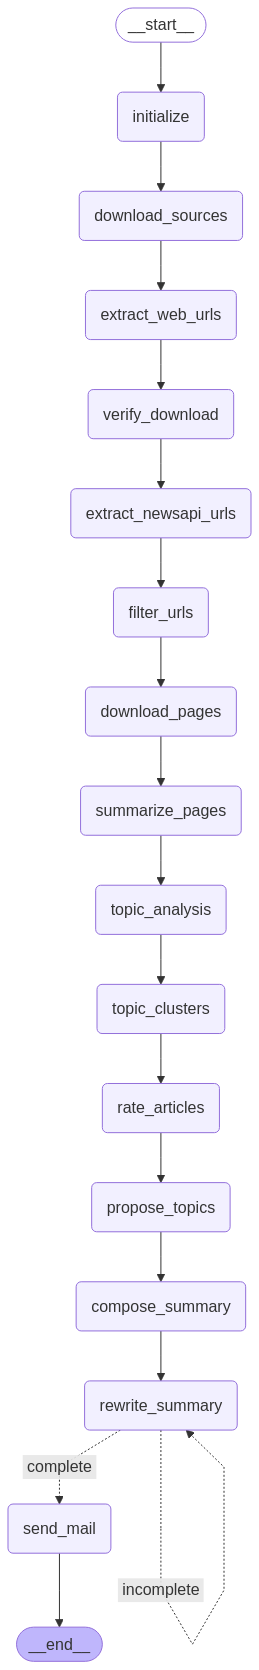

In [4]:
# same as above but w/o using native langgraph runner, run state updates sequentially
# langgraph runner does other stuff implicitly like checkpoint state in sqlite

before_date = None
# before_date = '2025-05-07 08:00'
do_download = False

ml, mm, mh = 'gpt-4.1-mini', 'gpt-4.1', 'o4-mini'
# ml, mm, mh = 'models/gemini-2.0-flash', 'models/gemini-1.5-pro-latest', 'models/gemini-2.0-flash-thinking-exp'
lg_state, lg_agent, thread_id = initialize_agent(ml,
                                                 mm,
                                                 mh,
                                                 do_download,
                                                 before_date,
                                                 max_edits=2,
                                                 n_browsers=8)

display(Image(lg_agent.graph.get_graph().draw_mermaid_png()))


In [5]:
lg_state = lg_agent.initialize_config(lg_state)


2025-05-08 19:07:13,956 - AInewsbot - INFO - Initialized 16 items in sources from sources.yaml
2025-05-08 19:07:13,957 - AInewsbot - INFO - Ars Technica -> https://arstechnica.com/ai/ -> Ars_Technica.html
2025-05-08 19:07:13,957 - AInewsbot - INFO - Bloomberg -> https://www.bloomberg.com/ai -> Bloomberg.html
2025-05-08 19:07:13,958 - AInewsbot - INFO - Business Insider -> https://www.businessinsider.com/tech -> Business_Insider.html
2025-05-08 19:07:13,958 - AInewsbot - INFO - FT -> https://www.ft.com/technology -> FT.html
2025-05-08 19:07:13,958 - AInewsbot - INFO - Feedly AI -> https://feedly.com/i/aiFeeds?options=eyJsYXllcnMiOlt7InBhcnRzIjpbeyJpZCI6Im5scC9mL3RvcGljLzMwMDAifV0sInNlYXJjaEhpbnQiOiJ0ZWNobm9sb2d5IiwidHlwZSI6Im1hdGNoZXMiLCJzYWxpZW5jZSI6ImFib3V0In1dLCJidW5kbGVzIjpbeyJ0eXBlIjoic3RyZWFtIiwiaWQiOiJ1c2VyLzYyZWViYjlmLTcxNTEtNGY5YS1hOGM3LTlhNTdiODIwNTMwOC9jYXRlZ29yeS9HYWRnZXRzIn1dfQ -> Feedly_AI.html
2025-05-08 19:07:13,959 - AInewsbot - INFO - Hacker News 1 -> https://news.ycom

In [6]:
lg_state = lg_agent.download_sources(lg_state)


2025-05-08 19:07:14,635 - AInewsbot - INFO - Web fetch disabled, using existing files in htmldata
2025-05-08 19:07:14,636 - AInewsbot - INFO - Found 16 previously downloaded files
2025-05-08 19:07:14,637 - AInewsbot - INFO - htmldata/Techmeme.html
2025-05-08 19:07:14,638 - AInewsbot - INFO - htmldata/Hacker_News_1.html
2025-05-08 19:07:14,639 - AInewsbot - INFO - htmldata/Reddit.html
2025-05-08 19:07:14,639 - AInewsbot - INFO - htmldata/HackerNoon.html
2025-05-08 19:07:14,639 - AInewsbot - INFO - htmldata/VentureBeat.html
2025-05-08 19:07:14,640 - AInewsbot - INFO - htmldata/Feedly_AI.html
2025-05-08 19:07:14,640 - AInewsbot - INFO - htmldata/The_Register.html
2025-05-08 19:07:14,641 - AInewsbot - INFO - htmldata/FT.html
2025-05-08 19:07:14,642 - AInewsbot - INFO - htmldata/Business_Insider.html
2025-05-08 19:07:14,642 - AInewsbot - INFO - htmldata/Washington_Post.html
2025-05-08 19:07:14,643 - AInewsbot - INFO - htmldata/New_York_Times.html
2025-05-08 19:07:14,643 - AInewsbot - INFO -

In [7]:
lg_state = lg_agent.extract_web_urls(lg_state)


2025-05-08 19:07:15,367 - AInewsbot - INFO - Parsing html files
2025-05-08 19:07:15,367 - AInewsbot - INFO - Ars Technica -> htmldata/Ars_Technica.html
2025-05-08 19:07:15,419 - AInewsbot - INFO - parse_file - found 174 raw links
2025-05-08 19:07:15,422 - AInewsbot - INFO - parse_file - found 35 filtered links
2025-05-08 19:07:15,422 - AInewsbot - INFO - 35 links found
2025-05-08 19:07:15,423 - AInewsbot - INFO - Bloomberg -> htmldata/Bloomberg.html
2025-05-08 19:07:15,662 - AInewsbot - INFO - parse_file - found 254 raw links
2025-05-08 19:07:15,665 - AInewsbot - INFO - parse_file - found 34 filtered links
2025-05-08 19:07:15,665 - AInewsbot - INFO - 34 links found
2025-05-08 19:07:15,665 - AInewsbot - INFO - Business Insider -> htmldata/Business_Insider.html
2025-05-08 19:07:15,684 - AInewsbot - INFO - parse_file - found 211 raw links
2025-05-08 19:07:15,688 - AInewsbot - INFO - parse_file - found 21 filtered links
2025-05-08 19:07:15,688 - AInewsbot - INFO - 21 links found
2025-05-08

In [8]:
# s/b 16 check all sources downloaded, if any got hit by a bot block then download manually

sources_downloaded = len(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
print("number of sources in AIdf", sources_downloaded)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])

sources_downloaded = len(
    pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])
SOURCES_EXPECTED = 16
missing_sources = SOURCES_EXPECTED-sources_downloaded
print("number of missing sources", missing_sources)
set(lg_state["sources"].keys()) - set(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']].index )


number of sources in AIdf 16


,id
src,
Ars Technica,34
Bloomberg,29
Business Insider,21
FT,64
Feedly AI,33
Hacker News 1,27
Hacker News 2,21
HackerNoon,12
New York Times,19


number of missing sources 0


set()

In [9]:
lg_state = lg_agent.verify_download(lg_state)


2025-05-08 19:07:19,201 - AInewsbot - INFO - verify_download passed, found 16 sources in AIdf, 0 missing


In [10]:
lg_state = lg_agent.extract_newsapi_urls(lg_state)


2025-05-08 19:07:20,277 - AInewsbot - INFO - Fetching top 100 stories matching artificial intelligence since 2025-05-07T19:07:20 from NewsAPI


In [11]:
# filter by headlines that we haven't seen and that look like AI
# we don't want to summarize all before filtering on headline
lg_state = lg_agent.filter_urls(lg_state)
display(pd.DataFrame(lg_state["AIdf"]).groupby("src").count()[['id']])


2025-05-08 19:07:21,993 - AInewsbot - INFO - Querying SQLite with where_clause: 
2025-05-08 19:07:22,657 - AInewsbot - INFO - URLs in orig_df: 890
2025-05-08 19:07:22,661 - AInewsbot - INFO - Existing URLs in DB: 256069
2025-05-08 19:07:22,731 - AInewsbot - INFO - New URLs in df filtered by URL: 280
2025-05-08 19:07:22,875 - AInewsbot - INFO - Existing src+title: 29
2025-05-08 19:07:22,876 - AInewsbot - INFO - New URLs in df filtered by src+title: 251
2025-05-08 19:07:22,891 - AInewsbot - INFO - Found 251 unique new headlines
2025-05-08 19:07:22,893 - AInewsbot - INFO - Found 244 unique cleaned new headlines
2025-05-08 19:07:28,878 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:07:29,669 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:07:29,692 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:07:29,7

,id
src,
Ars Technica,4
Bloomberg,2
Business Insider,3
FT,1
Feedly AI,23
Hacker News 1,3
Hacker News 2,3
NewsAPI,40
Reddit,4


In [13]:
lg_state = lg_agent.download_pages(lg_state)


2025-05-08 19:37:17,103 - AInewsbot - INFO - Queuing URLs for scraping
2025-05-08 19:37:17,124 - AInewsbot - INFO - Saving HTML files using async concurrency= 8
2025-05-08 19:37:17,511 - AInewsbot - INFO - Launching browser
2025-05-08 19:37:19,725 - AInewsbot - INFO - Launching workers
2025-05-08 19:37:19,726 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:19,727 - AInewsbot - INFO - from queue: 0, https://www.404media.co/i-loved-that-ai-judge-moved-by-ai-generated-avatar-of-man-killed-in-road-rage-incident/ , 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident
2025-05-08 19:37:19,728 - AInewsbot - INFO - fetch_url(https://www.404media.co/i-loved-that-ai-judge-moved-by-ai-generated-avatar-of-man-killed-in-road-rage-incident/)
2025-05-08 19:37:19,729 - AInewsbot - INFO - File already exists: htmlpages/I_Loved_That_AI___Judge_Moved_by_AI-Generated_Avatar_of_Man_Killed_in_Road_Rage_Incident.html
2025-05-08 19:37:19,729 - AInewsbot - INFO - from

2025-05-08 19:37:19,855 - AInewsbot - INFO - Skipping fetch for 15 https://www.bloomberg.com/news/articles/2025-05-08/apple-is-developing-specialized-chips-for-glasses-new-macs-and-ai-servers Apple Is Developing Specialized Chips for Glasses, New Macs and AI Servers
2025-05-08 19:37:19,855 - AInewsbot - INFO - from queue: 16, https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5 , Apple says AI is cutting into Google search. Google says that's not true. Who's right?
2025-05-08 19:37:19,856 - AInewsbot - INFO - fetch_url(https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)
2025-05-08 19:37:19,856 - AInewsbot - INFO - File already exists: htmlpages/Apple_says_AI_is_cutting_into_Google_search._Google_says_that_s_not_true._Who_s_right.html
2025-05-08 19:37:19,857 - AInewsbot - INFO - from queue: 17, https://www.businessinsider.com/google-search-apple-paid-clicks-eddy-cue-2025-5 , Apple's comments on Search gave investors one rea

2025-05-08 19:37:19,921 - AInewsbot - INFO - File already exists: htmlpages/Google_hits_back_after_Apple_exec_says_AI_is_hurting_search.html
2025-05-08 19:37:19,922 - AInewsbot - INFO - from queue: 32, https://techcrunch.com/2025/05/08/google-rolls-out-ai-tools-to-protect-chrome-users-against-scams/ , Google rolls out AI-powered defenses to help combat scams on Chrome, including the use of Gemini Nano, its on-device LLM, in Enhanced Protection mode on desktop
2025-05-08 19:37:19,922 - AInewsbot - INFO - fetch_url(https://techcrunch.com/2025/05/08/google-rolls-out-ai-tools-to-protect-chrome-users-against-scams/)
2025-05-08 19:37:19,990 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:19,991 - AInewsbot - INFO - from queue: 33, https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle , Google's Gemini 2.5 Pro Tops Coding Charts and MENSA Tests in AI IQ Battle
2025-05-08 19:37:19,991 - AInewsbot - INFO - fetch_url(https://decrypt.co/318416/googles

2025-05-08 19:37:20,118 - AInewsbot - INFO - from queue: 47, https://www.bloomberg.com/news/articles/2025-05-08/meta-taps-new-head-of-ai-lab-after-staffer-s-return-from-google , Meta Taps New Head of AI Lab After Staffers Return From Google
2025-05-08 19:37:20,120 - AInewsbot - INFO - Skipping fetch for 47 https://www.bloomberg.com/news/articles/2025-05-08/meta-taps-new-head-of-ai-lab-after-staffer-s-return-from-google Meta Taps New Head of AI Lab After Staffers Return From Google
2025-05-08 19:37:20,120 - AInewsbot - INFO - from queue: 48, https://www.theverge.com/news/663297/meta-live-ai-super-sensing-smart-glasses-facial-recognition-privacy , Metas new AI glasses could have a super-sensing mode with facial recognition
2025-05-08 19:37:20,121 - AInewsbot - INFO - fetch_url(https://www.theverge.com/news/663297/meta-live-ai-super-sensing-smart-glasses-facial-recognition-privacy)
2025-05-08 19:37:20,185 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:20,187 - AInewsbot - INFO - f

2025-05-08 19:37:20,253 - AInewsbot - INFO - fetch_url(https://financialpost.com/pmn/power-utility-transalta-expects-alberta-data-centre-deal-this-year)
2025-05-08 19:37:20,253 - AInewsbot - INFO - File already exists: htmlpages/Power_utility_TransAlta_expects_Alberta_data_centre_deal_this_year.html
2025-05-08 19:37:20,253 - AInewsbot - INFO - from queue: 64, https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-reduce-revenue-sharing-with-microsoft/ , Report: OpenAI Aims to Reduce Revenue Sharing With Microsoft
2025-05-08 19:37:20,254 - AInewsbot - INFO - fetch_url(https://www.pymnts.com/news/artificial-intelligence/2025/openai-aims-reduce-revenue-sharing-with-microsoft/)
2025-05-08 19:37:20,305 - AInewsbot - INFO - Launching worker
2025-05-08 19:37:20,306 - AInewsbot - INFO - from queue: 65, https://www.nbcnews.com/news/us-news/road-rage-victim-speaks-killers-sentencing-rcna205454 , Road rage victim 'speaks' via A.I. at his killer's sentencing
2025-05-08 19:37:20,306 -

2025-05-08 19:38:36,900 - AInewsbot - INFO - Saving HTML to htmlpages/Steelers__courtship_of_Aaron_Rodgers_is_more__complex__than_artificial_intelligence__part-owner_says.html
2025-05-08 19:38:38,948 - AInewsbot - INFO - from queue: 77, http://cacm.acm.org/opinion/thoughts-about-some-surprising-ai-era-technology-readiness-findings/ , Thoughts about Some Surprising AI-Era Technology Readiness Findings
2025-05-08 19:38:38,958 - AInewsbot - INFO - fetch_url(http://cacm.acm.org/opinion/thoughts-about-some-surprising-ai-era-technology-readiness-findings/)
2025-05-08 19:38:53,861 - AInewsbot - INFO - Saving HTML to htmlpages/SEC_filing__Sterling_Anderson__CPO_and_co-founder_of_self-driving_truck_startup_Aurora__is_resigning_effective_June_1__and_will_leave_the_board_on_August_31.html
2025-05-08 19:38:54,370 - AInewsbot - INFO - from queue: 78, https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/ , Trump admin to roll back Bidens AI chip restrictions
2025-0

2025-05-08 19:41:00,735 - AInewsbot - INFO - from queue: 92, https://blogs.nvidia.com/blog/wildfire-ai-startups/ , Wildfire Prevention: AI Startups Support Prescribed Burns, Early Alerts
2025-05-08 19:41:00,735 - AInewsbot - INFO - fetch_url(https://blogs.nvidia.com/blog/wildfire-ai-startups/)
2025-05-08 19:41:09,497 - AInewsbot - INFO - Saving HTML to htmlpages/Visa_wants_to_let_AI_make_credit_card_purchases_for_you.html
2025-05-08 19:41:10,480 - AInewsbot - INFO - from queue: 93, https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820 , Will AI decide if you get your next job? New research says it could
2025-05-08 19:41:10,480 - AInewsbot - INFO - fetch_url(https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)
2025-05-08 19:41:10,573 - AInewsbot - INFO - Saving HTML to htmlpages/U.S._AI_Leadership_Needs_Smarter_Controls.html
2025-05-08 19:41:11,143 - AInewsbot - INFO - fro

In [14]:
# summarize downloaded pages
lg_state = lg_agent.summarize_pages(lg_state)


2025-05-08 19:41:54,735 - AInewsbot - INFO - Starting summarize
2025-05-08 19:41:54,738 - AInewsbot - INFO - Fetching summaries for all articles
2025-05-08 19:41:54,744 - AInewsbot - INFO - Attempting to fetch summaries for 98 articles
2025-05-08 19:41:54,760 - AInewsbot - INFO - clean_html - Page title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident
Social card title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident
Social card description: How the sister of Christopher Pelkey made an avatar of him to testify in court.

2025-05-08 19:41:54,938 - AInewsbot - INFO - Queuing 0: Page title: 'I Loved That AI:' Judge Moved by AI-G...
2025-05-08 19:41:54,949 - AInewsbot - INFO - clean_html - Page title: A Judge Accepted AI Video Testimony From a Dead Man
Social card title: A Judge Accepted AI Video Testimony From a Dead Man
Social card description: How the sister of Christopher Pelkey made an avatar of him to

2025-05-08 19:41:55,505 - AInewsbot - INFO - Queuing 16: Page title: Apple and Google Disagree on AI Cuttin...
2025-05-08 19:41:55,530 - AInewsbot - INFO - clean_html - Page title: Google's Search Dominance Questioned As Paid Clicks Slow - Business Insider
Social card title: Apple's comments on Search gave investors one reason to worry about Google's future. Here's another.
Social card description: Apple executive Eddy Cue's revelation on Safari search decline sparked investor worry. Google's paid clicks growth also has been slowing.

2025-05-08 19:41:55,555 - AInewsbot - INFO - Queuing 17: Page title: Google's Search Dominance Questioned A...
2025-05-08 19:41:55,585 - AInewsbot - INFO - clean_html - Page title: Arm Gives Tepid Forecast, Adding to Caution From Chipmakers
Social card title: Arm Gives Tepid Forecast, Adding to Caution From Chipmakers

2025-05-08 19:41:55,630 - AInewsbot - INFO - Queuing 18: Page title: Arm Gives Tepid Forecast, Adding to Ca...
2025-05-08 19:41:55,647 - A

2025-05-08 19:41:57,370 - AInewsbot - INFO - Queuing 35: Page title: Introducing Model Router: iterate quic...
2025-05-08 19:41:57,441 - AInewsbot - INFO - clean_html - Page title: I asked AI to brutally insult each European country : r/ChatGPT

2025-05-08 19:41:57,502 - AInewsbot - INFO - Queuing 36: Page title: I asked AI to brutally insult each Eur...
2025-05-08 19:41:57,538 - AInewsbot - INFO - clean_html - Page title: I asked ChatGPT who should be the next pope — here's what AI platforms said
Social card title: I asked ChatGPT who should be the next pope — here’s what AI platforms said
Social card description: Each chatbot approached the query differently — but all shared a surprisingly common trait.

2025-05-08 19:41:57,587 - AInewsbot - INFO - Queuing 37: Page title: I asked ChatGPT who should be the next...
2025-05-08 19:41:57,935 - AInewsbot - INFO - clean_html - Page title: I tried Microsoft's free AI skills training, and you can too - for another few weeks | ZDNET
Social car

2025-05-08 19:41:58,826 - AInewsbot - INFO - Queuing 54: Page title: Nobody Codes Here Anymore - Alex Ghicu...
2025-05-08 19:41:58,845 - AInewsbot - INFO - clean_html - Page title: Nutanix brings AI to enterprise infrastructure - SiliconANGLE
Social card title: Nutanix brings AI to enterprise infrastructure - SiliconANGLE
Social card description: Nutanix leaders discuss how AI is moving from lab to production by simplifying deployment, enabling governance, and powering enterprise infrastructure.

2025-05-08 19:41:58,868 - AInewsbot - INFO - Queuing 55: Page title: Nutanix brings AI to enterprise infras...
2025-05-08 19:41:58,877 - AInewsbot - INFO - clean_html - Page title: OpenAI offers to help countries build AI systems - Japan Today
Social card title: OpenAI offers to help countries build AI systems
Social card description: OpenAI on Wednesday announced an initiative to help countries build their own artificial intelligence (AI) infrastructures, with the U.S. government a partner in

2025-05-08 19:41:59,458 - AInewsbot - INFO - Queuing 71: Page title: Student Survey on AI in Game Developme...
2025-05-08 19:41:59,493 - AInewsbot - INFO - clean_html - Page title: Studio Blo appoints Shekhar Kapur as chairperson of board of AI ethics - The Economic Times
Social card title: Studio Blo appoints Shekhar Kapur as chairperson of board of AI ethics
Social card description: Shekhar Kapur has been appointed as the Chairperson of the Board of AI Ethics & Creative Stewardship at Studio Blo. He will guide the studio's work at the intersection of AI, storytelling, and ethical content creation. Kapur's experience will help Studio Blo use AI responsibly and explore new approaches to filmmaking, potentially creating a new genre of AI films.

2025-05-08 19:41:59,528 - AInewsbot - INFO - Queuing 72: Page title: Studio Blo appoints Shekhar Kapur as c...
2025-05-08 19:41:59,596 - AInewsbot - INFO - clean_html - Page title: Symbiosis International (Deemed University) launches Symbiosis A

2025-05-08 19:42:00,596 - AInewsbot - INFO - Queuing 87: Page title: iPhone Upgrades Weren't Sparked by AI....
2025-05-08 19:42:00,622 - AInewsbot - INFO - clean_html - Page title: Want Trustworthy AI? Put It on the Blockchain  | HackerNoon
Social card title: Want Trustworthy AI? Put It on the Blockchain  | HackerNoon
Social card description: Tired of AI’s black box? Discover how Aleph cloud uses blockchain to build a transparent, decentralized future for AI, data privacy, and digital freedom.

2025-05-08 19:42:00,667 - AInewsbot - INFO - Queuing 88: Page title: Want Trustworthy AI? Put It on the Blo...
2025-05-08 19:42:00,828 - AInewsbot - INFO - clean_html - Page title: Watch: OpenAI CEO Sam Altman, other executives give opening statements at Senate AI hearing - CBS News
Social card title: Watch: OpenAI CEO Sam Altman, other executives give opening statements at Senate AI hearing
Social card description: OpenAI CEO Sam Altman testified before a Senate committee on Thursday alongside 

async_langchain: 0, {'article': "Page title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident\nSocial card title: 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident\nSocial card description: How the sister of Christopher Pelkey made an avatar of him to testify in court.\nAn AI avatar made to look and sound like the likeness of a man who was killed in a road rage incident addressed the court and the man who killed him: “To Gabriel Horcasitas, the man who shot me, it is a shame we encountered each other that day in those circumstances,” the AI avatar of Christopher Pelkey said. “In another life we probably could have been friends. I believe in forgiveness and a God who forgives. I still do.”\nIt was the first time the AI avatar of a victim—in this case, a dead man—has ever addressed a court, and it raises many questions about the use of this type of technology in future court proceedings.\nThe avatar was made

2025-05-08 19:42:02,486 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,525 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,537 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:02,602 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 51 response: no content
async_langchain: 81 response: no content
async_langchain: 63 response: no content
async_langchain: 23 response: no content
async_langchain: 68 response: no content


2025-05-08 19:42:02,771 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 61 response: no content


2025-05-08 19:42:03,250 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,271 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 89 response: • OpenAI CEO Sam Altman, Advanced Micro Devices CEO Dr. Lisa Su, CoreWeave CEO Michael Intrator, and Microsoft Vice Chair and President Brad Smith delivered opening statements before a Senate committee on Thursday during a hearing focused on the race for artificial intelligence.
async_langchain: 26 response: • CrowdStrike announced it will lay off 500 employees, approximately 5% of its workforce, citing advances in artificial intelligence as a driving factor.
• CEO George Kurtz stated, "AI has always been foundational to how we operate," emphasizing that AI is "reshaping every industry."


2025-05-08 19:42:03,490 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,613 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,619 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:03,680 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 6 response: • Artificial intelligence systems have achieved highly accurate reconstructions of images based on brain activity recordings, significantly improving when the AI focuses on specific brain regions.
• Researcher Umut Güçlü from Radboud University in the Netherlands stated, "As far as I know, these are the closest, most accurate reconstructions."
async_langchain: 80 response: • The Trump administration plans to rescind Biden-era export restrictions on AI chips, which it characterized as “overly complex,” according to a Commerce Department spokesperson.
• The spokesperson stated the restrictions will be replaced with a “much simpler rule that unleashes American innovation and ensures American AI dominance.”
async_langchain: 71 response: • A Bachelor student at Ecole Schulz in Geneva is conducting a project on Artificial Intelligence in the videogame industry and is seeking anonymous survey responses from developers who have worked on commercially available vide

2025-05-08 19:42:04,072 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,080 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,211 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,218 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,224 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,277 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,279 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 97 response: • Google launched a dedicated Gemini AI app for iPad on Wednesday, offering features optimized for the tablet, including Split View for multitasking.
• The app is available in all countries where Google Gemini is offered and can be downloaded from the App Store.
• Google has also rolled out Gemini home screen widgets for iPhone and iPad users, giving quick access to features like the camera, file sharing, Gemini Live conversations, and a direct text box for queries.
async_langchain: 72 response: • Studio Blo has appointed internationally recognized filmmaker Shekhar Kapur as Chairperson of its Board of AI Ethics & Creative Stewardship, where he will guide the studio's efforts at the intersection of AI, storytelling, and ethical content creation. 
• Kapur stated, “AI is not here to replicate the past—it’s here to create new forms of cinematic expression,” and expressed that AI films could become a genre of their own.
• Studio Blo is known for integrating tr

2025-05-08 19:42:04,289 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,310 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,437 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 29 response: • Google has released a dedicated Gemini app for iPad, offering a full-featured interface that takes advantage of the tablet’s larger screen and multitasking capabilities, addressing prior limitations of only using the iPhone app in compatibility mode.
• The new app supports features such as natural conversation via Gemini Live, image and video generation, photo and document analysis, Deep Research, Canvas mode for collaborative editing, and the Audio Overview tool to create AI-hosted podcasts in over 45 languages.
async_langchain: 79 response: • The Trump administration plans to rescind Biden-era restrictions on the export of advanced artificial intelligence chips, according to a spokesperson for the U.S. Department of Commerce.
• The export curbs in question relate to the Framework for Artificial Intelligence Diffusion, though no further details on implementation or timeline were provided.
async_langchain: 53 response: • Minister Jack Chambers has launch

2025-05-08 19:42:04,589 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,591 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,592 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,599 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,603 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,604 - httpx 

async_langchain: 78 response: • The Trump administration announced plans to rescind and replace a Biden-era rule that regulated the export of high-end AI accelerator chips, calling the previous framework "overly complex, overly bureaucratic, and would stymie American innovation."  
• The regulation, known as the Framework for Artificial Intelligence Diffusion, was issued in January during the final week of the Biden administration to restrict global access to advanced AI chips, especially targeting China's military capabilities.
• Following news of the policy change, Nvidia shares rose 3 percent, reflecting immediate market impacts.
async_langchain: 5 response: • OpenAI CEO Sam Altman told a Senate hearing that requiring government approval to release advanced AI software would be “disastrous” for the U.S.’s technological lead, signaling a shift away from earlier calls for strong government regulation.
• The testimony highlights a broader change in the tech industry’s approach to AI ri

2025-05-08 19:42:04,850 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,868 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,870 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,909 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,916 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,941 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:04,943 - httpx 

async_langchain: 8 response: • A new Duke University study published in the Proceedings of the National Academy of Sciences finds that employees who use AI tools like ChatGPT, Claude, and Gemini at work face negative stereotypes about competence and motivation from both colleagues and managers.
• Researchers conducted four experiments with over 4,400 participants and found a consistent pattern of bias against AI users, reporting expectations and actual judgments of them being lazier, less competent, less diligent, and more replaceable compared to users of conventional tools.
• The study reveals that the social stigma against using AI tools is widespread and not influenced by the user’s age, gender, or occupation, suggesting a general penalty for AI use regardless of demographic factors.
async_langchain: 19 response: • Arm Holdings provided a cautious sales forecast for the fiscal first quarter, projecting revenue of $1 billion to $1.1 billion and profit of 30 to 38 cents per share, bot

2025-05-08 19:42:05,046 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,049 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,089 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,124 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,125 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,172 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,204 - httpx 

async_langchain: 65 response: • Gabriel Paul Horcasitas was sentenced to the maximum 10½ years in prison for the 2021 fatal road-rage shooting of Christopher Pelkey, after a Maricopa County judge allowed an AI-generated recreation of Pelkey to deliver a victim impact statement at sentencing.
• The AI presentation, created at the request of Pelkey's family, featured a lifelike version of Pelkey's face, body, and voice, and reportedly included a statement of forgiveness directed toward Horcasitas.
• Horcasitas’ attorney called the AI statement "inflammatory" and cited it as grounds for appeal, raising questions among legal and ethics experts about the use of AI-generated victim testimony in court.
async_langchain: 45 response: • French AI chip startup VSORA has raised $46 million in funding, led by Otium and several European backers, to develop its Jotunn8 inference processor as an alternative to Nvidia and other global AI chip giants.  
• VSORA claims the Jotunn8 chip, targeting inferen

2025-05-08 19:42:05,326 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,378 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,389 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,402 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,444 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,473 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,507 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 96 response: • The 9th Workshop on Advances in Argumentation in Artificial Intelligence (AI³ 2025) is calling for paper submissions for its event scheduled on September 12 or 13, 2025, in Rende, Italy, co-located with the 41st International Conference on Logic Programming at the University of Calabria.
• Submissions are invited on topics including computational argumentation, explainable AI, persuasion systems, argument mining, and applications in multi-agent systems, with deadlines for paper registration on July 1 and submission on July 8, 2025; accepted papers will be published in the CEUR AI*IA Series (Scopus indexed).
• The workshop aims to foster discussion and collaboration across research areas related to argumentation in artificial intelligence, and offers multiple submission categories: full papers, short papers, and research overviews.
async_langchain: 93 response: • New research from Dr. Natalie Sheard at the University of Melbourne finds that AI hiring syst

2025-05-08 19:42:05,604 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,618 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,677 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,686 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,688 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,727 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 91 response: • The article explains that large language models (LLMs) display "emergent" behaviors—suddenly acquiring new capabilities—when their parameter count surpasses a critical threshold, drawing analogies to abrupt changes in nature, machine learning tasks, and logical circuits.
• It describes emergence as a consequence of allocating enough parameters in LLMs to accurately represent specific algorithms or tasks, resulting in a sudden jump in capability as seen in other complex systems.
• The article notes that predicting exactly when new capabilities will emerge in LLMs is challenging due to the complexity of training data, parameter budgets, and algorithmic discovery, but such emergent properties are not inherently surprising given the structure of LLMs.
async_langchain: 39 response: • LinkedIn has introduced new AI-powered features for job seekers, including an AI chatbot for mock interviews, enhanced natural language job search, and a job match scale that rat

2025-05-08 19:42:05,937 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,951 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:05,963 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,021 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,034 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 74 response: • AI Coffee, a new coffee shop on High Street featuring the Espressix ProtoSip prototype coffee machine, opened this Monday and quickly gained popularity due to social media attention and press coverage, resulting in high customer turnout and operational challenges.

• The shop's unique appeal centers on the use of a programmable coffee machine controlled by Python functions, which allowed for advanced customization of drinks; the machine's API and Alex's background as a programmer enabled rapid adaptation to customer requests.

• The Espressix ProtoSip, developed by a startup with ties to the shop's owner, lacks a traditional user interface and is operated via Python scripts, providing a practical framework to demonstrate advanced Python function features such as parameters, positional and keyword arguments, *args and **kwargs, default values, and both positional-only and keyword-only syntax.

• Despite the shop's name, Alex clarified that "AI Coffee" ref

2025-05-08 19:42:06,248 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,372 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 24 response: • Increasing use of AI is automating entry-level jobs across industries, resulting in fewer opportunities for junior workers to gain foundational skills and mentorship, with surveys and reports showing significant job displacement and transformation (e.g., DBS Group job cuts, ResumeBuilder and Goldman Sachs reports).

• The loss of ground-level roles threatens the development of both technical competence and soft skills among new workers, creating a "competence gap" and potentially disadvantaging those from less privileged backgrounds, as highlighted by rising expectations for pre-existing experience and a 2024 National Youth Council survey noting 68% of Singaporean youths see internships as essential for entry-level positions.

• The commentary proposes a national apprenticeship scheme—modeled on successful examples from Germany and Singapore's own SkillsFuture—to provide structured, mentored, AI-augmented training for new entrants, emphasizing the need f

2025-05-08 19:42:06,470 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,484 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,534 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:06,622 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 54 response: • Alex Ghiculescu reports on rolling out AI coding assistants Cursor and Claude Code to a team of 40 developers working on a mature Ruby on Rails SaaS product, finding that 20% productivity gains are possible when these tools are well integrated into workflows.

• Developers vary in adoption, with some using agents for most tasks and others alternating based on task type; agents are praised for enabling rapid development, tackling ambitious projects, understanding unfamiliar codebases, and quickly refactoring or completing routine tasks, but challenges remain around coding style, correct bug fixes, and overuse of comments.

• No company-wide mandate was issued to use AI agents, but many team members organically adopted them due to evident productivity benefits and the evolving quality of AI tools, prompting changes to make the codebase more "AI friendly" and facilitating easier agent use in daily development.
async_langchain: 57 response: • Instacart CEO F

2025-05-08 19:42:07,141 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 82 response: • The U.S. is reassessing its AI export controls after China’s DeepSeek-R1 model highlighted the urgency to restrict China’s access to advanced AI technologies, with calls to enhance R&D, foster domestic innovation, and strengthen international collaborations rooted in democratic values.
• The Biden administration’s 2024 Framework for Artificial Intelligence Diffusion Interim Final Rule (IFR) restricts AI chip exports to China and other countries, but has faced criticism from U.S. allies and industry leaders for potentially fracturing alliances and incentivizing the adoption of Chinese AI technology.
• Lawmakers and experts, including former Google CEO Eric Schmidt, warn that China’s technological gap is narrowing and urge policies that balance security with market competitiveness, enforceable norms, and open governance, rather than blanket restrictions that may harm U.S. leadership and partnerships.
• China has retaliated against U.S. controls by increasi

2025-05-08 19:42:07,639 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 94 response: • New research using computational protein design tools, like RFDiffusion from the Baker Lab, has enabled the creation of synthetic proteins that can bind to specific snake venom components, showing protective effects in mice and offering a new approach to antivenom development.

• Snake venom’s extreme heterogeneity—varying between families, species, geographic regions, populations, and even an individual snake's age—makes traditional antivenom production expensive, technically challenging, and economically unattractive, especially for markets in lower-income regions.

• Recent breakthroughs, including the identification and engineering of broadly neutralizing antibodies (some derived from a 'hyperimmune' individual and phage display methods), raise the prospect of near-universal antivenoms that could work against a wide variety of snake venoms, but broader problems remain: “A perfect computationally-designed antivenom doesn’t guarantee market incentives.

2025-05-08 19:42:09,614 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:09,629 - AInewsbot - INFO - Received 95 summaries
2025-05-08 19:42:09,629 - AInewsbot - INFO - Summary for 0 (length 1149): • An AI-generated avatar of Christopher Pelkey, who was killed in a road rage incident, addressed the court and the shooter, Gabriel Horcasitas, during court proceedings, marking the first time an AI avatar of a deceased victim has spoken in court.
• The avatar, created by Pelkey’s sister Stacey Wales, expressed sentiments of forgiveness: “To Gabriel Horcasitas, the man who shot me, it is a shame we encountered each other that day in those circumstances... In another life we probably could have been friends. I believe in forgiveness and a God who forgives. I still do.”
• The unprecedented use of an AI victim avatar in court raises questions about the future use of this technology in legal proceedings.
2025-05-08 19:42:09,630 - A

2025-05-08 19:42:09,635 - AInewsbot - INFO - Summary for 11 (length 5559): • Alibaba researchers have introduced "ZeroSearch," a reinforcement learning framework that enables large language models (LLMs) to simulate advanced search capabilities without relying on external search engine APIs, reducing training costs by up to 88%.

• In tests across seven question-answering datasets, models trained using ZeroSearch matched or outperformed those trained with real search engines, with a 14B-parameter simulation LLM surpassing Google Search performance while costing only $70.80 compared to $586.70 for API-based training.

• The technique gives developers greater control over training data and eliminates unpredictable document quality from search engines, and Alibaba has released associated code, datasets, and models on GitHub and Hugging Face for broader industry use.
2025-05-08 19:42:09,635 - AInewsbot - INFO - Summary for 12 (length 9459): • Anthropic has launched a web search API for its

2025-05-08 19:42:09,638 - AInewsbot - INFO - Summary for 22 (length 1675): • Users report that ChatGPT displays unrelated or incorrect information—such as random receipts—when analyzing uploaded images, including sleep activity pictures, raising concerns about AI hallucinations and image processing errors.
• Community members suggest these issues may be due to AI image processing failures, potential hash conflicts, or hallucinations, and recommend reporting such incidents for further investigation.
• Multiple similar reports have surfaced in the past two weeks, highlighting a possible uptick in the frequency of these errors.
2025-05-08 19:42:09,639 - AInewsbot - INFO - Summary for 23 (length 28): no content
2025-05-08 19:42:09,639 - AInewsbot - INFO - Summary for 24 (length 7880): • Increasing use of AI is automating entry-level jobs across industries, resulting in fewer opportunities for junior workers to gain foundational skills and mentorship, with surveys and reports showing signif

2025-05-08 19:42:09,645 - AInewsbot - INFO - Summary for 35 (length 8143): • Hypermode has launched Model Router, a new feature providing developers with a unified API to access both open-source and commercial AI language and embedding models, enabling seamless switching and orchestration between models.

• Model Router offers functionalities such as cost and performance optimization, automatic fallback, load balancing, customizable model preferences, and support for security and compliance requirements, reducing complexity and maintenance in AI model integration.

• The tool is compatible with popular SDKs including the OpenAI SDK and Vercel AI SDK, and aims to help developers and enterprises iterate quickly, optimize costs, and avoid lock-in to single model providers.
2025-05-08 19:42:09,646 - AInewsbot - INFO - Summary for 36 (length 2712): • A Reddit user shared their experience asking AI (presumably ChatGPT) to "brutally insult" various European countries, resulting in humorous, s

2025-05-08 19:42:09,647 - AInewsbot - INFO - Summary for 46 (length 10345): • Meta CEO Mark Zuckerberg suggested in a podcast interview that AI "friends," including AI girlfriends and therapists, could help address the loneliness crisis by fulfilling people's need for more meaningful companionships, noting that Americans on average have fewer friends than desired.

• Experts and commentators responded with skepticism and concern, citing Meta's history with issues around mental health and privacy, as well as risks such as AI chatbots engaging in inappropriate conversations or collecting sensitive user data without adequate safeguards.

• Some research supports that AI companions can significantly reduce feelings of loneliness in the short term, but experts caution about long-term impacts and emphasize that AI friendships lack the depth, unpredictability, and personal growth offered by real human interactions, raising ethical and societal questions about reliance on technology to solve e

2025-05-08 19:42:09,649 - AInewsbot - INFO - Summary for 58 (length 1897): • OpenAI has hired Fidji Simo, current CEO of Instacart and former head of the Facebook app, as head of its apps business; she will remain CEO of Instacart for the next couple of months until a successor is named.

• OpenAI CEO Sam Altman stated that Simo’s new role will allow him to “focus on research, compute, and safety.”

• Simo, who joined Facebook in 2011 and became head of the Facebook app in 2019, has been an OpenAI board member since last year and led Instacart through its public offering.
2025-05-08 19:42:09,649 - AInewsbot - INFO - Summary for 59 (length 8405): • OpenAI has appointed Fidji Simo, currently CEO and Chair of Instacart, as its new CEO of Applications, a newly established executive role; Simo will join OpenAI in 2025 after a transition period and will lead the division responsible for turning AI research into consumer and business products.

• CEO Sam Altman stated he will remain CEO of Op

2025-05-08 19:42:09,652 - AInewsbot - INFO - Summary for 71 (length 1346): • A Bachelor student at Ecole Schulz in Geneva is conducting a project on Artificial Intelligence in the videogame industry and is seeking anonymous survey responses from developers who have worked on commercially available videogames; interested participants are asked to contact lghettiedu@gmail.com to receive the survey link.
2025-05-08 19:42:09,652 - AInewsbot - INFO - Summary for 72 (length 1955): • Studio Blo has appointed internationally recognized filmmaker Shekhar Kapur as Chairperson of its Board of AI Ethics & Creative Stewardship, where he will guide the studio's efforts at the intersection of AI, storytelling, and ethical content creation. 
• Kapur stated, “AI is not here to replicate the past—it’s here to create new forms of cinematic expression,” and expressed that AI films could become a genre of their own.
• Studio Blo is known for integrating traditional filmmaking with AI-driven tools, working 

2025-05-08 19:42:09,654 - AInewsbot - INFO - Summary for 83 (length 3605): • A report from the Institute for Public Policy Research (IPPR) found that only 15% of UK AI companies focus on solving specific societal problems, with the majority providing generic solutions rather than addressing key issues like public health or sustainable transport.
• Despite one in five AI companies benefiting from public funds, most are not directly contributing to the public good; the report advises the government to use procurement and grant-making powers to steer the industry toward more purposeful innovation.
• Recommendations include establishing a government AI Tracking Unit, targeting funding to problem-solving AI firms, and using government procurement to support breakthrough innovations that address societal needs.
2025-05-08 19:42:09,654 - AInewsbot - INFO - Summary for 84 (length 2487): • Researchers have identified the origin of excitation-independent visible photoluminescence in crystalline 

2025-05-08 19:42:09,657 - AInewsbot - INFO - Summary for 94 (length 32773): • New research using computational protein design tools, like RFDiffusion from the Baker Lab, has enabled the creation of synthetic proteins that can bind to specific snake venom components, showing protective effects in mice and offering a new approach to antivenom development.

• Snake venom’s extreme heterogeneity—varying between families, species, geographic regions, populations, and even an individual snake's age—makes traditional antivenom production expensive, technically challenging, and economically unattractive, especially for markets in lower-income regions.

• Recent breakthroughs, including the identification and engineering of broadly neutralizing antibodies (some derived from a 'hyperimmune' individual and phage display methods), raise the prospect of near-universal antivenoms that could work against a wide variety of snake venoms, but broader problems remain: “A perfect computationally-designed 

async_langchain: 21 response: • SPLADE (Sparse Lexical and Expansion Model for First Stage Ranking) is introduced as a method to combine the transparency and simplicity of keyword search with the meaning-matching abilities of semantic search, addressing limitations in both traditional keyword and modern vector-based search systems.

• In a practical experiment on a database of superhero descriptions, using SPLADE to inject synthetic tokens into search indexes improved recall@3 from 28% to 52%, demonstrating a significant boost in the ability to retrieve relevant results based on non-exact matches.

• The blog notes that while SPLADE improves recall, implementing it in Elasticsearch as described does not consider token weights for precision, and highlights ongoing challenges such as occasional irrelevant synthetic tokens and the complexity of tuning semantic search models.


In [15]:
# extract topics from summaries
# AI prompt to free-form ask what topics are covered
# followed by a series of structured AI prompts to ask if popular topics are covered
# use gpt-4o mini always, google flash 2.0 has a problem with this for some reason, get pydantic validation errors
# not sure why it works for summarize and filter but not here
# tested query in AI studio and it works, works with json parser but not structured output
lg_state = lg_agent.topic_analysis(lg_state, model_str='gpt-4o-mini')


2025-05-08 19:42:09,711 - AInewsbot - INFO - start free-form topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:42:18,627 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:19,041 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:19,213 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:19,823 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:21,373 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:21,382 - AInewsbot - INFO - 98 free-form topics extracted
2025-05-08 19:42:21,384 - AInewsbot - INFO - Starting assigned topic extraction using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:42:21,385 - AInewsbot - IN

2025-05-08 19:42:21,448 - AInewsbot - INFO - Canonical topic taiwan
2025-05-08 19:42:21,448 - AInewsbot - INFO - Canonical topic russia
2025-05-08 19:42:21,450 - AInewsbot - INFO - Canonical topic authors & writing
2025-05-08 19:42:21,451 - AInewsbot - INFO - Canonical topic infrastructure
2025-05-08 19:42:21,452 - AInewsbot - INFO - Canonical topic legal issues
2025-05-08 19:42:21,452 - AInewsbot - INFO - Canonical topic smart grid
2025-05-08 19:42:21,453 - AInewsbot - INFO - Canonical topic nuclear
2025-05-08 19:42:21,453 - AInewsbot - INFO - Canonical topic governance
2025-05-08 19:42:21,454 - AInewsbot - INFO - Canonical topic hardware
2025-05-08 19:42:21,454 - AInewsbot - INFO - Canonical topic stocks
2025-05-08 19:42:21,455 - AInewsbot - INFO - Canonical topic food & drink
2025-05-08 19:42:21,455 - AInewsbot - INFO - Canonical topic quantum computing
2025-05-08 19:42:21,455 - AInewsbot - INFO - Canonical topic scams
2025-05-08 19:42:21,456 - AInewsbot - INFO - Canonical topic ai 

2025-05-08 19:42:28,120 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,127 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,130 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,133 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,138 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,139 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,144 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,154 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,156 - httpx 

2025-05-08 19:42:28,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,424 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,428 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,456 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,459 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,465 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,469 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,476 - httpx 

2025-05-08 19:42:28,836 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,842 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,843 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,844 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,856 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,858 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,859 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:28,864 - httpx 

2025-05-08 19:42:29,087 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,088 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,093 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,096 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,100 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,103 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,109 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,112 - httpx 

2025-05-08 19:42:29,280 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,281 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,283 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,286 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,288 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,290 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,291 - httpx 

2025-05-08 19:42:29,531 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,532 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,533 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,538 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,547 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,550 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,555 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,560 - httpx 

2025-05-08 19:42:29,794 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,796 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,801 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,804 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,805 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,811 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,812 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,826 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:29,827 - httpx 

2025-05-08 19:42:30,168 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,169 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,178 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,181 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,185 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,198 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,199 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,209 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,220 - httpx 

2025-05-08 19:42:30,667 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,701 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,710 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,724 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,730 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,731 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,748 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,749 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:30,768 - httpx 

2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 27: ### <<<ARTICLE SUMMARY>>>
# Exhibit your startup a...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 28: ### <<<ARTICLE SUMMARY>>>
# Fidji Simo joins OpenA...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 29: ### <<<ARTICLE SUMMARY>>>
# Google Gemini gets an ...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 30: ### <<<ARTICLE SUMMARY>>>
# Google Launches New AI...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 31: ### <<<ARTICLE SUMMARY>>>
# Google hits back after...
2025-05-08 19:42:37,746 - AInewsbot - INFO - Queuing 32: ### <<<ARTICLE SUMMARY>>>
# Google rolls out AI-po...
2025-05-08 19:42:37,747 - AInewsbot - INFO - Queuing 33: ### <<<ARTICLE SUMMARY>>>
# Google's Gemini 2.5 Pr...
2025-05-08 19:42:37,747 - AInewsbot - INFO - Queuing 34: ### <<<ARTICLE SUMMARY>>>
# How we're using AI to ...
2025-05-08 19:42:37,747 - AInewsbot - INFO - Queuing 35: ### <<<ARTICLE SUMMARY>>>
# Hypermode Model Router...
2

async_langchain: 0, {'input_text': "### <<<ARTICLE SUMMARY>>>\n# 'I Loved That AI:' Judge Moved by AI-Generated Avatar of Man Killed in Road Rage Incident\n\n• An AI-generated avatar of Christopher Pelkey, who was killed in a road rage incident, addressed the court and the shooter, Gabriel Horcasitas, during court proceedings, marking the first time an AI avatar of a deceased victim has spoken in court.\n• The avatar, created by Pelkey’s sister Stacey Wales, expressed sentiments of forgiveness: “To Gabriel Horcasitas, the man who shot me, it is a shame we encountered each other that day in those circumstances... In another life we probably could have been friends. I believe in forgiveness and a God who forgives. I still do.”\n• The unprecedented use of an AI victim avatar in court raises questions about the future use of this technology in legal proceedings.\n### <<<END>>>\n### <<<CANDIDATE TOPICS>>>\nAI In Legal Proceedings, AI Integration, AI Regulation, AI Technology, AI Tools, AI-G

2025-05-08 19:42:38,690 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,753 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,763 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,772 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,787 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,810 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,834 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,838 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,850 - httpx 

async_langchain: 23 response: items=[]
async_langchain: 15 response: items=[]
async_langchain: 0 response: items=['AI In Legal Proceedings', 'AI-Generated Avatars', 'Forgiveness', 'Legal Ethics', 'Victim Impact Statements']
async_langchain: 47 response: items=[]
async_langchain: 44 response: items=[]
async_langchain: 81 response: items=[]
async_langchain: 51 response: items=[]
async_langchain: 63 response: items=[]
async_langchain: 61 response: items=[]
async_langchain: 68 response: items=[]
async_langchain: 14 response: items=['Finance', 'Fintech', 'Economics', 'Customer Service']


2025-05-08 19:42:38,986 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:38,996 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,003 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,013 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,016 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,022 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,024 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,030 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,031 - httpx 

async_langchain: 38 response: items=['Certification Opportunities', 'Free Training', 'Microsoft AI Skills Fest', 'Skill Development', 'Online Education']
async_langchain: 19 response: items=['Arm Forecast', 'Chipmaker Caution', 'Financial Outlook', 'Licensing Deals', 'Semiconductor Chips', 'AI Business']
async_langchain: 18 response: items=['Arm Holdings', 'Chip Market Forecast', 'Financial Performance', 'Licensing Agreements', 'AI Investments']
async_langchain: 26 response: items=['AI Impact On Employment', 'CrowdStrike', 'Industry Transformation', 'Job Cuts']
async_langchain: 13 response: items=['Apple Smart Glasses', 'Chip Development', 'Energy Efficiency', 'Integrated AI Features', 'Meta Competition', 'Augmented Reality']
async_langchain: 87 response: items=['Consumer Behavior', 'Iphone Upgrades', 'Market Response', 'Trump Tariffs']
async_langchain: 10 response: items=['AI In Courtroom Settings', 'Legal Ethics', 'Ethical Concerns', 'Victim Statements', 'AI Tools']
async_langchain: 

2025-05-08 19:42:39,240 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,246 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,257 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,262 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,267 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,269 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,284 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,293 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,298 - httpx 

async_langchain: 40 response: items=['AI Integration', 'Enforcement Workforce Changes', 'Operational Efficiency', 'Tax Collection', 'Job Automation']
async_langchain: 4 response: items=['AI And Human Discernment', 'AI Reliance', 'Cognitive Outsourcing', 'Critical Thinking', 'Ethical Concerns']
async_langchain: 72 response: items=['AI Ethics', 'AI In Film', 'Creative Storytelling', 'Entertainment', 'Shekhar Kapur', 'Studio Blo']
async_langchain: 50 response: items=['AI Model Compression', 'CB Insights Recognition', 'Energy Efficiency', 'Funding', 'Quantum-Inspired Technology', 'Multiverse Computing']
async_langchain: 52 response: items=['AI Technology', 'Animal Communication', 'Baidu AI Technology', 'Human-Animal Interaction', 'Patent Application', 'Machine Learning']
async_langchain: 69 response: items=['AI and Religious Liberty', 'AI Surveillance', 'Ethical AI', 'Religious Communities', 'Faith@Work ERG Conference', 'AI Integration']
async_langchain: 86 response: items=['AI In Personal

2025-05-08 19:42:39,466 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,481 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,491 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,570 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,577 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,643 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 90 response: items=['AI Scams', 'Blockchain Verification', 'Cybersecurity', 'Digital Security', 'Fraud Detection', 'Public Education']
async_langchain: 82 response: items=['AI Chip Regulations', 'AI Competition', 'AI Policy', 'Biden Administration', 'China', 'U.S. AI Export Controls', 'Democratic Values']
async_langchain: 56 response: items=['AI Infrastructure Support', 'OpenAI for Countries Initiative', 'Localization of ChatGPT', 'Investment in AI', 'Healthcare', 'Education', 'Governance']
async_langchain: 91 response: items=['Emergent Properties', 'Language Models', 'Parameter Count', 'Machine Learning', 'Training Data Complexity']
async_langchain: 46 response: items=['AI Companionship', 'Ethical Concerns', 'Loneliness Crisis', 'Privacy & Surveillance', "Zuckerberg's Proposal"]
async_langchain: 33 response: items=['AI Performance', 'Google Gemini 2.5 Pro', 'Coding Benchmarks', 'Intelligence Testing', 'AI Competition']
async_langchain: 55 response: items=['AI Integrat

2025-05-08 19:42:39,757 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,827 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,914 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:39,947 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


async_langchain: 16 response: items=['AI Impact on Search', 'Apple Google Antitrust Trial', 'Search Dominance', 'Technology Competition', 'Stocks']
async_langchain: 85 response: items=['AI Support for Trauma Survivors', 'Content Filter Issues', 'App Disruptions', 'Google Gemini', 'Ethical Concerns', 'Model Performance']
async_langchain: 42 response: items=['Disney Family Reactions', 'Ethical Concerns', 'Imagineers', 'Theme Park Innovation', 'Walt Disney Animatronic']
async_langchain: 71 response: items=['AI in Video Games', 'Game Development', 'Developer Survey', 'Student Project', 'Ecole Schulz']


2025-05-08 19:42:40,018 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:40,048 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:40,052 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:40,072 - AInewsbot - INFO - Received 98 responses
2025-05-08 19:42:40,076 - AInewsbot - INFO - End topic analysis


async_langchain: 65 response: items=['AI-Generated Victim Testimony', 'Legal Ethics', 'Ethical Concerns', 'Road Rage Sentencing', 'Victim Impact Statement']
async_langchain: 73 response: items=['AI Institute', 'AI Integration', 'Education And Research', 'Interdisciplinary Programs', 'Responsible Innovation', 'Fintech', 'Health & Fitness']
async_langchain: 75 response: items=['Legal Challenges', 'Online Safety Act', 'Volunteer Editor Safety', 'Data Privacy', 'Wikimedia Foundation', 'Policy And Regulation', 'Uk']


In [ ]:
lg_state = lg_agent.topic_clusters(lg_state)


In [17]:
lg_state = lg_agent.rate_articles(lg_state)
aidf = pd.DataFrame(lg_state["AIdf"])
aidf


2025-05-08 19:42:50,431 - AInewsbot - INFO - Calculating article rating for 98 articles
2025-05-08 19:42:50,433 - AInewsbot - INFO - Starting low_quality filter
2025-05-08 19:42:57,331 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:58,274 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:42:58,288 - AInewsbot - INFO - low quality articles: {0: 88, 1: 10}
2025-05-08 19:42:58,289 - AInewsbot - INFO - Starting on_topic filter
2025-05-08 19:43:02,403 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:43:03,170 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:43:03,180 - AInewsbot - INFO - on topic articles: {1: 80, 0: 18}
2025-05-08 19:43:03,181 - AInewsbot - INFO - Starting importance filter
2025-05-08 19:43:10,647 - httpx - INFO - HTTP Reques

,id,url,src,title,isAI,actual_url,hostname,site_name,reputation,path,...,title_topic_str,bullet,sort_order,cluster,cluster_name,low_quality,on_topic,importance,adjusted_len,rating
0,0,https://www.nbcnews.com/news/us-news/road-rage...,NewsAPI,Road rage victim 'speaks' via A.I. at his kill...,True,https://www.nbcnews.com/news/us-news/road-rage...,www.nbcnews.com,NBC News,1,htmlpages/Road_rage_victim__speaks__via_A.I._a...,...,Road rage victim 'speaks' via A.I. at his kill...,[Road rage victim 'speaks' via A.I. at his kil...,0,0,AI Testimony in Road Rage Trial,0,1,1,1.668945,4.668945
1,1,https://www.404media.co/i-loved-that-ai-judge-...,Feedly AI,'I Loved That AI:' Judge Moved by AI-Generated...,True,https://www.404media.co/i-loved-that-ai-judge-...,www.404media.co,404 Media,1,htmlpages/I_Loved_That_AI___Judge_Moved_by_AI-...,...,'I Loved That AI:' Judge Moved by AI-Generated...,['I Loved That AI:' Judge Moved by AI-Generate...,23,0,AI Testimony in Road Rage Trial,0,1,1,1.060320,4.060320
2,2,https://www.404media.co/email/0cb70eb4-c805-4e...,Reddit,A Judge Accepted AI Video Testimony From a Dea...,True,https://www.404media.co/email/0cb70eb4-c805-4e...,www.404media.co,404 Media,1,htmlpages/A_Judge_Accepted_AI_Video_Testimony_...,...,A Judge Accepted AI Video Testimony From a Dea...,[A Judge Accepted AI Video Testimony From a De...,68,0,AI Testimony in Road Rage Trial,0,1,1,1.890086,4.890086
3,3,https://slashdot.org/submission/17335817/ai-of...,NewsAPI,AI of Dead Arizona Road Rage Victim Addresses ...,True,https://slashdot.org/submission/17335817/ai-of...,slashdot.org,slashdot.org,0,htmlpages/AI_of_Dead_Arizona_Road_Rage_Victim_...,...,AI of Dead Arizona Road Rage Victim Addresses ...,[AI of Dead Arizona Road Rage Victim Addresses...,95,0,AI Testimony in Road Rage Trial,0,1,1,1.611405,3.611405
4,4,https://www.inc.com/kit-eaton/ai-is-reshaping-...,Feedly AI,"AI Is Reshaping the Workplace, but Entry-Level...",True,https://www.inc.com/kit-eaton/ai-is-reshaping-...,www.inc.com,Inc.,1,htmlpages/AI_Is_Reshaping_the_Workplace__but_E...,...,"AI Is Reshaping the Workplace, but Entry-Level...","[AI Is Reshaping the Workplace, but Entry-Leve...",3,1,AI's Impact on Entry-Level Jobs,0,1,1,1.719248,4.719248
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
86,93,http://arcturus-labs.com/blog/2024/10/09/bridg...,Hacker News 2,Bridging the gap between keyword and semantic ...,True,http://arcturus-labs.com/blog/2024/10/09/bridg...,arcturus-labs.com,arcturus-labs.com,0,htmlpages/Bridging_the_gap_between_keyword_and...,...,Bridging the gap between keyword and semantic ...,[Bridging the gap between keyword and semantic...,90,999,,0,1,0,2.000000,3.000000
87,94,https://www.digitaljournal.com/business/uk-fir...,NewsAPI,UK firms finds industry lacks AI purpose,True,https://www.digitaljournal.com/business/uk-fir...,www.digitaljournal.com,www.digitaljournal.com,0,htmlpages/UK_firms_finds_industry_lacks_AI_pur...,...,UK firms finds industry lacks AI purpose (Topi...,[UK firms finds industry lacks AI purpose - ww...,91,999,,0,1,1,1.556905,3.556905
88,95,https://www.ibtimes.com/openai-offers-help-cou...,NewsAPI,OpenAI Offers To Help Countries Build AI Systems,True,https://www.ibtimes.com/openai-offers-help-cou...,www.ibtimes.com,www.ibtimes.com,0,htmlpages/OpenAI_Offers_To_Help_Countries_Buil...,...,OpenAI Offers To Help Countries Build AI Syste...,[OpenAI Offers To Help Countries Build AI Syst...,92,999,,0,1,1,1.365675,3.365675
89,96,https://petapixel.com/2025/05/07/acdsee-gemsto...,NewsAPI,ACDSee Gemstone Photo Editor 15 Is an AI-Power...,True,https://petapixel.com/2025/05/07/acdsee-gemsto...,petapixel.com,PetaPixel,1,htmlpages/ACDSee_Gemstone_Photo_Editor_15_Is_a...,...,ACDSee Gemstone Photo Editor 15 Is an AI-Power...,[ACDSee Gemstone Photo Editor 15 Is an AI-Powe...,93,999,,0,1,0,1.452400,3.452400


In [18]:
# gemini flash-thinking gives 400 error, functions not supported
lg_state = lg_agent.propose_topics(lg_state)


2025-05-08 19:43:12,702 - AInewsbot - INFO - Proposing topic clusters using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:43:12,707 - AInewsbot - INFO - Initial cluster topics: 
AI Testimony in Road Rage Trial
AI's Impact on Entry-Level Jobs
AI Driving Job Automation and Cuts
Leadership Changes in Tech and AI
Google's Gemini AI Updates and Challenges
2025-05-08 19:43:58,571 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:43:58,591 - AInewsbot - INFO - Added cluster topics using <class 'langchain_openai.chat_models.base.ChatOpenAI'>: 
AI Testimony in Road Rage Trial
AI's Impact on Entry-Level Jobs
AI Driving Job Automation and Cuts
Leadership Changes in Tech and AI
Google's Gemini AI Updates and Challenges
AI Victim Impact Testimony
Trump AI Chip Rollback
Apple-Google Search Dispute
Sam Altman on Regulation
IRS AI Workforce Plan
Google AI Scam Defenses
Fidji Simo Apps CEO
Google Gemini 2.5 Benchmark
An

In [19]:
# compose and rewrite summary
# o3 is best but expensive
# o3 has high STEM comprehension
# gpt-4.1 probably best, has good complex flows
# gpt 4.1-mini is supposed to still be good at complex flows but maybe not as good at comprehension
# uses structured output with JSON schema to ensure proper structure and formatting
# https://cookbook.openai.com/examples/partners/model_selection_guide/model_selection_guide#appendices
MAX_EDITS=2

lg_state = lg_agent.compose_summary(lg_state)
display(Markdown(lg_state["summary"].replace("$","\\\\$")))
for _ in range(MAX_EDITS):
    if lg_agent.is_revision_complete(lg_state)=='complete' or len(lg_state["summary"])<5:
        break
    lg_state = lg_agent.rewrite_summary(lg_state)
    display(Markdown(lg_state["summary"].replace("$","\\\\$")))
lg_state = lg_agent.send_mail(lg_state)
display(Markdown(lg_state["summary"].replace("$", "\\\\$")))


2025-05-08 19:44:43,995 - AInewsbot - INFO - Composing summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:46:27,160 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"
2025-05-08 19:46:27,197 - AInewsbot - INFO - Markdown content successfully saved to summary.md.


## AI Law & Policy

- OpenAI CEO Sam Altman warned a Senate committee that requiring government approval for advanced AI releases would harm U.S. technological leadership. - [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- The Trump administration plans to rescind Biden-era export controls on high-end AI accelerator chips, aiming for simpler rules to promote American innovation. - [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- An AI-generated video avatar of road rage victim Christopher Pelkey delivered a victim impact statement expressing forgiveness at his killer’s sentencing in Arizona. - [NPR](https://www.npr.org/2025/05/07/g-s1-64640/ai-impact-statement-murder-victim)

## Automation & Hiring

- Treasury Secretary Scott Bessent said the IRS will use AI to supplement its workforce and enhance tax collections after significant staff cuts. - [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- Experts say AI is reshaping workplace tasks and skills rather than replacing workers outright, leading entry-level hires to gain an advantage with AI proficiency. - [Inc.](https://www.inc.com/kit-eaton/ai-is-reshaping-the-workplace-but-entry-level-hires-are-way-ahead-of-the-game/91186660)
- Research shows AI hiring tools used by 62% of Australian employers can amplify discrimination against marginalized groups without human oversight. - [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## Leadership Shakeups

- Aurora co-founder and chief product officer Sterling Anderson will resign June 1 and depart the board August 31 after helping launch its self-driving truck service. - [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Instacart CEO Fidji Simo will become OpenAI’s first CEO of Applications later this year to lead its business and operational teams. - [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Search & Discovery

- Anthropic launched a Claude web search API that delivers real-time, source-cited answers to developers, challenging traditional search engines. - [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple SVP Eddie Cue testified that AI engines are reducing Safari search volume, a claim Google disputes as overall queries continue rising. - [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## Enterprise & Dev Tools

- Nutanix unveiled a strategy to operationalize AI on its infrastructure, emphasizing simplified deployment, centralized governance, and detailed access controls. - [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)
- OpenAI announced a GitHub connector for ChatGPT’s deep research tool and new fine-tuning options for its reasoning models in beta. - [TechCrunch](https://techcrunch.com/2025/05/08/exhibit-your-startup-at-techcrunch-sessions-ai-while-you-still-can/)

## AI Hardware & Performance

- Google’s Gemini 2.5 Pro topped coding benchmarks and Mensa-style cognitive tests, showcasing enhanced reasoning and problem-solving abilities. - [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- French startup VSORA raised \\$46 million to develop its Jotunn8 inference chip, promising triple performance and half the power use of rivals. - [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)

## Consumer AI & Apps

- LinkedIn introduced AI tools like a mock‐interview chatbot, conversational job search, and a job match scale for Premium subscribers. - [Tom's Guide](https://www.tomsguide.com/ai/i-tried-to-find-my-dream-job-with-linkedins-new-ai-features-heres-what-happened)
- Peloton said AI powers its customer support, subtitles, and personalized fitness plans while reporting minimal tariff impact on earnings. - [The Verge](https://www.theverge.com/news/663229/peloton-tariffs-q3-2025-earnings)
- Google launched a dedicated Gemini iPad app with multitasking, Deep Research, Canvas, and audio-overview features optimized for tablets. - [ZDNet](https://www.zdnet.com/article/google-gemini-gets-an-ipad-app-at-last-heres-why-thats-a-big-deal/)

## Science & Environment

- Researchers used AI focused on specific brain regions to reconstruct viewed images from neural activity with remarkable accuracy. - [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- AI startups like Pano AI deploy camera networks and models for early wildfire detection and safer prescribed burns. - [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Computational protein design tools enabled synthetic antivenom candidates that protect mice, potentially easing snake antivenom shortages. - [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

## Other News

- A Duke University study finds employees using AI tools at work face bias, being judged lazier, less competent, and more replaceable. - [Ars Technica](https://arstechnica.com/ai/2025/05/ai-use-damages-professional-reputation-study-suggests/)
- Satya Nadella endorsed open A2A and MCP protocols to enable interoperable AI agents across platforms in Microsoft’s Copilot tools. - [VentureBeat](https://venturebeat.com/ai/the-walled-garden-cracks-nadella-bets-microsofts-copilots-and-azures-next-act-on-a2a-mcp-interoperability/)
- Alibaba’s ZeroSearch uses reinforcement learning to simulate search capabilities in LLMs, cutting training costs by 88%. - [VentureBeat](https://venturebeat.com/ai/alibabas-zerosearch-lets-ai-learn-to-google-itself-slashing-training-costs-by-88-percent/)
- Meta revealed AI-powered smart glasses codenamed Aperol and Bellini with super-sensing facial recognition and always-on sensors. - [The Verge](https://www.theverge.com/news/663297/meta-live-ai-super-sensing-smart-glasses-facial-recognition-privacy)
- Experts call to balance AI export controls with domestic R&D to maintain U.S. leadership without hampering global alliances. - [Foreign Policy](http://foreignpolicy.com/2025/05/07/us-china-ai-leadership-needs-controls-deepseek/)
- Mark Zuckerberg suggested AI ‘friends’ could address loneliness but experts warn of privacy, mental health, and ethical risks. - [HuffPost](https://www.huffpost.com/entry/mark-zuckerberg-on-ai-friendships_n_681a4bf3e4b0c2b15d96851d)
- Apple is developing custom low-energy chips for smart glasses to support cameras, AI features, and spatial video recording by 2026. - [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)
- Consulting firms like IBM are using AI assistants to boost productivity by 50% while clients increasingly demand AI-enabled services. - [Bangkok Post](https://www.bangkokpost.com/business/general/3020500/consulting-in-the-ai-era)
- Ireland’s government launched guidelines for responsible AI in public services, including frameworks, lifecycle tools, and free training. - [The Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center is advising state legislators on AI regulation to avoid a patchwork of conflicting laws. - [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)
- OpenAI offered to help countries build AI infrastructures and localized ChatGPT versions for sectors like healthcare and education. - [IBTimes](https://japantoday.com/category/tech/openai-offers-help-countries-build-ai-systems)
- Experts recommend public education, source verification, and blockchain to combat increasingly sophisticated AI-enhanced scams. - [DigitalJournal](https://www.digitaljournal.com/tech-science/ways-to-safeguard-against-a-new-wave-of-ai-enhanced-scams/article)
- ACDSee Gemstone Photo Editor 15 launched AI-powered tools like super-resolution, object masking, sky replacement, and face editing. - [PetaPixel](https://petapixel.com/2025/05/07/acdsee-gemstone-photo-editor-15-is-an-ai-powered-photoshop-alternative/)

2025-05-08 19:46:27,202 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:48:03,559 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Showdown: Policy, Chips, and Science

## Regulation Rumble
- OpenAI CEO Sam Altman warned a Senate committee that requiring government approval for advanced AI releases would harm U.S. technological leadership. [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- The Trump administration plans to rescind Biden-era export controls on high-end AI accelerator chips. [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- Experts urge balancing AI export controls with domestic R&D to maintain U.S. leadership without straining alliances. [Foreign Policy](http://foreignpolicy.com/2025/05/07/us-china-ai-leadership-needs-controls-deepseek/)
- Ireland’s government launched guidelines for responsible AI in public services, including frameworks and free training. [Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center is advising state legislators on AI regulation to avoid conflicting laws. [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)

## Hiring Hijinks
- The IRS will use AI to supplement its workforce and enhance tax collections after staff cuts. [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- AI hiring tools used by 62% of Australian employers can amplify discrimination without human oversight. [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## Exec Moves
- Aurora co-founder Sterling Anderson will resign June 1 and leave the board August 31. [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Instacart CEO Fidji Simo will become OpenAI’s first CEO of Applications later this year. [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Search Showdown
- Anthropic launched a Claude web search API that provides real-time, source-cited answers to developers. [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple SVP Eddie Cue testified that AI engines reduce Safari search volume, a claim Google disputes. [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## Enterprise Edge
- Nutanix outlined a strategy to operationalize AI on its infrastructure with simplified deployment and centralized governance. [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)
- OpenAI released a GitHub connector for ChatGPT’s Deep Research tool and beta fine-tuning options. [TechCrunch](https://techcrunch.com/2025/05/08/exhibit-your-startup-at-techcrunch-sessions-ai-while-you-still-can/)

## Chip & Code
- Google’s Gemini 2.5 Pro topped coding benchmarks and Mensa-style cognitive tests showcasing enhanced reasoning. [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- VSORA raised \\$46 million to develop its Jotunn8 inference chip with triple performance and half the power use. [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)
- Apple is developing custom low-energy chips for smart glasses to support cameras, AI features, and spatial video. [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)

## Sci Sparks
- Researchers used targeted AI models to reconstruct viewed images from neural activity with high accuracy. [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- Pano AI deploys camera networks and models for early wildfire detection and safer prescribed burns. [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Computational protein design tools generated synthetic antivenom candidates that protect mice, potentially easing shortages. [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

2025-05-08 19:48:03,567 - AInewsbot - INFO - Rewriting summary using <class 'langchain_openai.chat_models.base.ChatOpenAI'>
2025-05-08 19:49:11,634 - httpx - INFO - HTTP Request: POST https://api.openai.com/v1/chat/completions "HTTP/1.1 200 OK"


# AI Roundup: Policy to Protein Design

## Rule Rodeo
- Altman warns govt approval harms US leadership [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- Trump admin plans to rescind Biden AI export controls on accelerator chips [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- Ireland launches guidelines for responsible AI in public services [Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center advises states on AI regulation [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)

## Recruitment Robots
- IRS to use AI to supplement workforce after staff cuts [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- 62% of Australian employers use AI hiring tools that can amplify discrimination [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## C-Suite Shuffle
- Aurora co-founder Sterling Anderson to resign June 1 [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Fidji Simo to become OpenAI’s first CEO of Applications later this year [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Browser Brawl
- Anthropic launches Claude web search API with real-time source citations [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple says AI engines reduce Safari search volume, Google disputes [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## AI Ops Opera
- Nutanix outlines strategy for enterprise AI deployment and governance [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)

## Circuit Circus
- Google’s Gemini 2.5 Pro tops coding and cognitive benchmarks [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- VSORA raises \\$46M for Jotunn8 inference chip with triple performance, half power [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)
- Apple developing custom low-energy chips for AI smart glasses [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)

## Lab Sparks
- AI models reconstructed images from neural activity with high accuracy [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- Pano AI uses camera networks and models for early wildfire detection [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Protein-design tools generated synthetic antivenoms that protect mice [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

2025-05-08 19:49:11,749 - AInewsbot - INFO - Sending summary email
2025-05-08 19:49:11,873 - AInewsbot - INFO - Email subject AI Roundup: Policy to Protein Design
2025-05-08 19:49:11,875 - AInewsbot - INFO - Email length 3702


# AI Roundup: Policy to Protein Design

## Rule Rodeo
- Altman warns govt approval harms US leadership [The Washington Post](https://www.washingtonpost.com/technology/2025/05/08/altman-congress-openai-regulation/)
- Trump admin plans to rescind Biden AI export controls on accelerator chips [Ars Technica](https://arstechnica.com/ai/2025/05/trump-admin-to-roll-back-bidens-ai-chip-restrictions/)
- Ireland launches guidelines for responsible AI in public services [Independent](https://www.independent.ie/irish-news/new-guidelines-on-the-use-of-ai-in-public-services-launched-by-minister-jack-chambers/a1745702905.html)
- Yale’s Digital Ethics Center advises states on AI regulation [Yale News](https://news.yale.edu/2025/05/07/yales-digital-ethics-center-helps-us-states-navigate-promise-and-perils-ai)

## Recruitment Robots
- IRS to use AI to supplement workforce after staff cuts [The Register](https://go.theregister.com/feed/www.theregister.com/2025/05/08/the_irs_plans_to_replace/)
- 62% of Australian employers use AI hiring tools that can amplify discrimination [ABC Australia](https://www.abc.net.au/news/2025-05-08/ai-job-recruitment-tools-could-enable-discrimination-research/105258820)

## C-Suite Shuffle
- Aurora co-founder Sterling Anderson to resign June 1 [TechCrunch](https://techcrunch.com/2025/05/08/aurora-co-founder-sterling-anderson-is-leaving-the-self-driving-truck-startup/)
- Fidji Simo to become OpenAI’s first CEO of Applications later this year [Ars Technica](https://arstechnica.com/ai/2025/05/openai-creates-ceo-of-applications-role-taps-instacarts-fidji-simo/)

## Browser Brawl
- Anthropic launches Claude web search API with real-time source citations [VentureBeat](https://venturebeat.com/ai/anthropic-launches-claude-web-search-api-betting-on-the-future-of-post-google-information-access/)
- Apple says AI engines reduce Safari search volume, Google disputes [Business Insider](https://www.businessinsider.com/apple-google-disagree-ai-cutting-into-search-2025-5)

## AI Ops Opera
- Nutanix outlines strategy for enterprise AI deployment and governance [SiliconANGLE](https://siliconangle.com/2025/05/07/nutanix-brings-ai-enterprise-infrastructure-nextconf/)

## Circuit Circus
- Google’s Gemini 2.5 Pro tops coding and cognitive benchmarks [Decrypt](https://decrypt.co/318416/googles-gemini-2-5-pro-tops-coding-charts-mensa-tests-ai-iq-battle)
- VSORA raises \\$46M for Jotunn8 inference chip with triple performance, half power [TechRadar](https://www.techradar.com/pro/security/like-arthur-and-excalibur-heres-yet-another-ai-startup-trying-its-luck-at-dislodging-nvidia-from-the-ai-stone)
- Apple developing custom low-energy chips for AI smart glasses [MacRumors](https://www.macrumors.com/2025/05/08/apple-chips-smart-glasses/)

## Lab Sparks
- AI models reconstructed images from neural activity with high accuracy [New Scientist](https://www.newscientist.com/article/2438107-mind-reading-ai-recreates-what-youre-looking-at-with-amazing-accuracy/)
- Pano AI uses camera networks and models for early wildfire detection [NVIDIA Blogs](https://blogs.nvidia.com/blog/wildfire-ai-startups/)
- Protein-design tools generated synthetic antivenoms that protect mice [Owlposting](https://www.owlposting.com/p/will-protein-design-tools-solve-the)

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
lg_state = lg_agent.graph.get_state(config).values
lg_state

In [ ]:
with open('data.pkl', 'wb') as f:
    pickle.dump(lg_state, f)

In [ ]:
with open('data.pkl', 'rb') as f:
    lg_state = pickle.load(f)

lg_state


In [ ]:
lg_agent.state = lg_state


In [ ]:
pd.DataFrame(lg_agent.state["AIdf"])

# Re-run based on previously generated content

In [ ]:
with open('bullet_str.txt', 'r') as f:
     bullet_str = f.read()

print(bullet_str[:100])

In [ ]:
with open('topics.txt', 'r') as f:
     cat_str = f.read()

print(cat_str)


In [ ]:
print(FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str))


In [ ]:
client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": FINAL_SUMMARY_PROMPT.format(cat_str=cat_str, bullet_str=bullet_str)
            "reasoning_effort": "high",
        }
    ]
)


In [ ]:
response_str = response.choices[0].message.content
display(Markdown(response_str.replace("$","\\\\$")))

In [ ]:
# rewrite

client = OpenAI()
response = client.chat.completions.create(
    model=mh,
    messages=[
        {
            "role": "user",
            "content": REWRITE_PROMPT.format(summary=response_str),
            "reasoning_effort": "high",
        }
    ]
)
response_str = response.choices[0].message.content
state['summary'] = response_str
display(Markdown(response_str.replace("$","\\\\$")))


In [ ]:
# train dimensionality reduction model, cluster and chart silhouette scores

import pandas as pd
import numpy as np
from openai import OpenAI
import umap
from sklearn.cluster import DBSCAN
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# 1. Get embeddings
client = OpenAI()
summaries = df['summary'].tolist()
response = client.embeddings.create(input=summaries, model='text-embedding-3-large')
embeddings = np.array([e.model_dump()['embedding'] for e in response.data])

# 2. Try a range of UMAP output dimensions
dims_to_try = [5, 10, 15, 20, 30, 40, 50]
scores = []
best_score = -1
best_dim = None

for n_dim in dims_to_try:
    reducer = umap.UMAP(n_components=n_dim, random_state=42)
    reduced = reducer.fit_transform(embeddings)
    # 3. Cluster with DBSCAN (tune eps/min_samples as needed)
    labels = DBSCAN(eps=0.5, min_samples=5).fit_predict(reduced)
    # Ignore noise points for silhouette
    mask = labels != -1
    if np.sum(mask) > 1 and len(set(labels[mask])) > 1:
        score = silhouette_score(reduced[mask], labels[mask])
    else:
        score = -1
    scores.append(score)
    if score > best_score:
        best_score = score
        best_dim = n_dim

# 4. Plot silhouette score vs. UMAP dimensions
plt.plot(dims_to_try, scores, marker='o')
plt.xlabel('UMAP output dimensions')
plt.ylabel('Silhouette score')
plt.title('Silhouette Score vs. UMAP Dimensions')
plt.show()

print(f"Best UMAP dimension: {best_dim} (Silhouette Score: {best_score:.3f})")

# Create AI-generated podcast from the summary

- Uses Podcastfy by Tharzis Souza https://github.com/souzatharsis/podcastfy
- IIUC it fetches the URLs and generates a very long prompt saying 'make a podcast script'
- For my purpose I have sections and bullet points
- I could probably send each section individually, something like
    - prompt to do intro, let's dive in, do the first section with a title, bullet text, article texts via trafilatura
    - iteratively loop with a complex prompt, the podcast script so far, the next items to add
    - add a rewrite step after completion to clean it up, spice it up 
- try different elevenlabs options and maybe look for the google tts that notebooklm uses and try to get a more natural inflection
 

In [ ]:
# save state summary to local file
filename = 'summary.md'

try:
    with open(filename, 'w') as file:
        file.write(state.get("summary"))
        print(f"Markdown content successfully saved to {filename}.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
with open('summary.md', 'r') as f:
     summary_content = f.read().replace("$","\\\\$")

print(len(summary_content))


In [ ]:
with open('topics.txt', 'r') as f:
     topics_str = f.read().replace("$","\\\\$")

print(len(topics_str))

In [ ]:
debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}


In [ ]:
# create transcript using podcastfy
os.environ["GEMINI_API_KEY"]=os.environ["GOOGLE_API_KEY"]

audio_file = process_content(text=summary_content,
                             conversation_config=debate_config,
                             longform=False,
                             generate_audio=False,
                            )


In [ ]:
# show transcript
# transcript_file = 'data/transcripts/transcript_ef2a25a7ad874eb2a29864c5c5aac309.txt'
# get most recent file (I don't see a way to return it from podcastfy)
import glob

DATADIR = 'data/transcripts/'
files = glob.glob(os.path.join(DATADIR, "*.txt"))
transcript_file = max(files, key=os.path.getmtime)
print(transcript_file)

# can edit transcript/screenplay if desired
with open(transcript_file, "r") as infile:
    print(infile.read())


In [ ]:
# create audio file from transcript

debate_config = {
    "word_count": 3000,  # Longer content for in-depth discussions
    "conversation_style": ["conversational", "fast-paced", "informal", "engaging", "funny", "thoughtful", "analytical", "balanced"],
    "roles_person1": "main summarizer",
    "roles_person2": "questioner/clarifier",
    "dialogue_structure": ["Introduction", "Discuss News of the day", "Conclusion"],
    "podcast_name": "Skynet and Chill",
    "podcast_tagline": "Today's AI news, lovingly curated by man and machine",
    "output_language": "English",
    "engagement_techniques": ["questions", "analogies", "humor"],
    "creativity": 0.5  # Lower creativity for more factual content
}

audio_file = process_content(transcript_file=transcript_file,
                              conversation_config=debate_config,
                              longform=False,
                              generate_audio=True,
                              tts_model='geminimulti'
                             )


def embed_audio(audio_file):
    """
    Embeds an audio file in the notebook, making it playable.

    Args:
        audio_file (str): Path to the audio file.
    """
    try:
        display(Audio(audio_file))
        print(f"Audio player embedded for: {audio_file}")
    except Exception as e:
        print(f"Error embedding audio: {str(e)}")


In [ ]:
embed_audio(audio_file)


In [ ]:
# move the file into ./podcast.mp3

try:
    # Extract the filename from the given path
    filename = os.path.basename(audio_file)

    # Define the destination path (current directory)
    destination = os.path.join(os.getcwd(), 'podcast.mp3')

    # Move the file to the current directory
    shutil.move(audio_file, destination)
    print(f"File '{filename}' successfully moved to the current directory.")
except FileNotFoundError:
    print(f"The file '{pathname}' does not exist.")
except Exception as e:
    print(f"An error occurred: {e}")


In [ ]:
# make a video with ffmpeg and a static image

!ffmpeg -y -loop 1 -i title.jpg -i podcast.mp3 -c:v mpeg4 -c:a aac -b:a 192k -shortest -pix_fmt yuv420p podcast.mp4


# Add screenshots to the video


In [ ]:
# tried to make video with screenshots automatically but it's still manual
display(Markdown(summary_content))

In [ ]:
# get all the urls from the text
markdown_link_pattern = r'\[.*?\]\((https?://[^\)]+)\)'  # Matches Markdown-style links [text](url)
bare_url_pattern = r'(https?://[^\s]+)'  # Matches bare URLs

# Find matches
markdown_links = re.findall(markdown_link_pattern, summary_content)
bare_urls = re.findall(bare_url_pattern, summary_content)

# has some trailing commas and parens sometimes
all_urls = markdown_links + bare_urls
all_urls_clean = [re.sub(r"[,)\s]+$", "", u) for u in all_urls]

sorted(all_urls_clean)
# # Combine and remove duplicates
urls = set(all_urls_clean)

print(len(urls))
sorted(list(urls))

In [ ]:
AIdf = pd.DataFrame(state["AIdf"])
len(AIdf.loc[AIdf['url'].isin(urls)])

In [ ]:
# make a dataframe with idx, title, url, png, path
results = []
for i, u in enumerate(urls):
    try:
        tempdf = AIdf.loc[AIdf['url'].str.startswith(u)]
        title = tempdf.iloc[0]['title']
        path = tempdf.iloc[0]['path']
        root = path.removeprefix("htmlpages/")
        root = root.removesuffix(".html")
        png = f"screenshots/{root}.png"
        results.append((i, title, u, png, path))
    except Exception as exc:
        pass
#         print(f"---\n---\n{u}")
xdf = pd.DataFrame(results, columns=['idx', 'title', 'url', 'png', 'path'])
xdf

In [ ]:
# copy screenshots to tmp directory in proper size
from PIL import Image as pil_image

def resize_and_crop(input_path, output_path, size=(1000, 1000)):
    # Open the image
    with pil_image.open(input_path) as img:
        # Convert to RGB mode to ensure compatibility
        img = img.convert('RGB')

        # Calculate the resize ratio to make smallest side 1000 pixels
        ratio = max(size[0]/min(img.size), size[1]/min(img.size))
        new_size = tuple(int(dim * ratio) for dim in img.size)

        # Resize the image
        resized_img = img.resize(new_size, pil_image.Resampling.LANCZOS)

        # Crop from top-left to 1000x1000
        cropped_img = resized_img.crop((0, 0, size[0], size[1]))

        # Save as JPEG with high quality
        cropped_img.save(output_path, 'JPEG', quality=95)


In [ ]:
tmp_dir = "tmp"

# Ensure the directory exists
if not os.path.exists(tmp_dir):
    os.makedirs(tmp_dir)

# Remove all files in the tmp directory
for filename in os.listdir(tmp_dir):
    file_path = os.path.join(tmp_dir, filename)
    try:
        if os.path.isfile(file_path) or os.path.islink(file_path):
            os.unlink(file_path)  # Remove the file or symlink
        elif os.path.isdir(file_path):
            shutil.rmtree(file_path)  # Remove directories if needed
    except Exception as e:
        print(f"Failed to delete {file_path}. Reason: {e}")

# loop through pandas dataframe, convert images to jpeg
for row in xdf.itertuples():
    input_path = row.png
    output_path = "tmp/" + row.png.removeprefix("screenshots/")
    output_path = output_path.removesuffix(".png") + ".jpg"
    resize_and_crop(input_path, output_path)


In [ ]:
xdf


In [ ]:
# have to manually edit durations
# should be a way to get timestamps from tts (even with AI) but do it manually here

input_file = """
file 'title.jpg'
duration 7
file 'tmp/AI_Jesus_is_ready_to_dispense_advice_from_a_booth_in_historic_Swiss_churchPope__Depeche_Mode__silent_on_digital_second_comingBootnotes1_day_50.jpg'
duration 24
file 'tmp/Amazon_Invests_an_Additional__4_Billion_in_Anthropic__an_OpenAI_Rival.jpg'
duration 20
file 'tmp/Utilities__regulators__and_researchers_in_six_countries_say_the_power_demand_surge_caused_by_AI_and_data_centers_is_being_met_in_the_near-term_by_fossil_fuels__Reuters.jpg'
duration 15
file 'tmp/A_federal_court_allows_a_claim_by_The_Intercept_that_DMCA_prevents_OpenAI_from_stripping_a_story_s_title_or_byline_but_throws_out_its_claims_against_Microsoft.jpg'
duration 22
file 'tmp/Jim_Cramer_Doubles_Down_On_Nvidia___Demand_Is_Accelerating__As_AI_Customers__Have_No_Choice__But_To_Buy_Its_Chips.jpg'
duration 12
file 'title.jpg'
"""

with open("input.txt", "w") as outfile:
    outfile.write(input_file)


Potentially make better screenshots for video with AI (not working)

In [ ]:
import PIL
from io import BytesIO


CROP_PROMPT = """You will act as an expert visual editor. Crop this image to a square image that contains the main headline,
any main image, and story text. Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
ensure that you do not crop any of the main headline. ensure that the output is a square image with equal horizontal and vertical dimensions. if you expand the image, the added area should be white space.
"""

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_target = image_src[:-4] + '_crop.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image = PIL.Image.open(image_path)
image = image.convert('RGB')

# Convert the image to bytes
image_bytes = BytesIO()
image.save(image_bytes, format='JPEG')
image_bytes = image_bytes.getvalue()

# Call the OpenAI API with the prompt and image
response = openai.Image.create(
    prompt=CROP_PROMPT,
    n=1,
    size="1000x100",
    image=image_bytes
)

# Retrieve the cropped image
cropped_image_url = response['data'][0]['url']
cropped_image_response = requests.get(cropped_image_url)
cropped_image = Image.open(BytesIO(cropped_image_response.content))

# Save the cropped image
cropped_image.save(image_target)


In [ ]:
import PIL
from io import BytesIO
from openai import OpenAI
import base64

# Initialize the OpenAI client
client = OpenAI()

# Define the prompt
CROP_PROMPT = """You will act as an expert visual editor.
Crop this image to a square 1024x1024 image that contains the main headline,
any main image, and story text.
Crop out edge space containing whitespace sidebars, navigation elements, or boilerplate.
Pad the image as needed with whitespace to reach 1024x1024.
Ensure that you do not resize parts of the image, only crop and pad it.
Ensure that you do not crop any part of the main headline.
Ensure that the output is a square image with equal horizontal and vertical dimensions. """

# Load the image
image_src = 'Why_Your_AIs_Success_Doesnt_Depend_On_The_Algorithm_But_The_Data_That_Powers_It.png'
image_path = f'{SCREENSHOT_DIR}/{image_src}'
image_target = image_path[:-4] + '_crop.png'
image = PIL.Image.open(image_path)

# Convert the image to RGB mode and save to BytesIO
image = image.convert('RGBA')
image_bytes = BytesIO()
image.save(image_bytes, format='PNG')
image_bytes.seek(0)  # Reset the pointer to the start of the BytesIO object

# Call the OpenAI API with the prompt and image
response = client.images.edit(
    image=image_bytes,  # Pass the BytesIO object directly
    prompt=CROP_PROMPT,
    n=1,
    size="1024x1024"
)


# Get the URL of the generated image
image_url = response.data[0].url

cropped_image_response = requests.get(image_url)
cropped_image = PIL.Image.open(BytesIO(cropped_image_response.content))
cropped_image.save(image_target)

In [ ]:
Image(image_target)

# Post YouTube video

In [ ]:
# work in progress, worked one time anyway

from google_auth_oauthlib.flow import InstalledAppFlow
from google.auth.transport.requests import Request
from google.oauth2.credentials import Credentials
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from googleapiclient.http import MediaFileUpload
from google.cloud import texttospeech


In [ ]:
# get latest transcript for subtitles
# kind of wanted to get timings and generate a well-formed transcript file
# but due to multiple calls to Google TTS it's hard
# might be easier to do with elevenlabs, modify it to write timings to a file

TRANSCRIPT_DIR = "/Users/drucev/projects/AInewsbot/data/transcripts"

# get most rcent transcript
transcript_files = [f for f in os.listdir(TRANSCRIPT_DIR) if f.lower().endswith('.txt') and os.path.isfile(os.path.join(TRANSCRIPT_DIR, f))]
transcript_file = max(transcript_files, key=lambda f: os.path.getmtime(os.path.join(TRANSCRIPT_DIR, f)))
with open(f'{TRANSCRIPT_DIR}/{transcript_file}', 'r') as f:
     transcript_content = f.read()

display(Markdown(transcript_content))


In [ ]:
# log in to youtube
def get_authenticated_service():
    credentials = None

    # Load the token.pickle file if it exists
    if os.path.exists(TOKEN_PICKLE_FILE):
        with open(TOKEN_PICKLE_FILE, 'rb') as token:
            credentials = pickle.load(token)

    # If there are no valid credentials available, prompt the user to log in
    if not credentials or not credentials.valid:
        if credentials and credentials.expired and credentials.refresh_token:
            credentials.refresh(Request())
        else:
            flow = InstalledAppFlow.from_client_secrets_file(CLIENT_SECRETS_FILE, SCOPES)
            credentials = flow.run_local_server(port=0)

        # Save the credentials for the next run
        with open(TOKEN_PICKLE_FILE, 'wb') as token:
            pickle.dump(credentials, token)

    return build('youtube', 'v3', credentials=credentials)


In [ ]:
def convert_text_to_srt(input_text):
    """Converts plain text to basic SRT format with estimated timing."""
    lines = input_text.strip().split('\n')
    srt_content = []
    words_per_second = 2  # Adjust this value based on speaking speed

    current_time = 0
    for i, line in enumerate(lines, 1):
        words = len(line.split())
        duration = words / words_per_second

        start_time = current_time
        end_time = current_time + duration

        # Convert times to SRT format (HH:MM:SS,mmm)
        start_str = f"{int(start_time//3600):02d}:{int((start_time%3600)//60):02d}:{int(start_time%60):02d},000"
        end_str = f"{int(end_time//3600):02d}:{int((end_time%3600)//60):02d}:{int(end_time%60):02d},000"

        srt_content.append(f"{i}\n{start_str} --> {end_str}\n{line}\n")

        current_time = end_time + 0.5  # Add a small gap between entries

    return "\n".join(srt_content)

def prepare_transcript(transcript_file):
    """Converts a plain text transcript to SRT format if needed."""
    with open(transcript_file, 'r', encoding='utf-8') as f:
        text = f.read()

    # Check if it's already in SRT format
    if not text.strip().startswith('1\n00:'):
        srt_content = convert_text_to_srt(text)
        output_srt_file = transcript_file.rsplit('.', 1)[0] + '.srt'
        with open(output_srt_file, 'w', encoding='utf-8') as f:
            f.write(srt_content)
        return output_srt_file
    return transcript_file

# transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'
# prepare_transcript(transcript_file)


In [ ]:
def upload_caption(youtube, video_id, transcript_file, language="en"):
    """Uploads a caption track to YouTube video."""
    try:
        # Read the caption content
        with open(transcript_file, 'r', encoding='utf-8') as file:
            caption_content = file.read()

        # Create the caption insert request
        insert_request = youtube.captions().insert(
            part="snippet",
            body={
                "snippet": {
                    "videoId": video_id,
                    "language": language,
                    "name": "English",
                    "isDraft": False
                }
            },
            # Include the media upload with the caption content
            media_body=MediaFileUpload(
                transcript_file,
                mimetype='application/x-subrip',  # for SRT files
                resumable=True
            )
        )

        # Execute the request
        response = insert_request.execute()
        print(f'Caption track uploaded successfully for video {video_id}')
        return response

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')

def upload_video(video_file, title, description, tags, category_id, privacy_status, transcript_file=None):
    """Uploads a video to YouTube and optionally adds captions."""

    try:
        youtube = get_authenticated_service()

        # Define video metadata
        body = {
            'snippet': {
                'title': title,
                'description': description,
                'tags': tags,
                'categoryId': category_id
            },
            'status': {
                'privacyStatus': privacy_status
            }
        }

        # Upload the video file
        media_body = MediaFileUpload(video_file,
                                   chunksize=-1,
                                   resumable=True,
                                   mimetype='video/mp4')

        request = youtube.videos().insert(
            part='snippet,status',
            body=body,
            media_body=media_body
        )

        # Create a progress callback that prints the current progress
        response = None
        while response is None:
            status, response = request.next_chunk()
            if status:
                print(f'Uploaded {int(status.progress() * 100)}%')

        video_id = response["id"]
        print(f'Video upload complete! Video ID: {video_id}')

        # If transcript file is provided, ensure it's in SRT format and upload it
        if transcript_file and os.path.exists(transcript_file):
            print("Converting transcript to SRT format...")
            srt_file = prepare_transcript(transcript_file)
            print("Uploading caption track...")
            upload_caption(youtube, video_id, srt_file)

        return video_id

    except HttpError as e:
        print(f'An HTTP error {e.resp.status} occurred: {e.content}')
    except Exception as e:
        print(f'A general error occurred: {e}')


In [ ]:
# if token expired
# !rm token.pickle
# I think this worked one time
SCOPES = [
    'https://www.googleapis.com/auth/youtube.upload',
    'https://www.googleapis.com/auth/youtube.force-ssl',
    'https://www.googleapis.com/auth/youtubepartner'
]

CLIENT_SECRETS_FILE = "client_secret.json"  # Download this from Google Cloud Console
TOKEN_PICKLE_FILE = 'token.pickle'  # This will store the user's credentials

# Replace placeholders with your actual video and transcript data
today = datetime.today()
formatted_date = today.strftime("%A, %B %d, %Y")
video_file = 'podcast2.mp4'
title = f'Skynet and Chill Podcast for {formatted_date}'
description = f'Skynet and Chill Podcast for {formatted_date}'
tags = ['News','Artificial Intelligence']
category_id = '28'  # Find your category ID here: https://developers.google.com/youtube/v3/docs/videoCategories/list
privacy_status = 'public'  # Can be 'private', 'unlisted', or 'public'
transcript_file = 'data/transcripts/transcript_01f2ab14fa2048fa998c577f9f2c944c.txt'

vcode = upload_video(video_file, title, description, tags, category_id, privacy_status)
vcode


In [ ]:
from IPython.display import HTML, Image, Markdown, display
display(Markdown(f'[https://www.youtube.com/watch?v={vcode}](https://www.youtube.com/watch?v={vcode})'))


In [ ]:
def synthesize_text(text):
    #
    try:
        # Initialize the client
        client = texttospeech.TextToSpeechClient()

        # Set the text input to be synthesized
        synthesis_input = texttospeech.SynthesisInput(text=text)

        # Build the voice request
        voice = texttospeech.VoiceSelectionParams(
            language_code="en-US",
            ssml_gender=texttospeech.SsmlVoiceGender.NEUTRAL
        )

        # Select the type of audio file
        audio_config = texttospeech.AudioConfig(
            audio_encoding=texttospeech.AudioEncoding.MP3
        )

        # Perform the text-to-speech request
        response = client.synthesize_speech(
            input=synthesis_input,
            voice=voice,
            audio_config=audio_config
        )

        return response

    except Exception as e:
        print(f"Error: {e}")
        return None


In [ ]:
synthesize_text("what's up doc?")

In [ ]:
with open('1.txt', 'r') as f:
     bullet_str = f.read()


In [ ]:
bullet_list = bullet_str.split("~~~")
bullet_list = [x.strip() for x in bullet_list if x]
bullet_list


In [ ]:
bullet_list[0]


In [ ]:
tmpdf = pd.DataFrame(bullet_list, columns=["summary"]).reset_index()
tmpdf = tmpdf.rename(columns={"index": "id"})
tmpdf


In [ ]:
outdir="/Users/drucev/projects/promptfoo/AInewsbot"
for row in tmpdf.itertuples():
    rowid = row.id
    summary = row.summary
    outstr = """[{"id": %d, "summary": "%s"}]""" % (row.id, summary)
    with open(f"{outdir}/{rowid}.txt", "w") as outfile:
        outfile.write(outstr)


In [ ]:
del sys.modules['ainb_llm']


In [ ]:
from AInewsbot_langgraph import fn_topic_analysis, get_model
from ainb_llm import process_dataframes, TopicSpecList, get_all_canonical_topic_results, clean_topics
from ainb_const import TOPIC_PROMPT, CANONICAL_TOPICS, CANONICAL_TOPIC_PROMPT
from collections import defaultdict


In [ ]:
topic_results = asyncio.run(process_dataframes(
        dataframes=[tmpdf],
        input_prompt=TOPIC_PROMPT,
        output_class=TopicSpecList,
        model=get_model(ml),
        item_list_field="items",
        item_id_field="id"))


In [ ]:
topic_dict = {t.id: t.extracted_topics for t in topic_results}


In [ ]:
tmpdf["extracted_topics"]= tmpdf["id"].map(lambda i: topic_dict[i])

In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
CANONICAL_TOPICS = [t.lower() for t in CANONICAL_TOPICS]

In [ ]:
assigned_topics = asyncio.run(
        get_all_canonical_topic_results([tmpdf], CANONICAL_TOPICS, get_model(ml)))


In [ ]:

ctr_dict = defaultdict(list)

for (topic, relevant_list) in assigned_topics:
    for ctr in relevant_list:
        if ctr.relevant:
            ctr_dict[ctr.id].append(topic.title())

tmpdf['assigned_topics'] = tmpdf['id'].apply(
    lambda id: ctr_dict.get(id, ""))


In [ ]:
tmpdf = tmpdf.rename(columns={"topics": "extracted_topics"})


In [ ]:
tmpdf["topics"] = tmpdf.apply(
    lambda t: clean_topics(t), axis=1)
tmpdf["topic_str"] = tmpdf.apply(
    lambda row: ", ".join(row.topics), axis=1)
tmpdf['title_topic_str'] = tmpdf.apply(
        lambda row: f'Topics: {row.topic_str}', axis=1)

In [ ]:
tmpdf


In [ ]:
tmpdf.iloc[0]['extracted_topics']

In [ ]:
tmpdf.columns = ['id', 'summary', 'z', 'assigned_topics',
       'extracted_topics', 'topic_str', 'title_topic_str']


In [ ]:

tmpdf['extracted_topics']


In [ ]:
for t, b in zip(tmpdf["summary"], tmpdf["extracted_topics"]):
    print(f'{b}\n|||\n{t}\n~~~\n')

In [ ]:
from pathlib import Path
from playwright.sync_api import sync_playwright

PROFILE_DIR = Path.home() / ".playwright_profiles" / "nytimes_firefox"
PROFILE_DIR.mkdir(parents=True, exist_ok=True)  # make sure it exists

FIREFOX_PROFILE_PATH = '/Users/drucev/Library/Application Support/Firefox/Profiles/k8k0lcjj.default-release'

with async_playwright() as p:
    # ⬇️ one context *per* run – but data stays on disk
    context = p.firefox.launch_persistent_context(
        user_data_dir=FIREFOX_PROFILE_PATH,   # <— key line
        headless=False,                   # watch it the first time so you can log in
        viewport={"width": 1280, "height": 800},
        accept_downloads=True,
    )
    page = context.new_page()
    page.goto("https://www.nytimes.com/")
    # 👉 First run: click “Log in” and complete the flow manually.
    # 👉 Later runs: cookies are already there, you’ll be signed in automatically.

    # …do your scraping…
    context.close()